# CTR 大框架方法
传统方法主要是线性模型如 LR,FM,FFM，提升树模型 gdbt, xgboost, lightGBM, 两种方法结合就是 facebook 的 GBDT + LR, 通过提升树自动做特征编码，然后再给LR模型。
 - [除了LR，FM（FFM）方法，CTR预测还有那些方法，应用较为广泛？](https://www.zhihu.com/question/56204961)
 - [CTR 预估模型的进化之路](https://cloud.tencent.com/developer/article/1005416)
 - [2nd place solution for Avazu click-through rate prediction competition](https://github.com/owenzhang/kaggle-avazu)
 - [kaggle-2014-criteo-champion](https://github.com/guestwalk/kaggle-2014-criteo)
 - [机器学习实践-CVR-Tencent_CVR预估初赛&复赛思路总结](https://jiayi797.github.io/2017/06/07/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E5%AE%9E%E8%B7%B5-CVR-Tencent_CVR%E9%A2%84%E4%BC%B0%E5%88%9D%E8%B5%9B&%E5%A4%8D%E8%B5%9B%E6%80%9D%E8%B7%AF%E6%80%BB%E7%BB%93/)
 - [GBDT原理及利用GBDT构造新的特征-Python实现](https://blog.csdn.net/shine19930820/article/details/71713680)
 
梯度下降学习率更新策略，本文介绍了常见的几种，并给出的试验数据
 - 在线学习中，LR对BOPR。BOPR效果稍微好于LR，但是LR更为简单，所以最后还是选择了LR
 - GDBT迭代轮数，大部分优化只需要500轮迭代GBDT模型可以完成。
 - GDBT的数深度也不需要太深，2,3层一般满足要求。
 - 特征也不是越多越好，重要性前Top 400特征就可以表现很好
 - 历史特征比用户当前上下文特征更为重要，而且对预测的时间更为稳定。但是用户上下文数据可以有效的解决冷启动问题。
 - 无需使用全部的样本，使用10%的训练数据的效果与100%没有太大差别
 - 如果对负样本重采样，模型计算的概率，需要重新修正。修正公式为 $q = \frac{p}{p+(1-p)/w} $ 其中q是修正后的数据，p时模型预测的数据，w是负样本重采样比例。
 - 原始特征+GBDT编码特征+二阶交叉特征 要更高与单独的 GBDT编码特征 到LR
 
 
## 样本不平衡
### nagetive sampling & cabrilication
推导修正公式  $q = \frac{p}{p+(1-p)/w} $

 - [机器学习实践-不平衡类的处理](https://jiayi797.github.io/2017/06/10/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E5%AE%9E%E8%B7%B5-%E4%B8%8D%E5%B9%B3%E8%A1%A1%E7%B1%BB%E7%9A%84%E5%A4%84%E7%90%86/)

# 推荐大框架方法
 Google 的 deep & wide 模型，主要通过 embedding 和 传统特征结合，融入神经网络进行预测。
 
# 提升树模型
 catboost 表现非常强悍，比 lgbm 最高提升0.001。boosting 和 bagging。 
 
> GBDT 和 Random Forests，为啥前者比较浅，后者比较深。？

  - 对于Bagging算法来说，由于我们会并行地训练很多不同的分类器的目的就是降低这个方差(variance) ,因为采用了相互独立的基分类器多了以后, 就是在保证模型的泛化即方差，所以对于每个基分类器来说，目标就是如何降低这个偏差（bias), 所以我们会采用深度很深甚至不剪枝的决策树。
  
  - 对于Boosting来说，每一步我们都会在上一轮的基础上更加拟合原数据，所以可以保证偏差（bias）,所以对于每个基分类器来说，问题就在于如何选择variance更小的分类器，即更简单的分类器，所以我们选择了深度很浅的决策树。

计算损失函数的负梯度在当前模型的值，将它作为残差的估计,估计回归树叶节点区域，以拟合残差的近似值

> GBDT 是如何计算分类任务的残差的？
  - 提升树模型其实是使用梯度负方向替代残差，因为在分类任务中，类别加减是无意义的，另外，梯度比残差更加稳定和容错。
  - [GBDT训练分类器时，残差是如何计算的？](https://blog.csdn.net/mmc2015/article/details/52398488)
  - [机器学习算法GBDT的面试要点总结-上篇](https://www.cnblogs.com/ModifyRong/p/7744987.html)

 
# 决策树
> 决策树如何处理连续特征的?

 - 必须注意的是：根据离散特征分支划分数据集时，子数据集中不再包含该特征（因为每个分支下的子数据集该特征的取值就会是一样的，信息增益或者Gini Gain将不再变化）；而根据连续特征分支时，各分支下的子数据集必须依旧包含该特征（当然，左右分支各包含的分别是取值小于、大于等于分裂值的子数据集），因为该连续特征再接下来的树分支过程中可能依旧起着决定性作用。

 - 首先对这个连续变量排序。比如说年龄，把所有样本中年龄的数值从小到大排序。在数据没有重复的假设下，如果有n个样本，那么排序后的数据之间应该有n-1个间隔。决策树会对这n-1个间隔进行逐一尝试（分叉），每个不同的分叉，会带来不同的gini指数，我们最终选gini指数最小的那个分叉作为最优分叉。理论上是这样进行的，但是实际情况是为了一些计算优化，可能会进行一些随机搜索，而不一定是遍历。上面这个过程就把那个连续变量进行了一分为二（第一次离散化），比如说年龄被分成了0到20岁，20到100岁。接下来，当决策树继续生长时，之前一分为二的连续特征可能会再次被选中。比如说20到100岁这个分叉被选中，我们再次重复上面那三个步骤。这次得到的结果可能是20到35，35到100岁。
 
> 决策树是如何做分类和回归的？
 
   - 分类其实很简单，最常用的方式是看叶子节点中样本数据类别投票，多数者胜，同时也可以用来计算概率
 
   - 回归简单的实现方式就是叶子节点中所有样本数据目标值的平均值


> 决策树为什么容易过拟合，如何防止过拟合？
  
  - 因为决策树是在特征空间的一种划分，并且从根到叶子的每条路径其实都是一种很强的if else规则，这种规则是在训练集训练得到的，因此他往往更适用与训练集。
  - 决策树过拟合是因为树过深或者树叶过多，因此我们需要对树进行剪枝pruning. 一般会使用叶子节点数来作正则来平衡模型复杂度。带正则的优化函数一般就是两个项，一个是需要尽量准确地降低训练集误差即经验风险，一个是正则防止模型过度复杂。结构风险=经验风险+正则
  - $C_{\alpha}(T)=\sum_{t=1}^{T} N_t H_t(T) + \alpha|T|$

## 决策树的最常见实现CART
CART是最常见的决策树实现，既可以回归也可以分类，并且他是二叉树，每个节点都只会有两个分支（某个特征的阈值分割），传统决策树是多叉树（某个特征所有的分段取值都是一个分支）。

> CART 如何做分类和回归预测？
 - 和传统决策树类似，叶节点投票或者取均值
 
> CART 树分类和回归生成？
 - 分类采用gini指数
 - 回归采用最小二乘

> CART树 作为GBDT的基分类器的时候，对GBDT的分类，每个叶子节点输出的到底是什么？
 - sklearn gbdt多分类实现其实是one-vs-all,每一步提升同时训练了多个二分类树，
 
 - [scikit-learn中的GBDT实现](https://liangyaorong.github.io/blog/2017/scikit-learn%E4%B8%AD%E7%9A%84GBDT%E5%AE%9E%E7%8E%B0/)
 
## Param Tuning
 - XGBoost:
    - booster: gblinear/gbtree 基分类器用线性分类器还是决策树
    - max_depth: 树最大深度
    - learning_rate：学习率
    - alpha：L1正则化系数
    - lambda：L2正则化系数
    - subsample: 训练时使用样本的比例

 - LightGBM：
   - num_leaves: 叶子节点的个数
   - max_depth：最大深度，控制分裂的深度
   - learning_rate: 学习率
   - objective: 损失函数（mse, huber loss, fair loss等）
   - min_data_in_leaf: 叶子节点必须包含的最少样本数
   - feature_fraction: 训练时使用feature的比例
   - bagging_fraction: 训练时使用样本的比例
   
[Using Grid Search to Optimise CatBoost Parameters](https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html)

In [2]:
# import preprocessing from sklearn
from sklearn import preprocessing
import pandas as pd
import numpy as np

ensemble_data = pd.DataFrame({'A': [0, 1, 2,3], 'B': [0, 1, 2,1],  'C':[True, True, False, False]})
# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()
# 2. FIT
enc.fit(ensemble_data)
# 3. Transform
ensemble_data = enc.transform(ensemble_data)
ensemble_data.shape


(4, 9)

In [3]:
ensemble_data.toarray()

array([[1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0.]])

In [4]:
ensemble_data[:2, :].shape

(2, 9)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
p = sns.color_palette()

import datetime

USE_SAMPLE = False
TRAIN_FACE = '../sample/online/train_face.txt' if USE_SAMPLE else '../data/online/train_face.txt'
TRAIN_USER_INTERACT = '../sample/online/train_interaction.txt' if USE_SAMPLE else '../data/online/train_interaction.txt'
TRAIN_TEXT = '../sample/online/train_text.txt' if USE_SAMPLE else '../data/online/train_text.txt'
TEST_FACE = '../sample/online/test_face.txt' if USE_SAMPLE else '../data/online/test_face.txt'
TEST_INTERACT = '../sample/online/test_interaction.txt' if USE_SAMPLE else '../data/online/test_interaction.txt'
TEST_TEXT = '../sample/online/test_text.txt' if USE_SAMPLE else '../data/online/test_text.txt'

In [3]:
import io
import json
model_metainfo = {
    'desc': "我的"
}
model_metainfo_file = 'info'

with io.open(model_metainfo_file, 'w', encoding='utf8') as outfile:
#     json.dump(model_metainfo, outfile, ensure_ascii=False, indent=4)
    metadata = json.dumps(model_metainfo, outfile, ensure_ascii=False, indent=4)
    outfile.write(metadata.decode('utf8'))


In [4]:
face_train = pd.read_csv(TRAIN_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [5]:
user_item_train = pd.read_csv(TRAIN_USER_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'click', 'like', 'follow', 'time', 'playing_time', 'duration_time'])

In [6]:
text_train = pd.read_csv(TRAIN_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [7]:
face_test = pd.read_csv(TEST_FACE, 
                        sep='\t', 
                        header=None, 
                        names=['photo_id', 'faces'])

In [8]:
user_item_test = pd.read_csv(TEST_INTERACT, 
                             sep='\t', 
                             header=None, 
                             names=['user_id', 'photo_id', 'time', 'duration_time'])

In [9]:
text_test = pd.read_csv(TEST_TEXT,
                       sep='\t',
                       header=None,
                       names=['photo_id', 'cover_words'])

In [10]:
user_item_train['click'].mean()

0.20230451461196472

In [11]:
user_item_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52134536 entries, 0 to 52134535
Data columns (total 8 columns):
user_id          int64
photo_id         int64
click            int64
like             int64
follow           int64
time             int64
playing_time     int64
duration_time    int64
dtypes: int64(8)
memory usage: 3.1 GB


In [12]:
user_item_train['duration_time'].describe()

count    5.213454e+07
mean     1.990134e+01
std      2.734697e+01
min      0.000000e+00
25%      1.100000e+01
50%      1.100000e+01
75%      1.700000e+01
max      3.831000e+03
Name: duration_time, dtype: float64

In [13]:
user_item_train[['user_id', 'photo_id']].drop_duplicates().shape

(52134536, 2)

In [14]:
user_item_test.drop_duplicates(['user_id', 'photo_id']).shape

(8180616, 4)

In [15]:
user_item_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8180616 entries, 0 to 8180615
Data columns (total 4 columns):
user_id          int64
photo_id         int64
time             int64
duration_time    int64
dtypes: int64(4)
memory usage: 249.7 MB


In [19]:
52134536/8180616

6

In [20]:
5077293/119114

42

In [16]:
user_item_train['like'].mean()

0.00292222798338514

In [22]:
1/7.

0.14285714285714285

In [23]:
7685466/113734

67

In [17]:
user_item_train['follow'].mean()

0.0009848366157895795

In [18]:
user_item_train['time'].describe()

count    5.213454e+07
mean     7.610649e+11
std      3.684076e+07
min      7.609949e+11
25%      7.610323e+11
50%      7.610670e+11
75%      7.610996e+11
max      7.611249e+11
Name: time, dtype: float64

In [19]:
user_item_test['time'].describe()

count    8.180616e+06
mean     7.611580e+11
std      7.619089e+06
min      7.611250e+11
25%      7.611531e+11
50%      7.611597e+11
75%      7.611640e+11
max      7.611681e+11
Name: time, dtype: float64

In [20]:
lower_train, higher_train = user_item_train['time'].min(), user_item_train['time'].max()
lower_test, higher_test = user_item_test['time'].min(), user_item_test['time'].max()

In [22]:
lower_train, higher_train

(760994920751, 761124883233)

In [23]:
lower_test, higher_test

(761124966356, 761168068776)

In [24]:
(761168068776 - 760994920751)/3600/1000

48

In [25]:
users_train = set(user_item_train['user_id'].unique())

In [26]:
users_test = set(user_item_test['user_id'].unique())

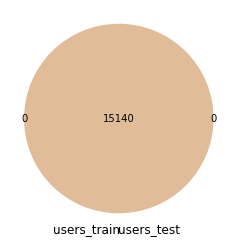

In [27]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
plt.figure(figsize=(4, 4))
venn2([set(users_train), set(users_test)], ['users_train', 'users_test'])
plt.show()

In [28]:
# sizes_train = user_item_train.groupby('user_id')['photo_id'].count().value_counts()
# sizes_test = user_item_test.groupby('user_id')['photo_id'].count().value_counts()
# sizes_train = sizes_train / np.sum(sizes_train)
# sizes_test = sizes_test / np.sum(sizes_test)

# plt.figure(figsize=(12,4))
# sns.barplot(sizes_train.index, sizes_train.values, alpha=0.8, color=p[0], label='train')
# sns.barplot(sizes_test.index, sizes_test.values, alpha=0.6, color=p[1], label='test')
# plt.legend()
# plt.xlabel('user', fontsize=12)
# plt.ylabel('Number of photos in user', fontsize=12)

In [29]:
photo_intersection_prop = 1. * len(set(user_item_train.photo_id.unique()) & set(user_item_test.photo_id.unique())) / len(user_item_test.photo_id.unique())

In [30]:
photo_intersection_prop

0.0

In [31]:
face_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1613135 entries, 0 to 1613134
Data columns (total 2 columns):
photo_id    1613135 non-null int64
faces       1613135 non-null object
dtypes: int64(1), object(1)
memory usage: 24.6+ MB


In [32]:
def add_face_feature(face_data):
    def ages_avg(lists):
        ages = [l[2] for l in lists if l[1] == 1]
        return reduce(ages, lambda x, y: x + y) / len(ages)
    face_data['faces'] = face_data['faces'].apply(eval)
    face_data['face_num'] = face_data['faces'].apply(lambda l : len(l))
    face_data['man_num'] = face_data['faces'].apply(lambda lists: len([1 for l in lists if l[1] == 1]))
    face_data['woman_num'] = face_data['faces'].apply(lambda lists: len([1 for l in lists if l[1] == 0]))
    face_data['man_scale'] = face_data['faces'].apply(lambda lists: sum([l[0] for l in lists if l[1] == 1]))
    face_data['woman_scale'] = face_data['faces'].apply(lambda lists: sum([l[0] for l in lists if l[1] == 0]))
    face_data['human_scale'] = face_data['man_scale'] + face_data['woman_scale']
    face_data['man_avg_age'] = face_data['faces'].apply(lambda lists: np.mean([l[2] for l in lists if l[1] == 1]))
    face_data['woman_avg_age'] = face_data['faces'].apply(lambda lists: np.mean([l[2] for l in lists if l[1] == 0]))
    face_data['human_avg_age'] = face_data['faces'].apply(lambda lists: np.mean([l[2] for l in lists]))
    face_data['man_avg_attr'] = face_data['faces'].apply(lambda lists: np.mean([l[3] for l in lists if l[1] == 1]))
    face_data['woman_avg_attr'] = face_data['faces'].apply(lambda lists: np.mean([l[3] for l in lists if l[1] == 0]))
    face_data['human_avg_attr'] = face_data['faces'].apply(lambda lists: np.mean([l[3] for l in lists]))
    return face_data

In [33]:
face_data = pd.concat([face_train, face_test])

In [34]:
face_tata = add_face_feature(face_data)

/Library/Python/2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [35]:
face_data.fillna(0, inplace=True)

In [36]:
face_data.head()

,photo_id,faces,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,9,"[[0.0377, 1, 3, 50]]",1,1,0,0.0377,0.0000,0.0377,3.0,0.0,3.0,50.0,0.0,50.0
1,3,"[[0.219, 0, 22, 66]]",1,0,1,0.0000,0.2190,0.2190,0.0,22.0,22.0,0.0,66.0,66.0
2,8,"[[0.0849, 0, 13, 54], [0.1221, 0, 22, 88]]",2,0,2,0.0000,0.2070,0.2070,0.0,17.5,17.5,0.0,71.0,71.0
3,2,"[[0.2018, 1, 18, 60]]",1,1,0,0.2018,0.0000,0.2018,18.0,0.0,18.0,60.0,0.0,60.0
4,19,"[[0.0123, 0, 24, 52]]",1,0,1,0.0000,0.0123,0.0123,0.0,24.0,24.0,0.0,52.0,52.0


In [37]:
face_data.drop(['faces'], axis=1, inplace=True)

In [38]:
face_data.head()

,photo_id,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,9,1,1,0,0.0377,0.0000,0.0377,3.0,0.0,3.0,50.0,0.0,50.0
1,3,1,0,1,0.0000,0.2190,0.2190,0.0,22.0,22.0,0.0,66.0,66.0
2,8,2,0,2,0.0000,0.2070,0.2070,0.0,17.5,17.5,0.0,71.0,71.0
3,2,1,1,0,0.2018,0.0000,0.2018,18.0,0.0,18.0,60.0,0.0,60.0
4,19,1,0,1,0.0000,0.0123,0.0123,0.0,24.0,24.0,0.0,52.0,52.0


In [39]:
np.sum(face_data['face_num']>=2)

311640

In [40]:
face_data.head()

,photo_id,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,9,1,1,0,0.0377,0.0000,0.0377,3.0,0.0,3.0,50.0,0.0,50.0
1,3,1,0,1,0.0000,0.2190,0.2190,0.0,22.0,22.0,0.0,66.0,66.0
2,8,2,0,2,0.0000,0.2070,0.2070,0.0,17.5,17.5,0.0,71.0,71.0
3,2,1,1,0,0.2018,0.0000,0.2018,18.0,0.0,18.0,60.0,0.0,60.0
4,19,1,0,1,0.0000,0.0123,0.0123,0.0,24.0,24.0,0.0,52.0,52.0


In [41]:
def plot_data_cut(df, col, n_bins=20):
    quartiles = pd.cut(df[col], n_bins)
    grouped = df.groupby(quartiles)
    
    plt.figure(figsize=(30,15)) 
    plt.xlabel(col)
    plt.ylabel('counts in ' + col)
    nums_of_col = grouped.size()
    nums_of_col.plot.bar()

In [42]:
num_train, num_test = face_train.shape[0],face_test.shape[0]

In [43]:
num_train,num_test

(1613135, 329056)

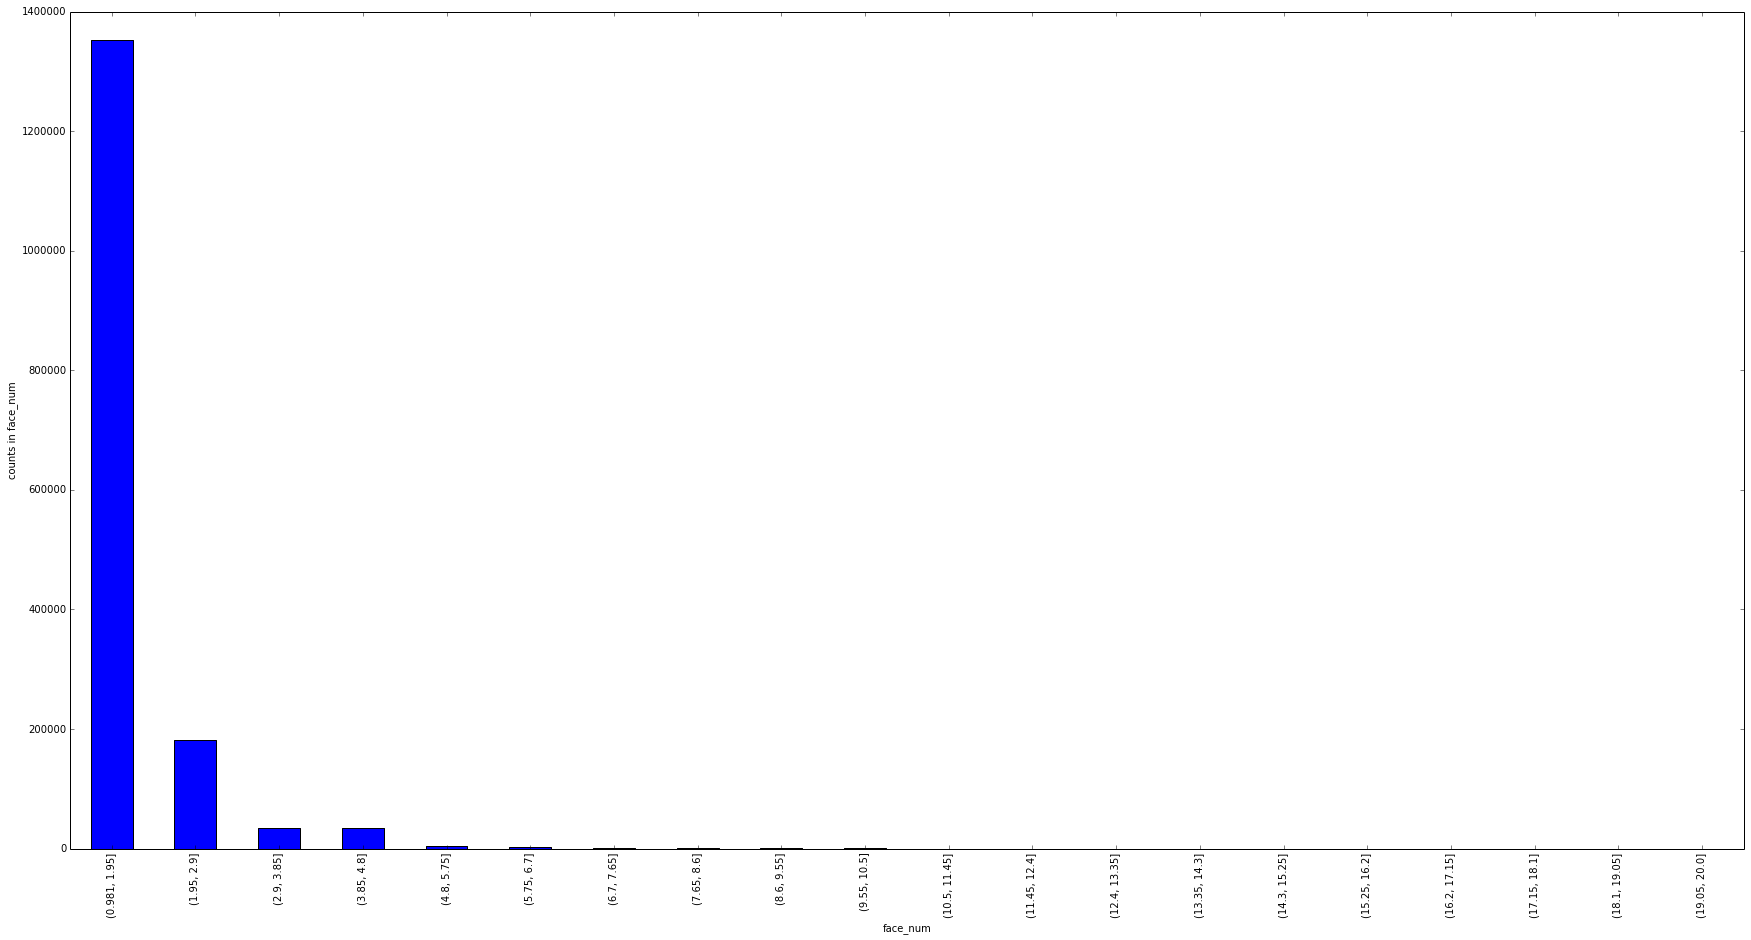

In [44]:
plot_data_cut(face_data.iloc[:num_train], 'face_num', 20)

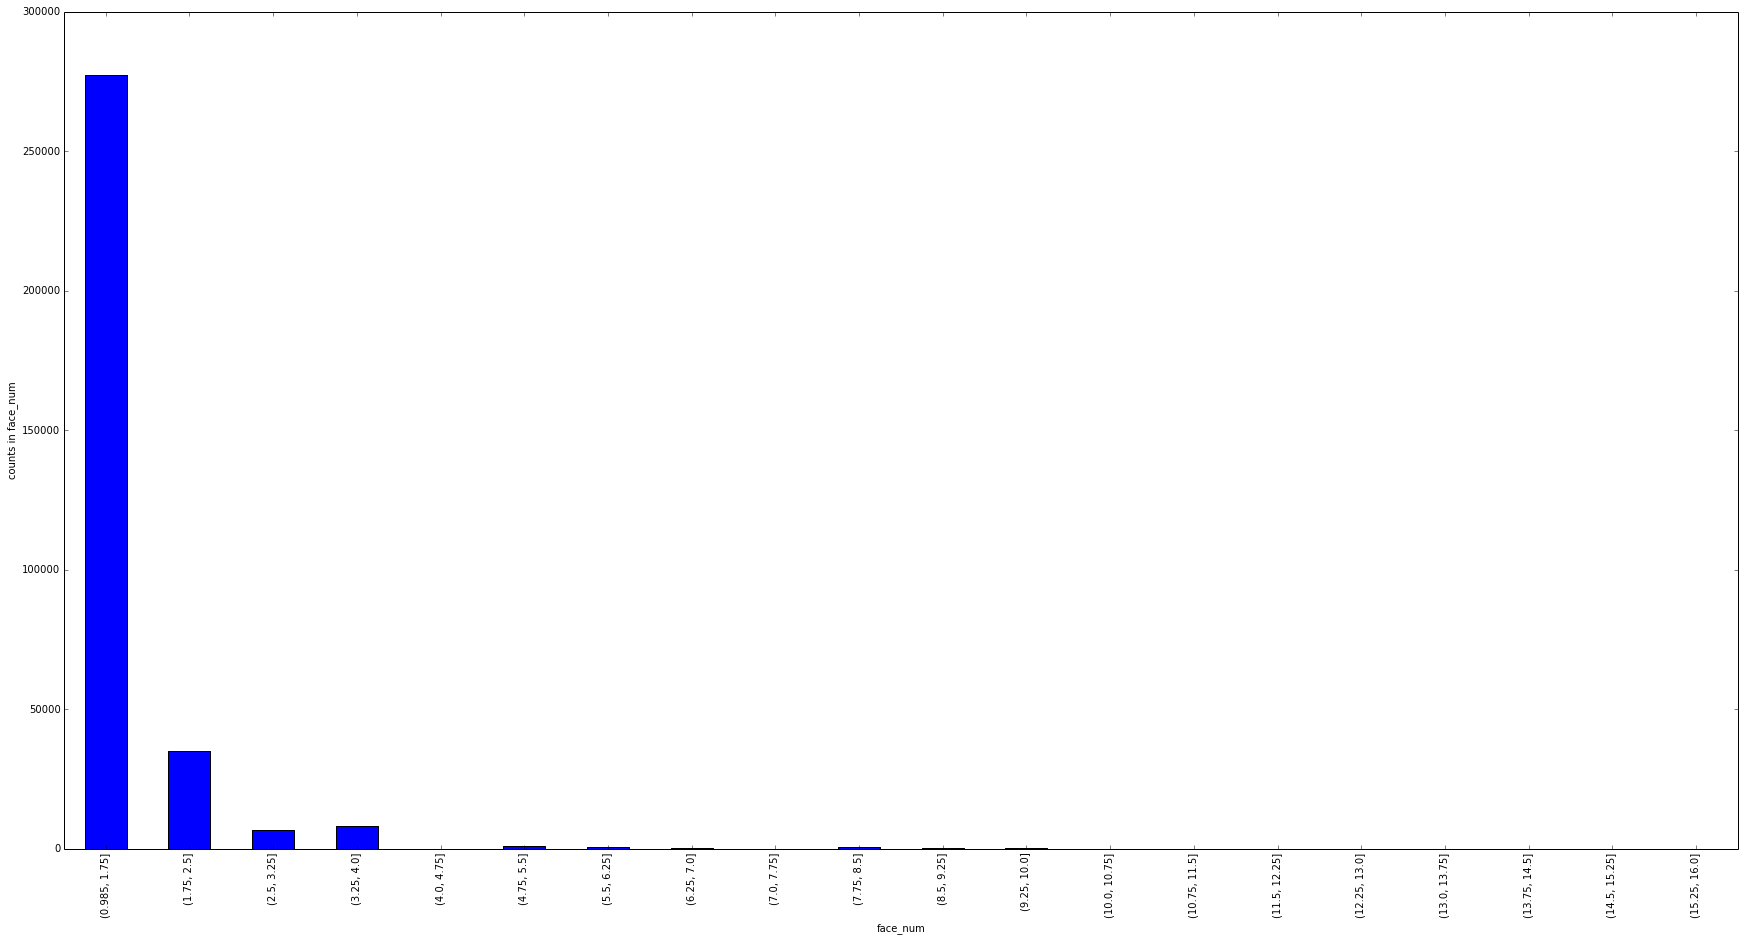

In [45]:
plot_data_cut(face_data.iloc[num_train:], 'face_num', 20)

In [46]:
user_item_data = pd.concat([user_item_train[['user_id', 'photo_id', 'time', 'duration_time']], user_item_test])

photo_data = pd.DataFrame()
photo_data['photo_id'] = user_item_data['photo_id']
# photo_data['duration_time'] = user_item_data['duration_time']
photo_data['exposure_num'] = user_item_data['photo_id'].groupby(user_item_data['photo_id']).transform('count') 
photo_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24145676 entries, 0 to 3291331
Data columns (total 2 columns):
photo_id        int64
exposure_num    int64
dtypes: int64(2)
memory usage: 552.7 MB


In [47]:
photo_data.drop_duplicates(inplace=True)
photo_data = pd.merge(photo_data, face_data,
                 how="left",
                 on=['photo_id'])



In [48]:
photo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5174532 entries, 0 to 5174531
Data columns (total 14 columns):
photo_id          int64
exposure_num      int64
face_num          float64
man_num           float64
woman_num         float64
man_scale         float64
woman_scale       float64
human_scale       float64
man_avg_age       float64
woman_avg_age     float64
human_avg_age     float64
man_avg_attr      float64
woman_avg_attr    float64
human_avg_attr    float64
dtypes: float64(12), int64(2)
memory usage: 592.2 MB


In [49]:
photo_data.fillna(0, inplace=True)


In [50]:
photo_data.head(10)

,photo_id,exposure_num,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,6484142,13,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,4647664,2,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,4994626,34,3.0,3.0,0.0,0.3959,0.0000,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333
3,4416881,1,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,2597756,2,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
5,4977481,155,3.0,3.0,0.0,0.0103,0.0000,0.0103,27.000000,0.0,27.000000,51.666667,0.0,51.666667
6,5089000,852,1.0,0.0,1.0,0.0000,0.0384,0.0384,0.000000,22.0,22.000000,0.000000,84.0,84.000000
7,693195,55,2.0,1.0,1.0,0.0162,0.0094,0.0256,27.000000,27.0,27.000000,50.000000,51.0,50.500000
8,163901,265,2.0,1.0,1.0,0.0088,0.0104,0.0192,21.000000,27.0,24.000000,56.000000,48.0,52.000000
9,6472236,1,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [51]:
photo_data[photo_data['photo_id'] == 4647664]

,photo_id,exposure_num,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
1,4647664,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
np.sum(photo_data['face_num']>=1)

1942191

In [53]:
# lower, higher = int(photo_data.face_num.min()), int(photo_data.face_num.max())
# print(lower, higher)
# n_bins = 10
# # edges = range(lower, higher+1, (higher-lower)/n_bins)
# # lbs = ['[%d, %d)'%(edges[i], edges[i+1]) for i in range(len(edges))]
# # quartiles = pd.cut(photo_data.face_num, bins=n_bins, labels=lbs, include_lowest=True)
# quartiles = pd.cut(photo_data.face_num, 30)
# grouped = photo_data.groupby(quartiles)


# plt.figure(figsize=(30,15)) 
# plt.xlabel('face num')
# plt.ylabel('count of photos')
# photos_of_face_num = grouped.size()
# photos_of_face_num.plot.bar()

In [54]:
num_train, num_test = user_item_train['photo_id'].nunique(), user_item_test['photo_id'].nunique()

In [55]:
num_train, num_test

(4278686, 895846)

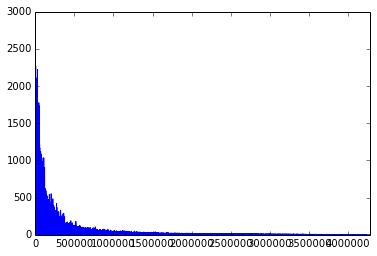

In [56]:
photo_data.iloc[:num_train].exposure_num.plot()

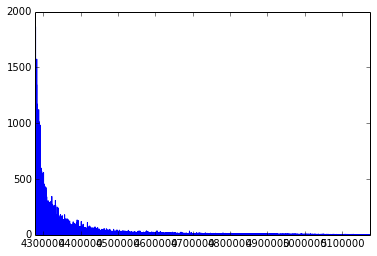

In [57]:
photo_data.iloc[num_train:].exposure_num.plot()

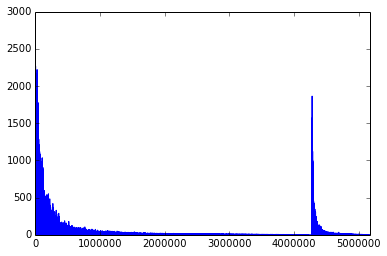

In [58]:
photo_data.exposure_num.plot()

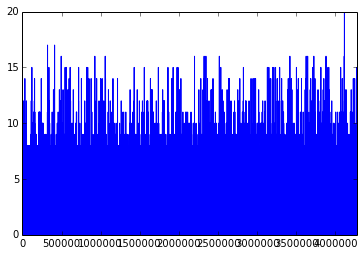

In [59]:
photo_data.iloc[:num_train].face_num.plot()

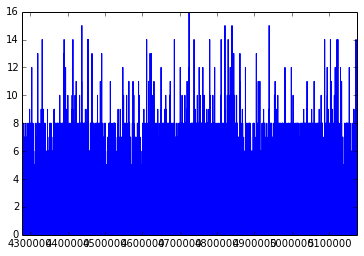

In [60]:
photo_data.iloc[num_train:].face_num.plot()

In [61]:
# photo_data.exposure_num.hist(bins=doanes(photo_data.exposure_num.dropna()), normed=True, color='lightseagreen')
# photo_data.exposure_num.dropna().plot(kind='kde', xlim=(0,600), style='r--')

In [62]:
photo_train = photo_data.iloc[:num_train]
photo_test = photo_data.iloc[num_train:]

In [63]:
photo_train.describe()

,photo_id,exposure_num,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
count,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06,4.278686e+06
mean,3.767701e+06,4.874007e+00,4.722672e-01,2.056365e-01,2.666307e-01,1.989924e-02,4.263127e-02,6.253051e-02,3.782480e+00,4.828193e+00,8.184566e+00,8.562786e+00,1.416926e+01,2.167710e+01
std,2.182717e+06,3.080765e+01,7.527644e-01,5.266906e-01,5.747615e-01,6.933147e-02,1.059722e-01,1.210479e-01,9.301504e+00,9.297086e+00,1.150953e+01,1.940648e+01,2.710182e+01,2.925503e+01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.867150e+06,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.792078e+06,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.648482e+06,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.350000e-02,0.000000e+00,0.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,5.000000e+01
max,7.560365e+06,2.521000e+03,2.000000e+01,1.600000e+01,1.900000e+01,2.253500e+00,1.318000e+00,2.253500e+00,3.900000e+01,3.900000e+01,3.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01


In [64]:
photo_test.describe()

,photo_id,exposure_num,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
count,8.958460e+05,895846.000000,895846.000000,895846.000000,895846.000000,895846.000000,895846.000000,895846.000000,895846.000000,895846.000000,895846.000000,895846.000000,895846.000000,895846.000000
mean,8.376024e+06,3.673993,0.460561,0.201265,0.259297,0.020213,0.041974,0.062187,3.638924,4.618487,7.867453,8.391489,13.502216,20.914205
std,4.744013e+05,19.974137,0.753710,0.522327,0.578269,0.070277,0.106239,0.121824,9.134860,9.125912,11.369465,19.218406,26.395786,28.750307
min,7.560367e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.960966e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.385468e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.782372e+06,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.059800,0.000000,0.000000,20.000000,0.000000,0.000000,49.000000
max,9.204230e+06,1864.000000,16.000000,16.000000,15.000000,1.387500,1.597900,1.597900,39.000000,39.000000,39.000000,97.000000,99.000000,99.000000


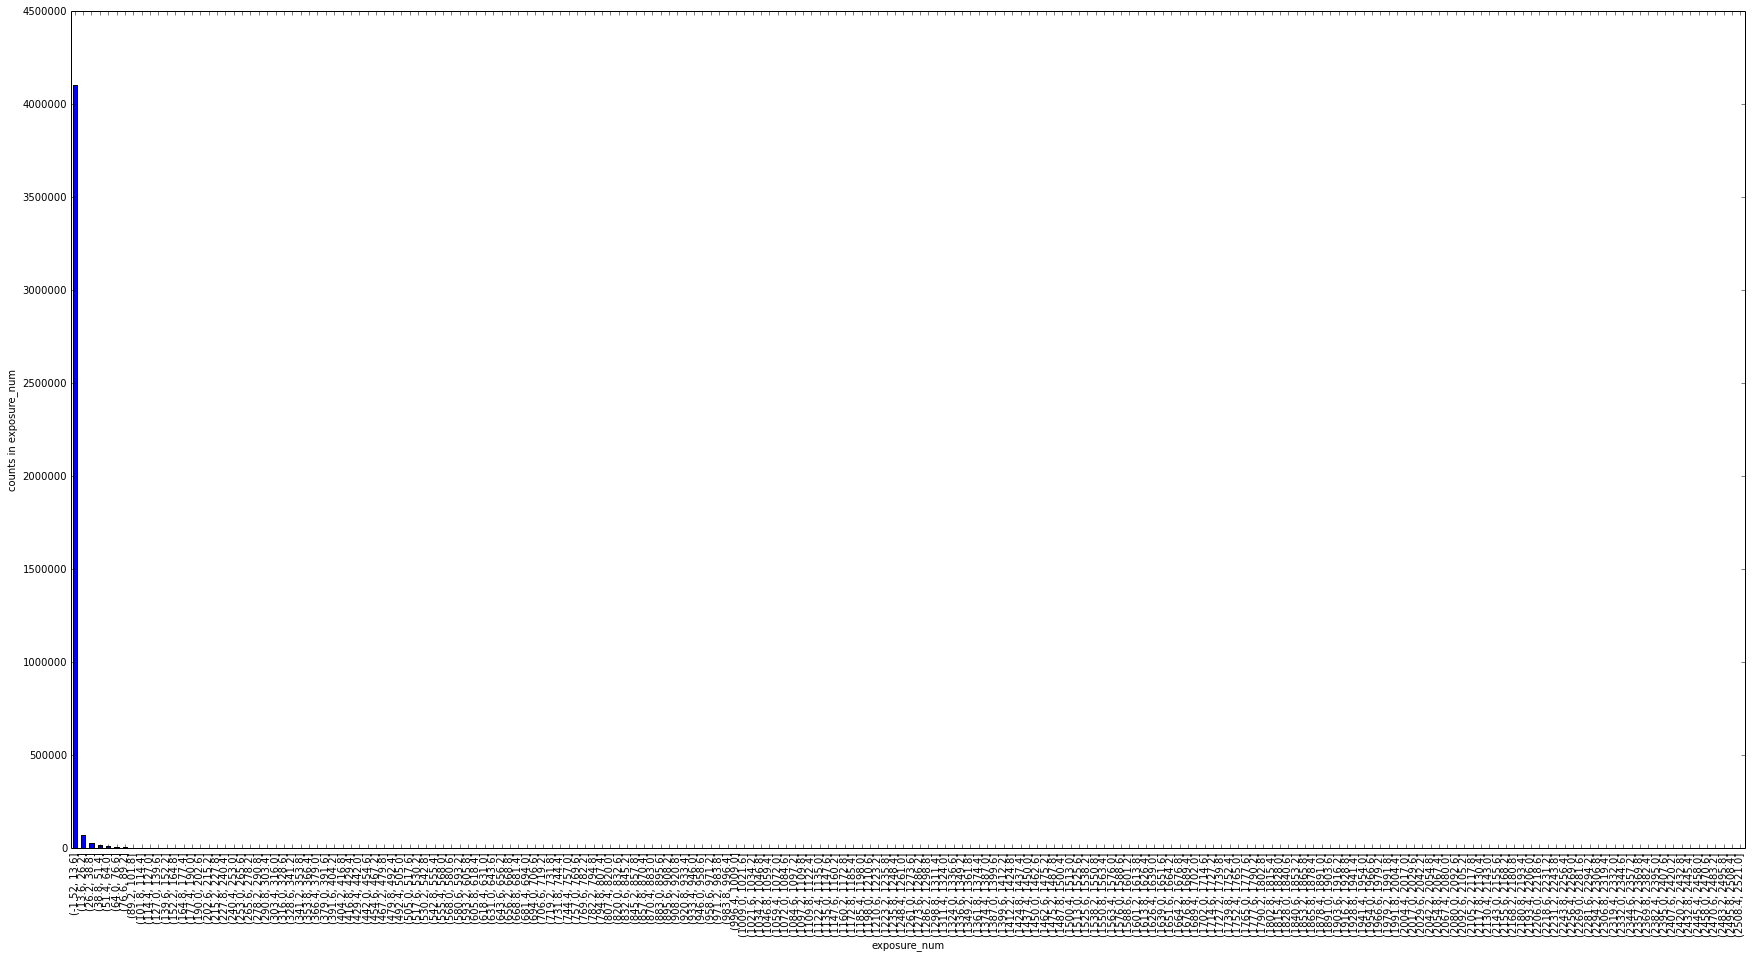

In [65]:
plot_data_cut(photo_train, 'exposure_num', 200)

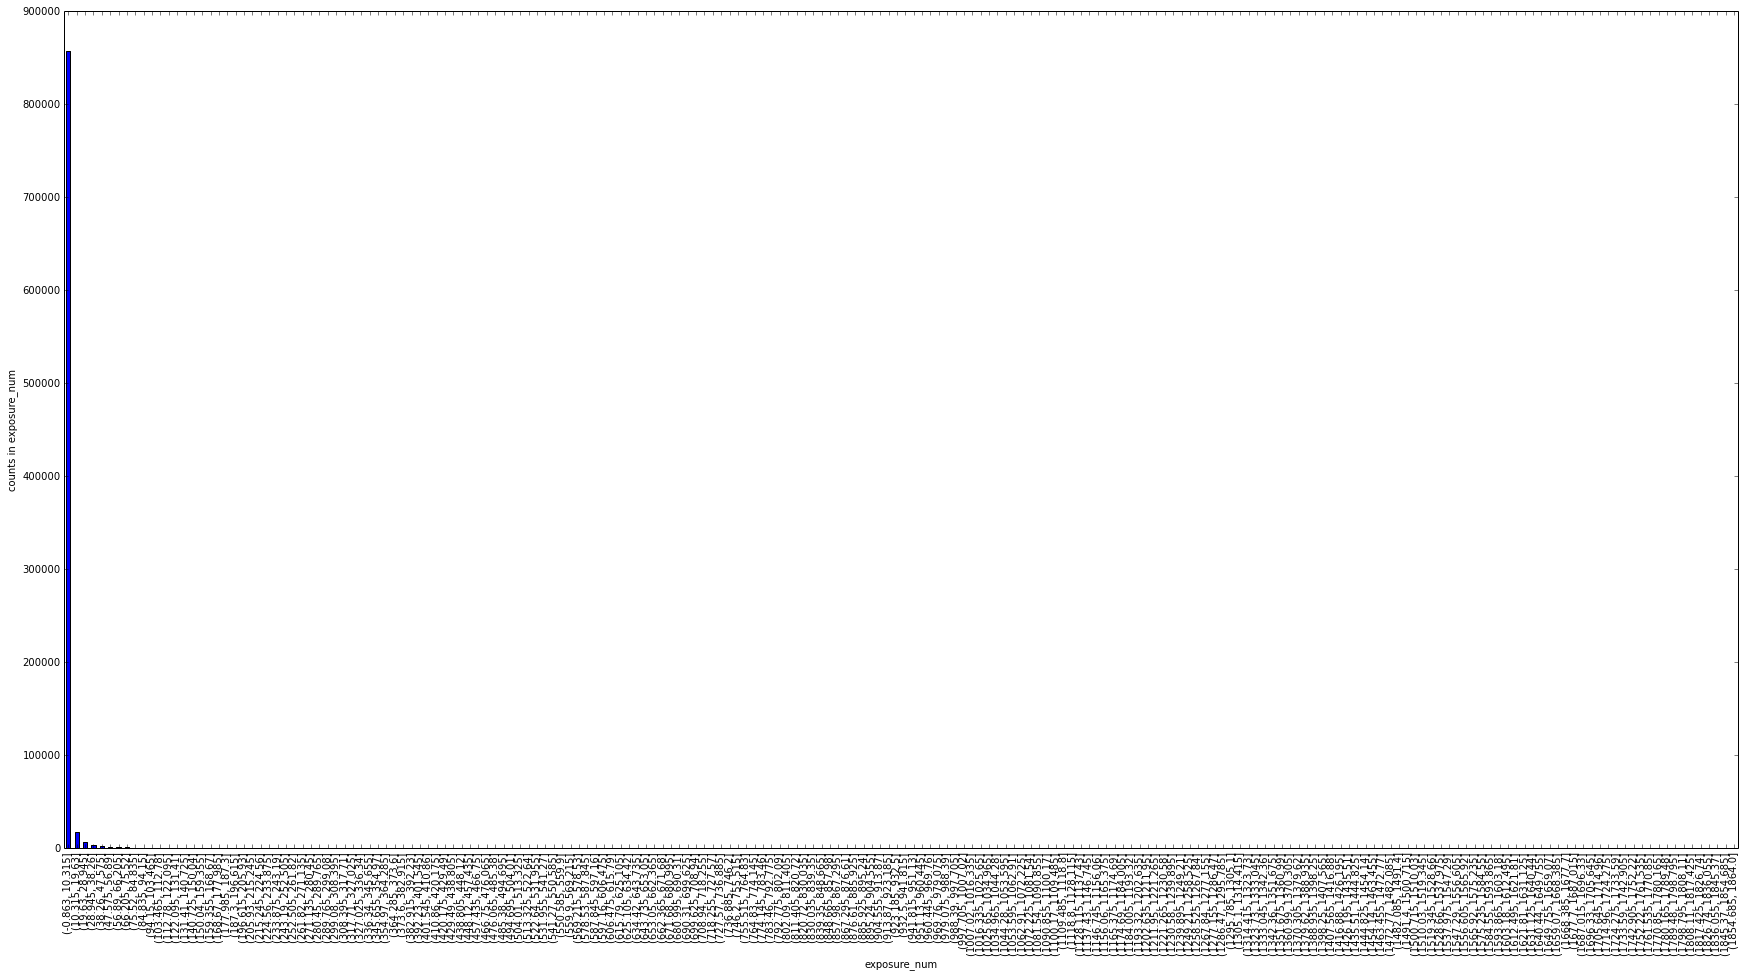

In [66]:
plot_data_cut(photo_test, 'exposure_num', 200)

In [50]:
# plot_data_cut(photo_data, 'duration_time', 100)

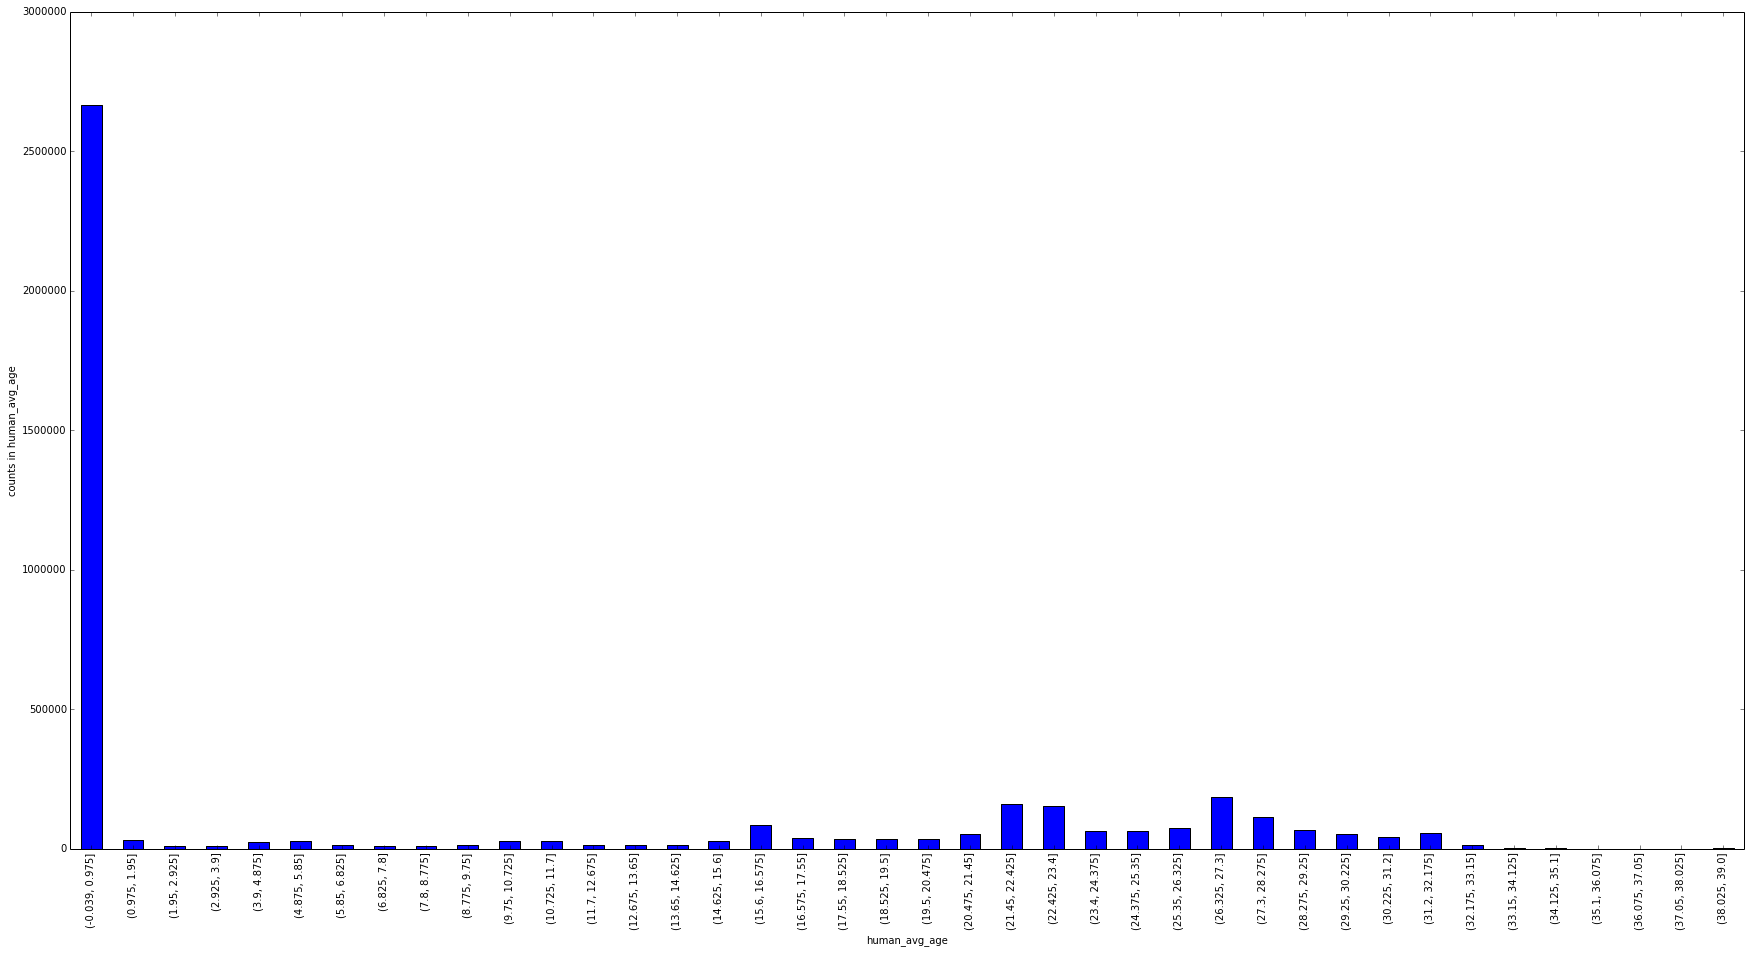

In [106]:
plot_data_cut(photo_train, 'human_avg_age', 40)

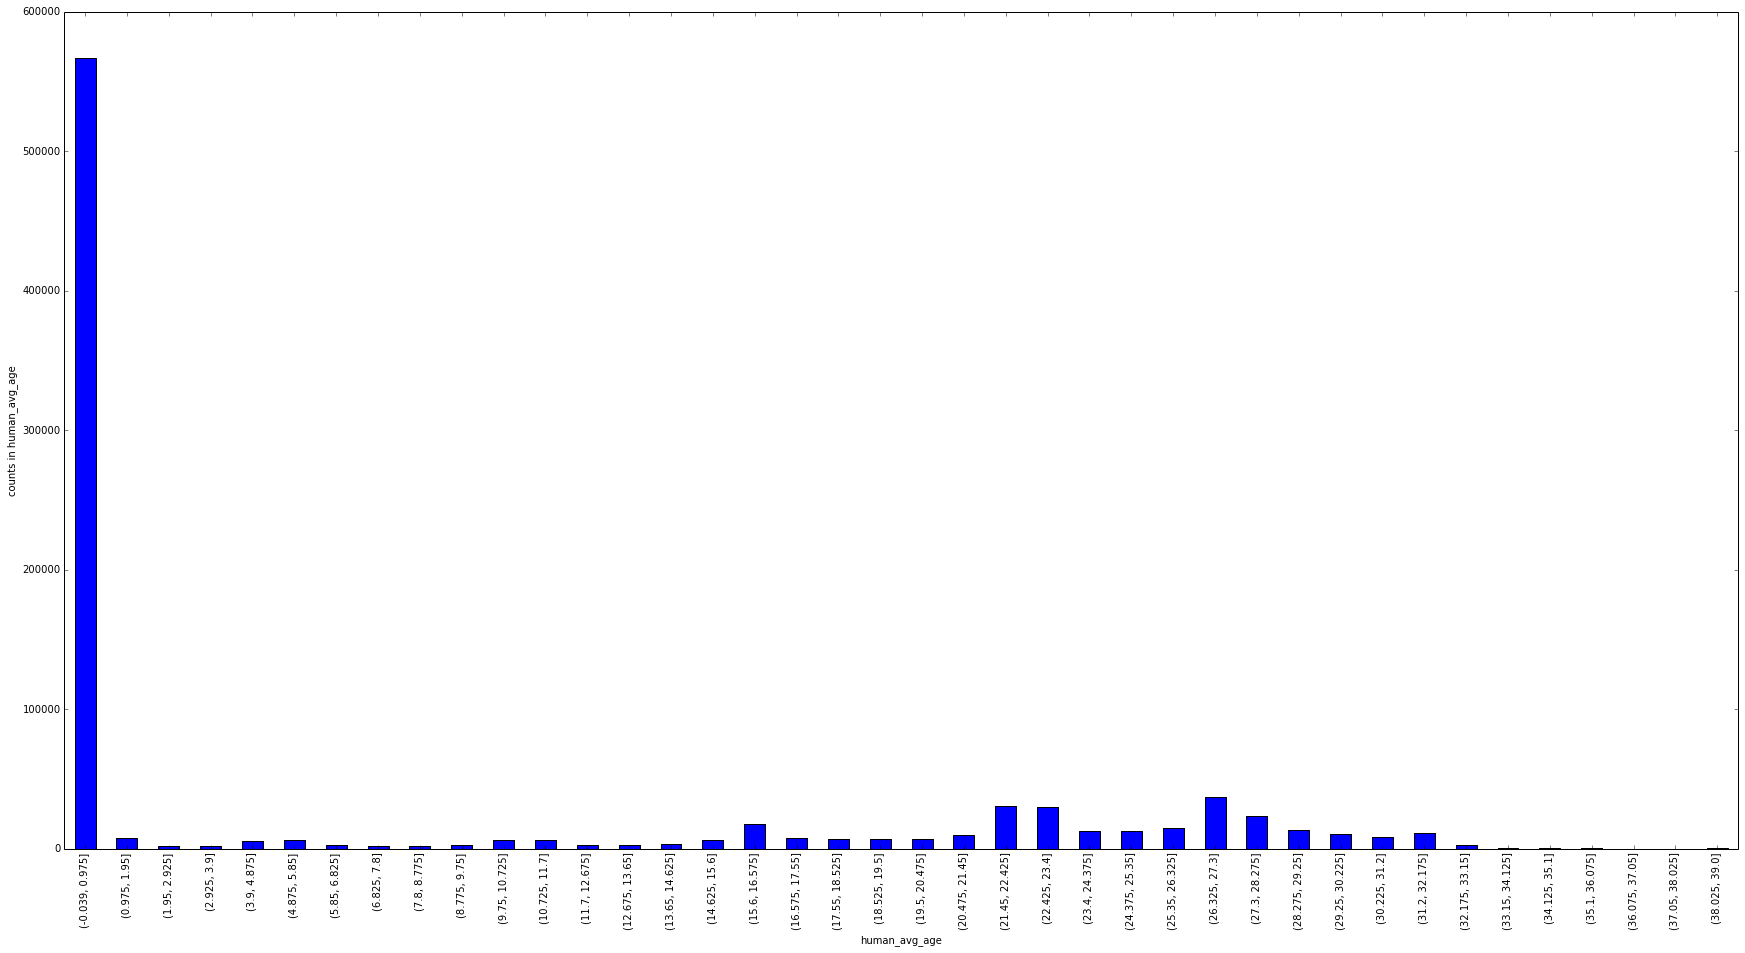

In [108]:
plot_data_cut(photo_test, 'human_avg_age', 40)

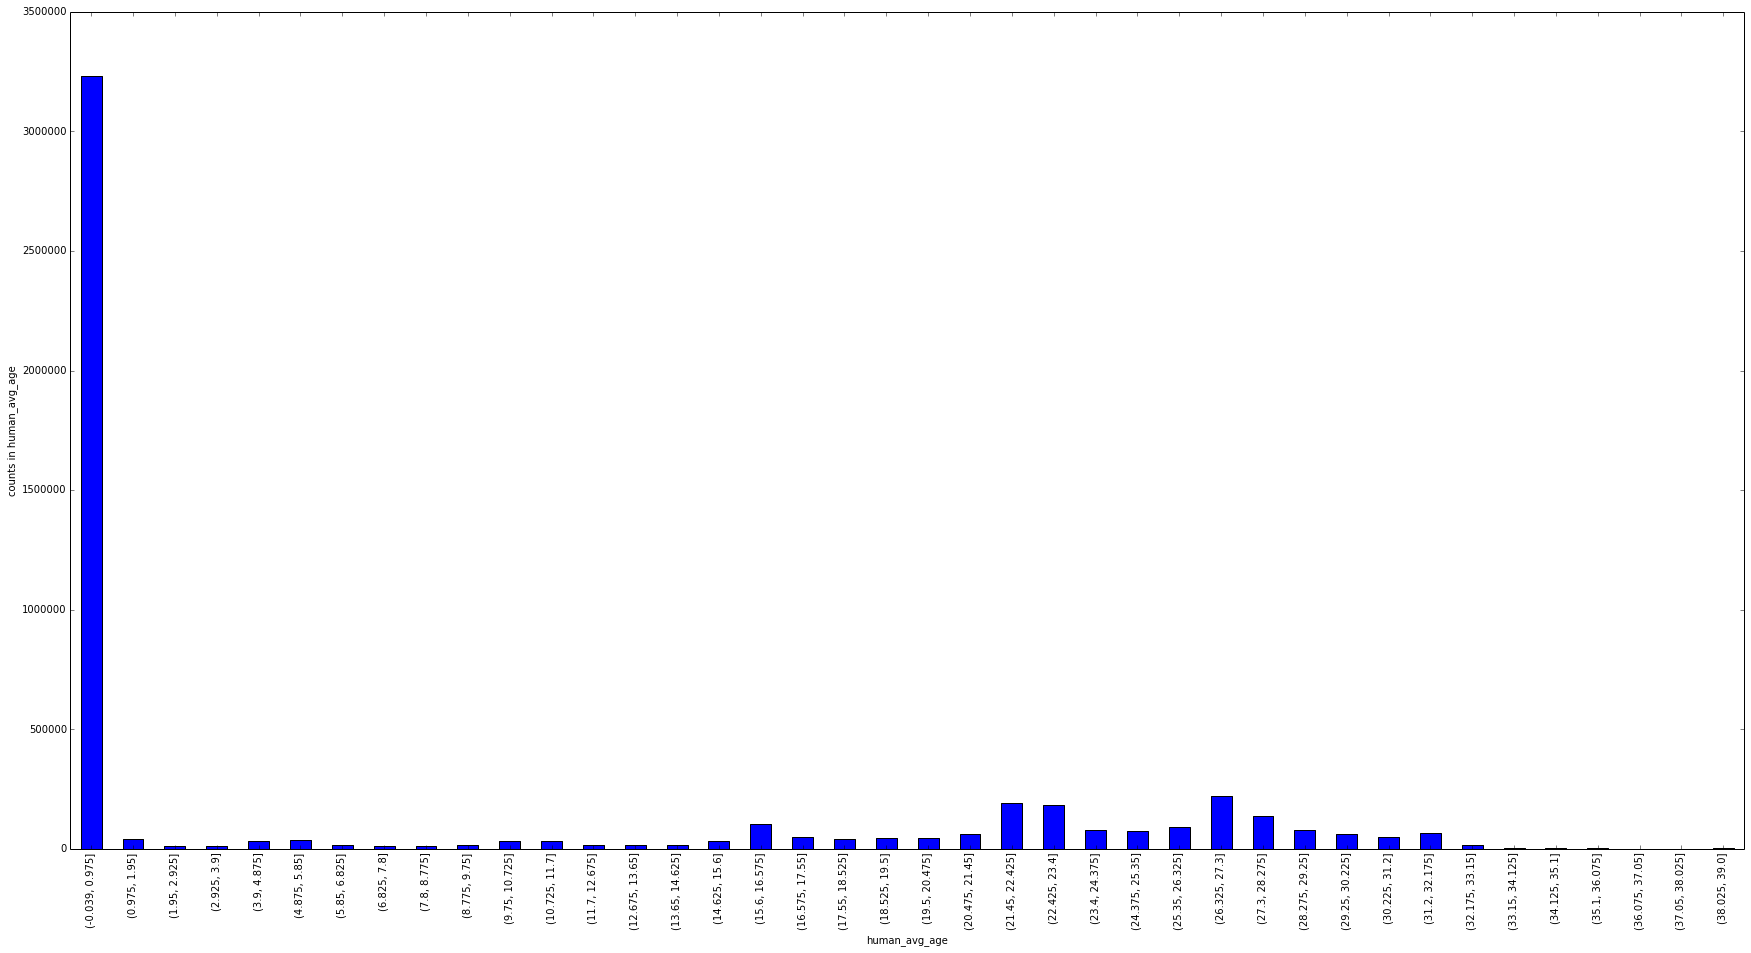

In [109]:
plot_data_cut(photo_data, 'human_avg_age', 40)

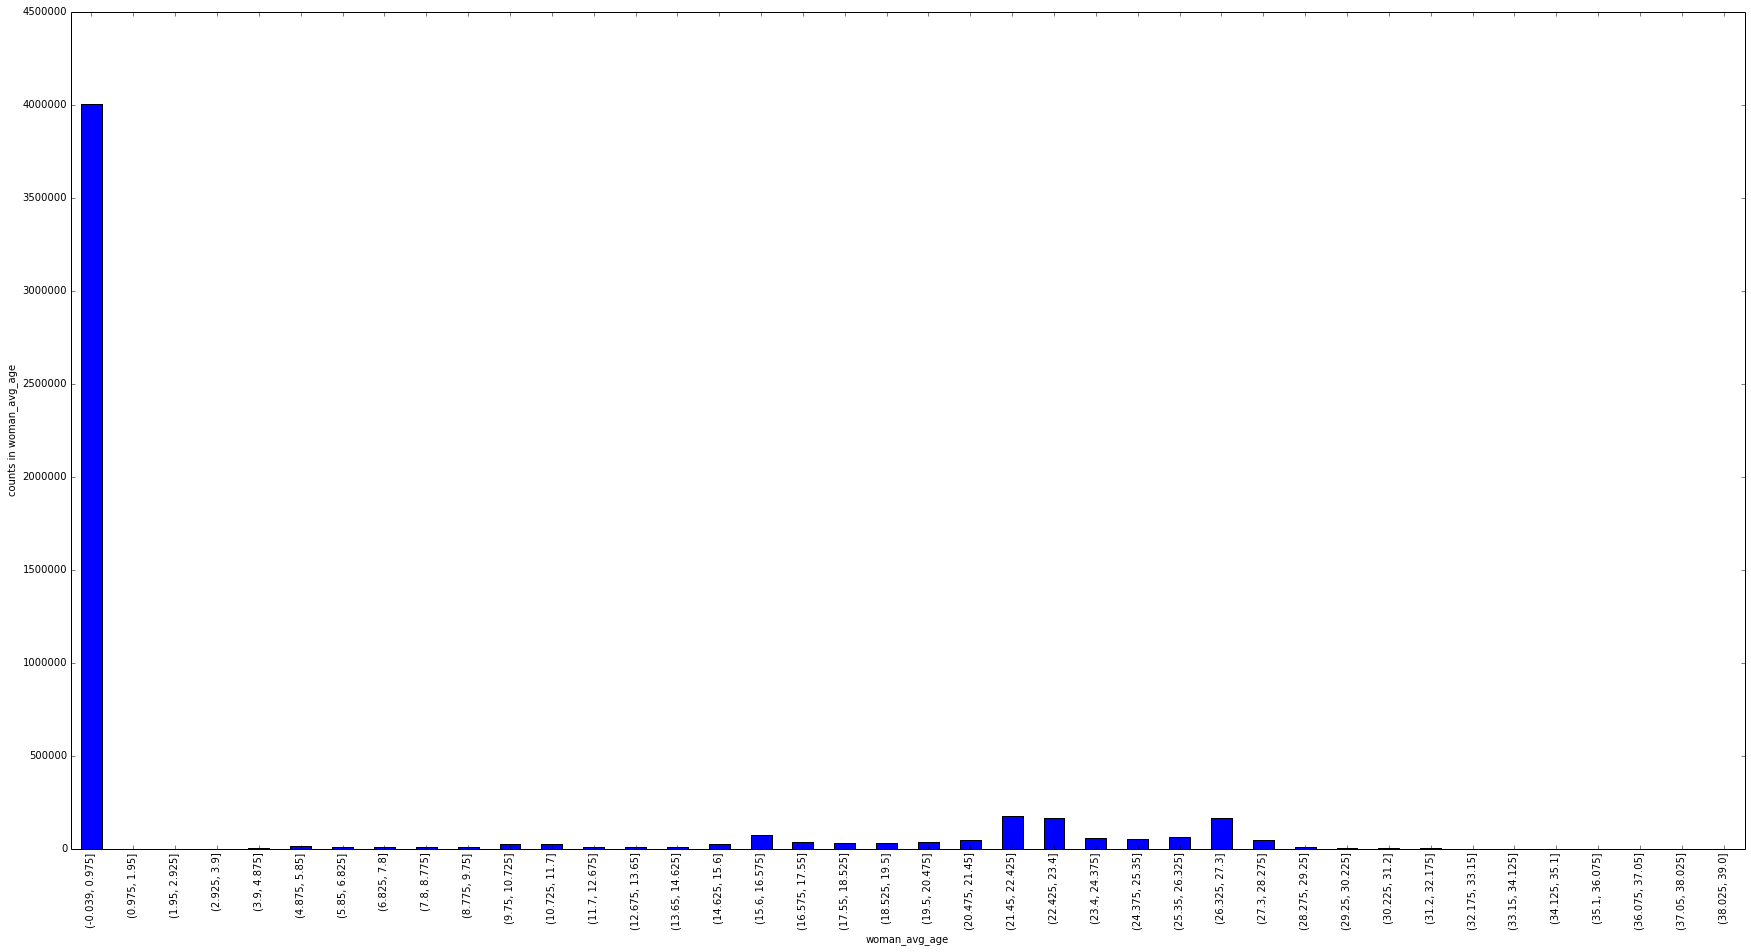

In [52]:
plot_data_cut(photo_data, 'woman_avg_age', 40)

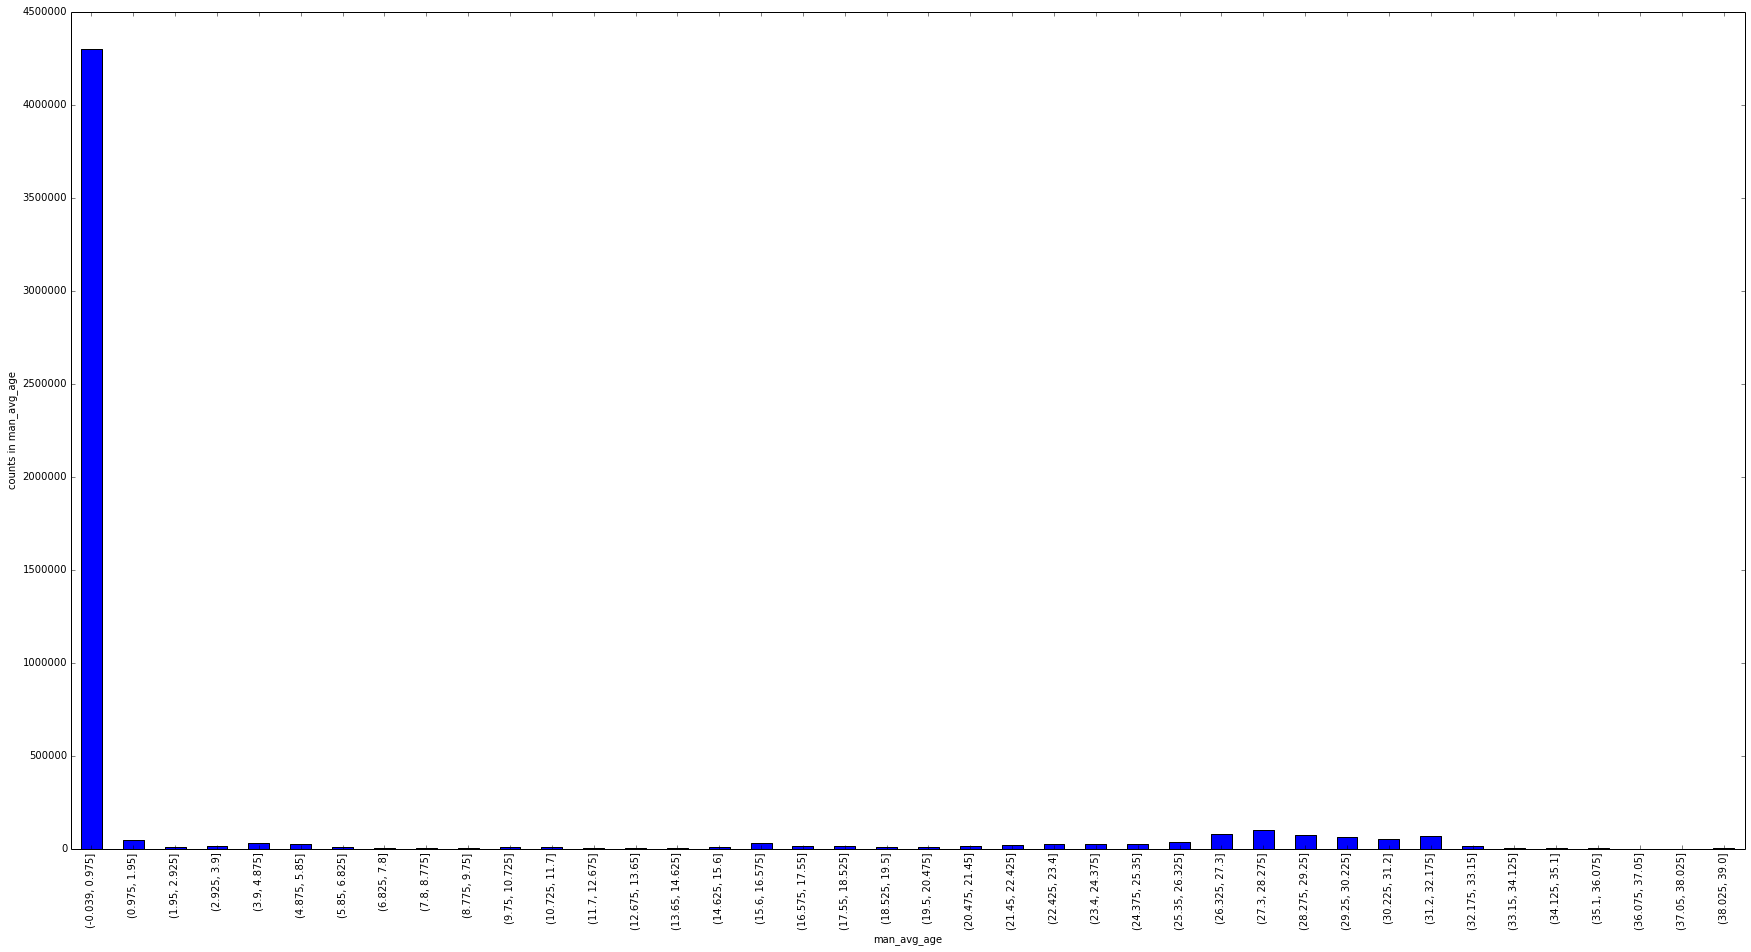

In [53]:
plot_data_cut(photo_data, 'man_avg_age', 40)

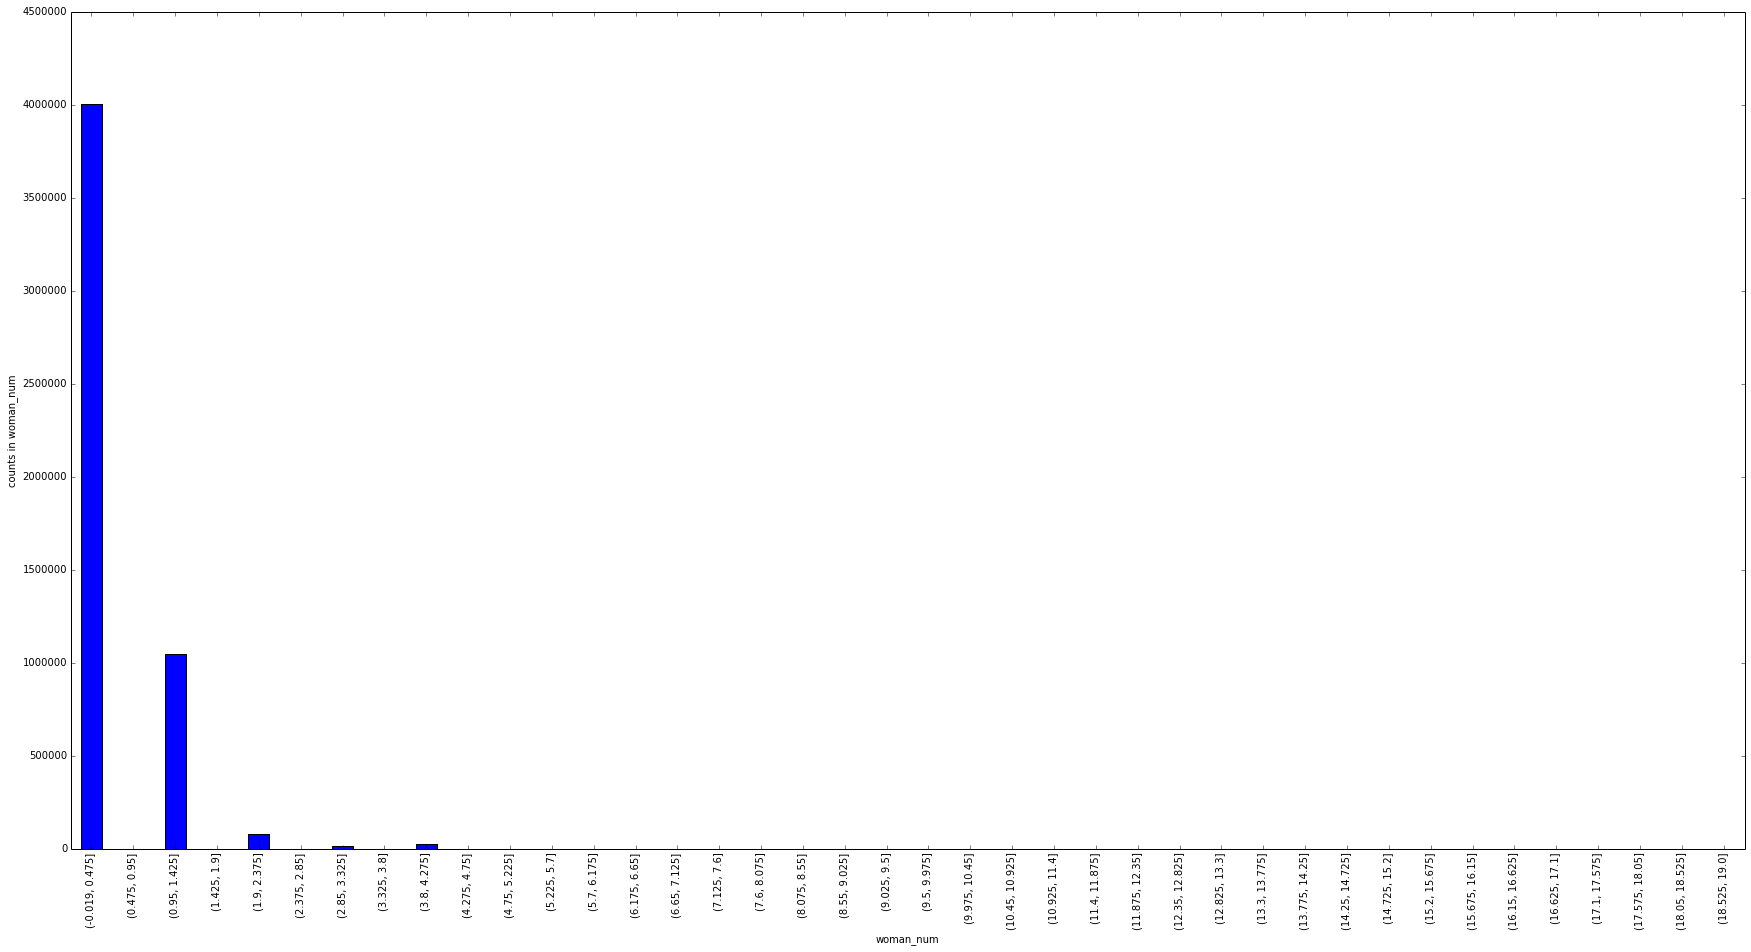

In [54]:
plot_data_cut(photo_data, 'woman_num', 40)

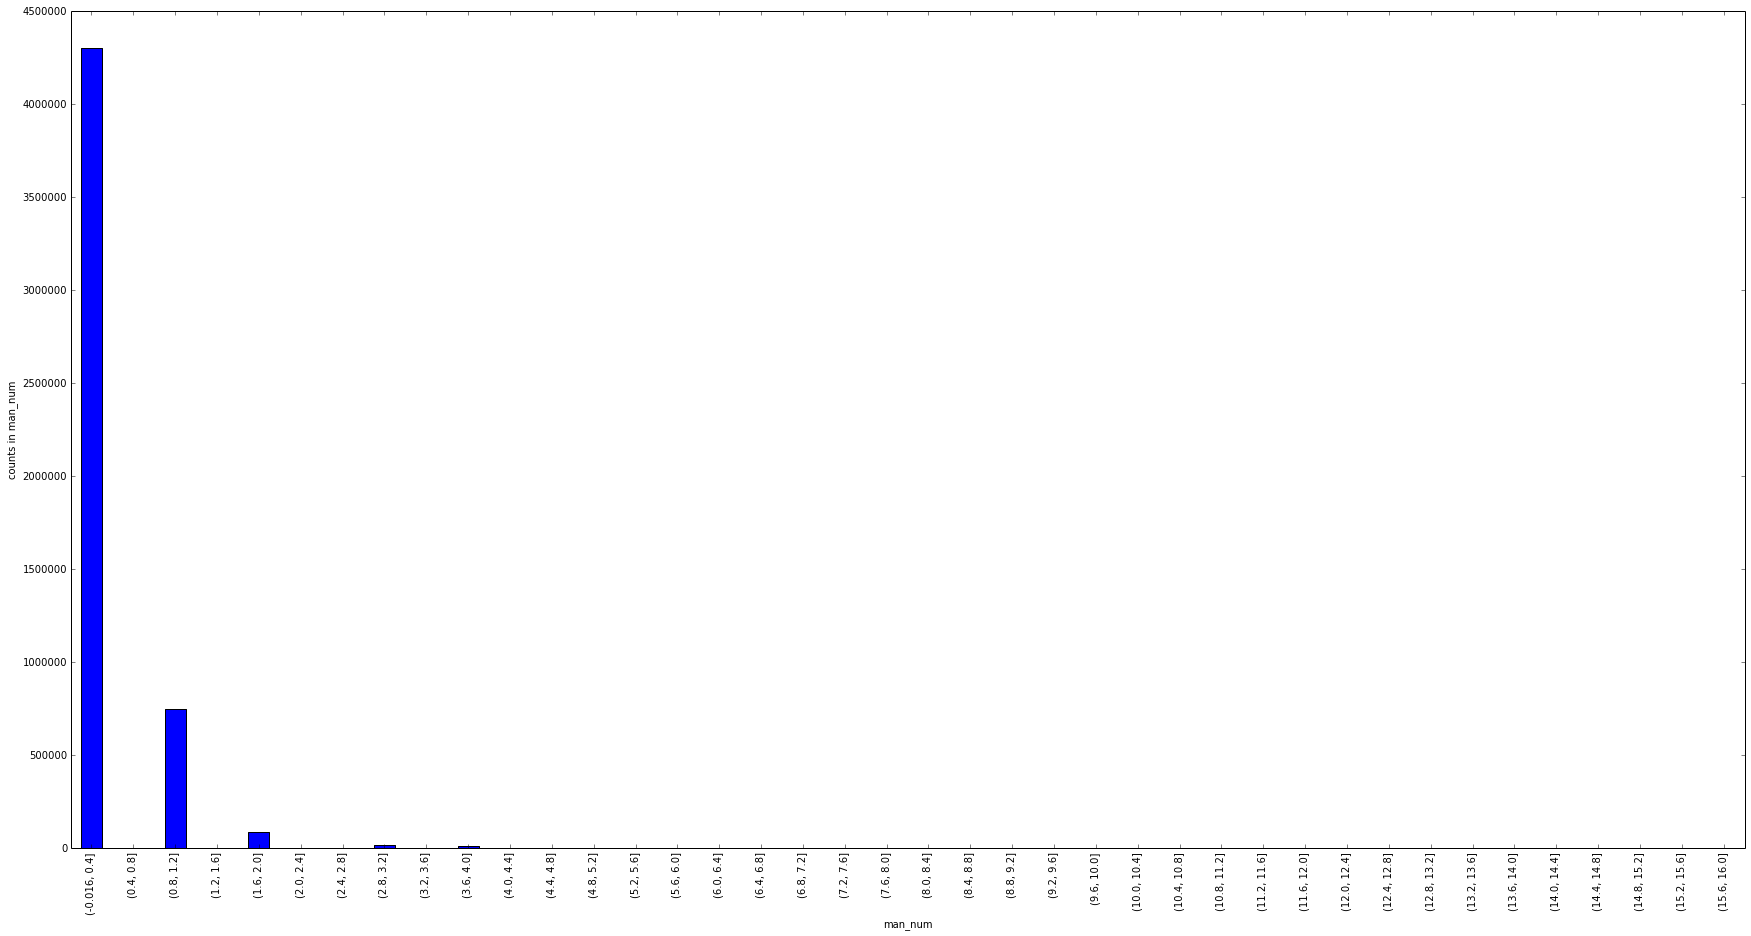

In [55]:
plot_data_cut(photo_data, 'man_num', 40)

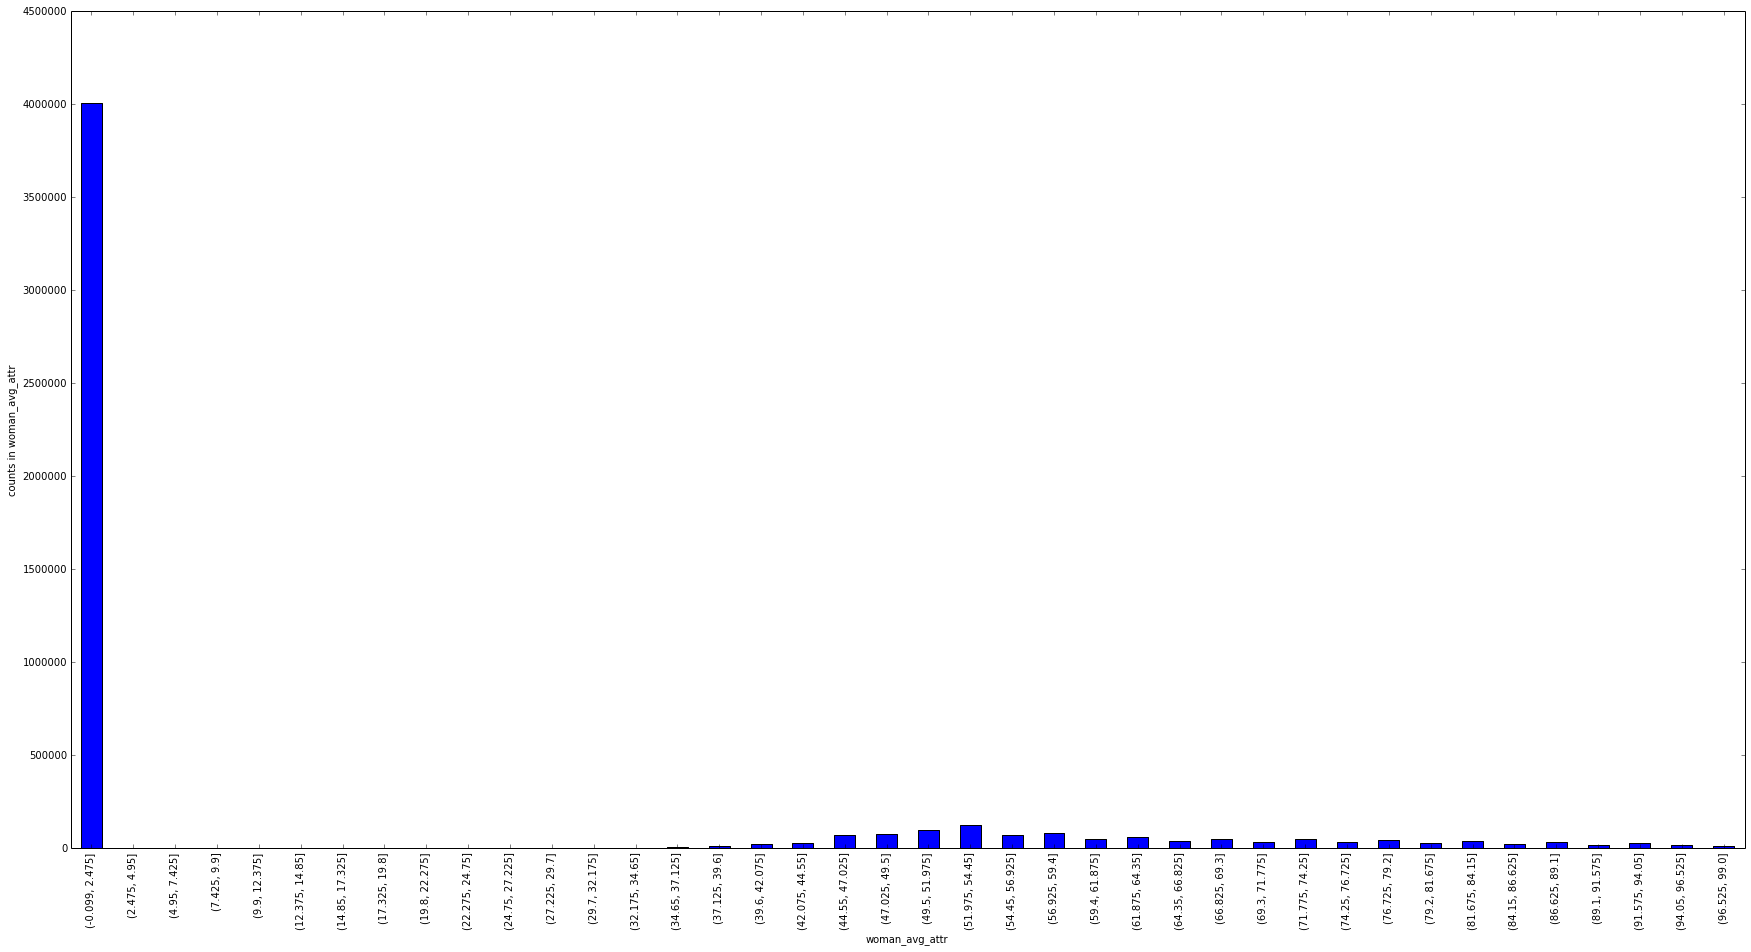

In [56]:
plot_data_cut(photo_data, 'woman_avg_attr', 40)

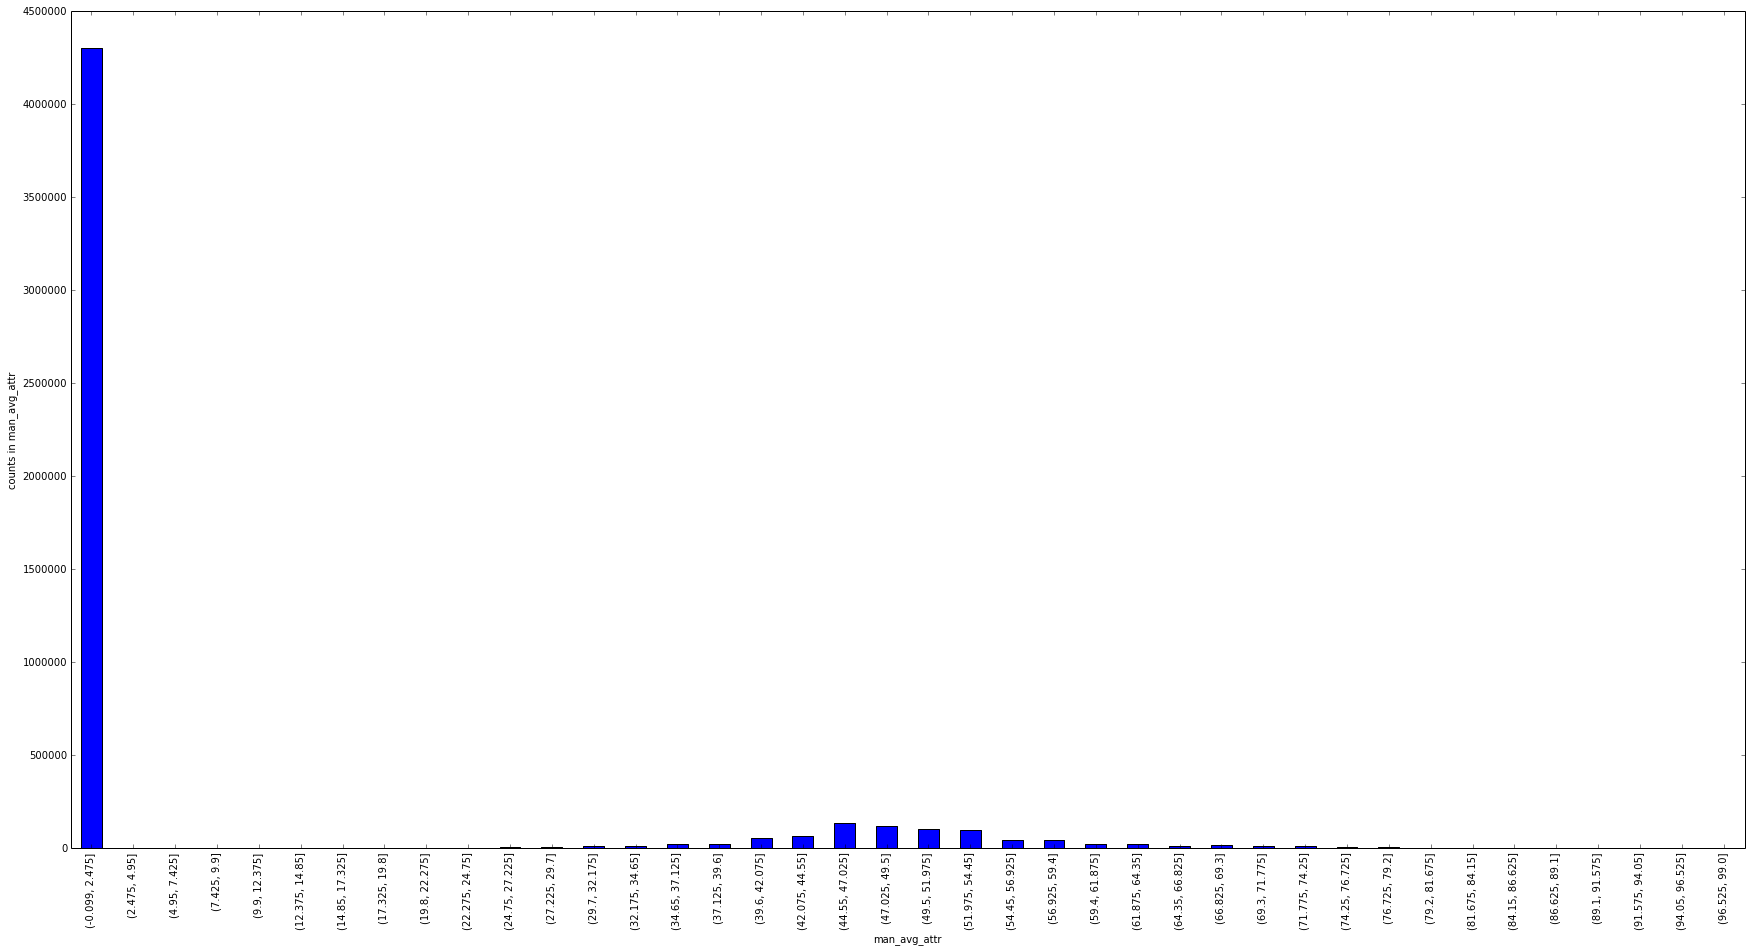

In [57]:
plot_data_cut(photo_data, 'man_avg_attr', 40)

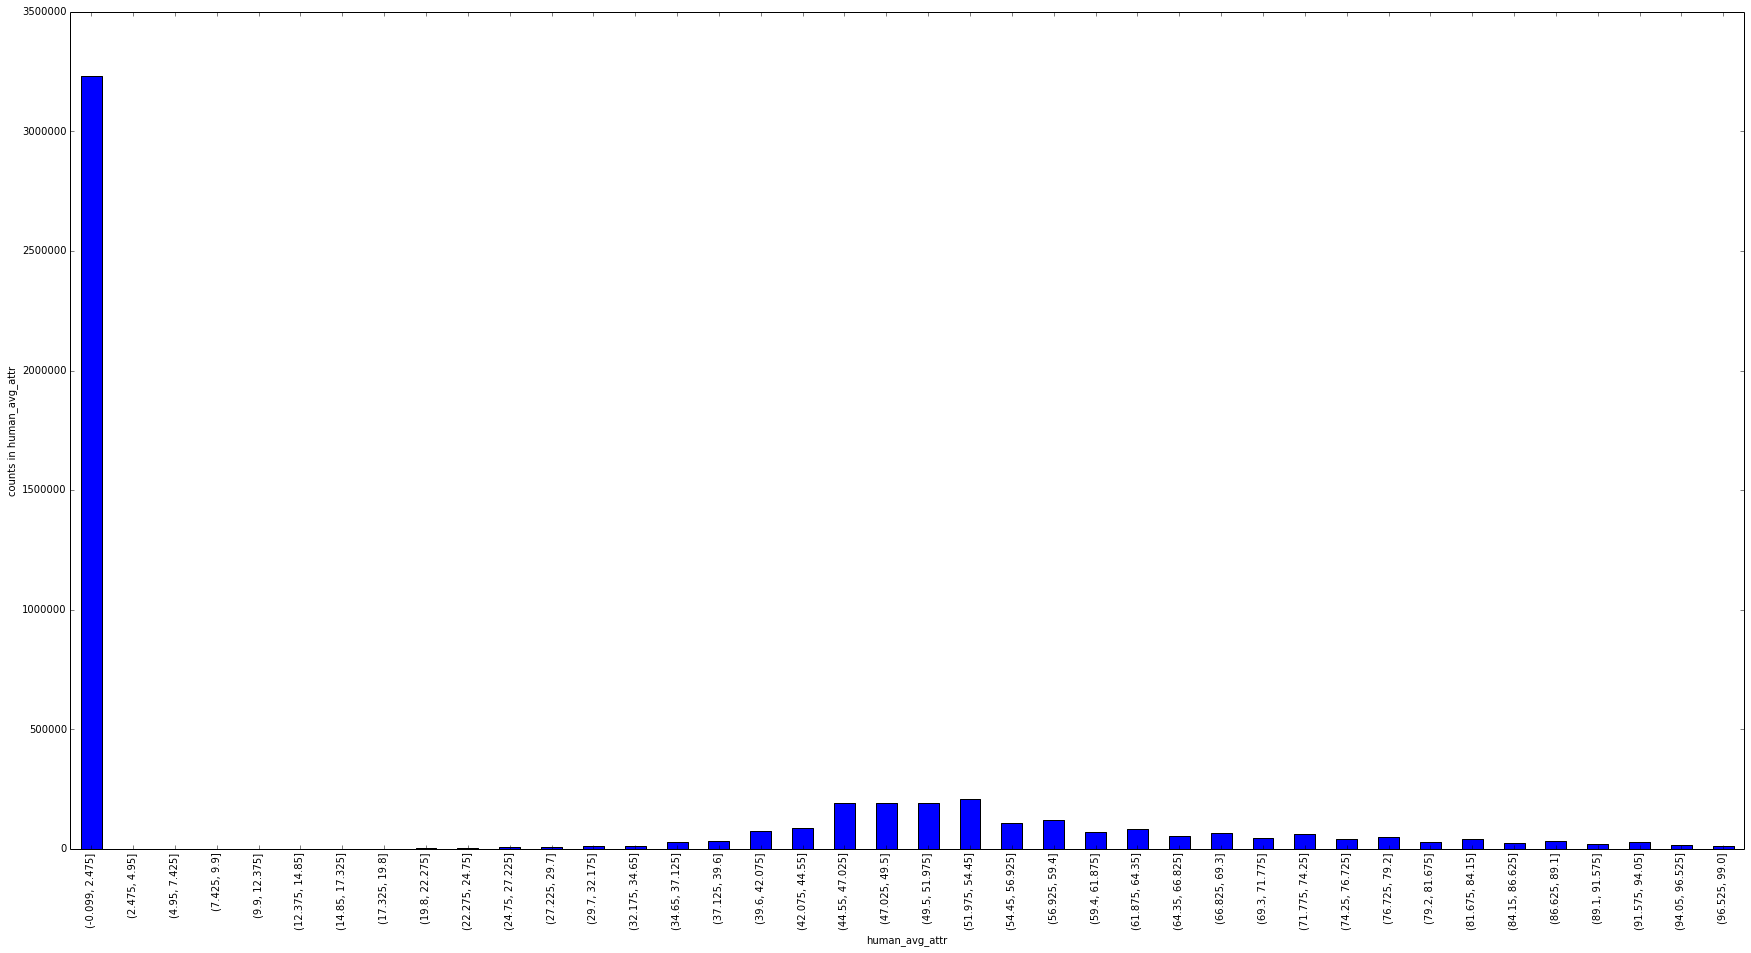

In [58]:
plot_data_cut(photo_data, 'human_avg_attr', 40)

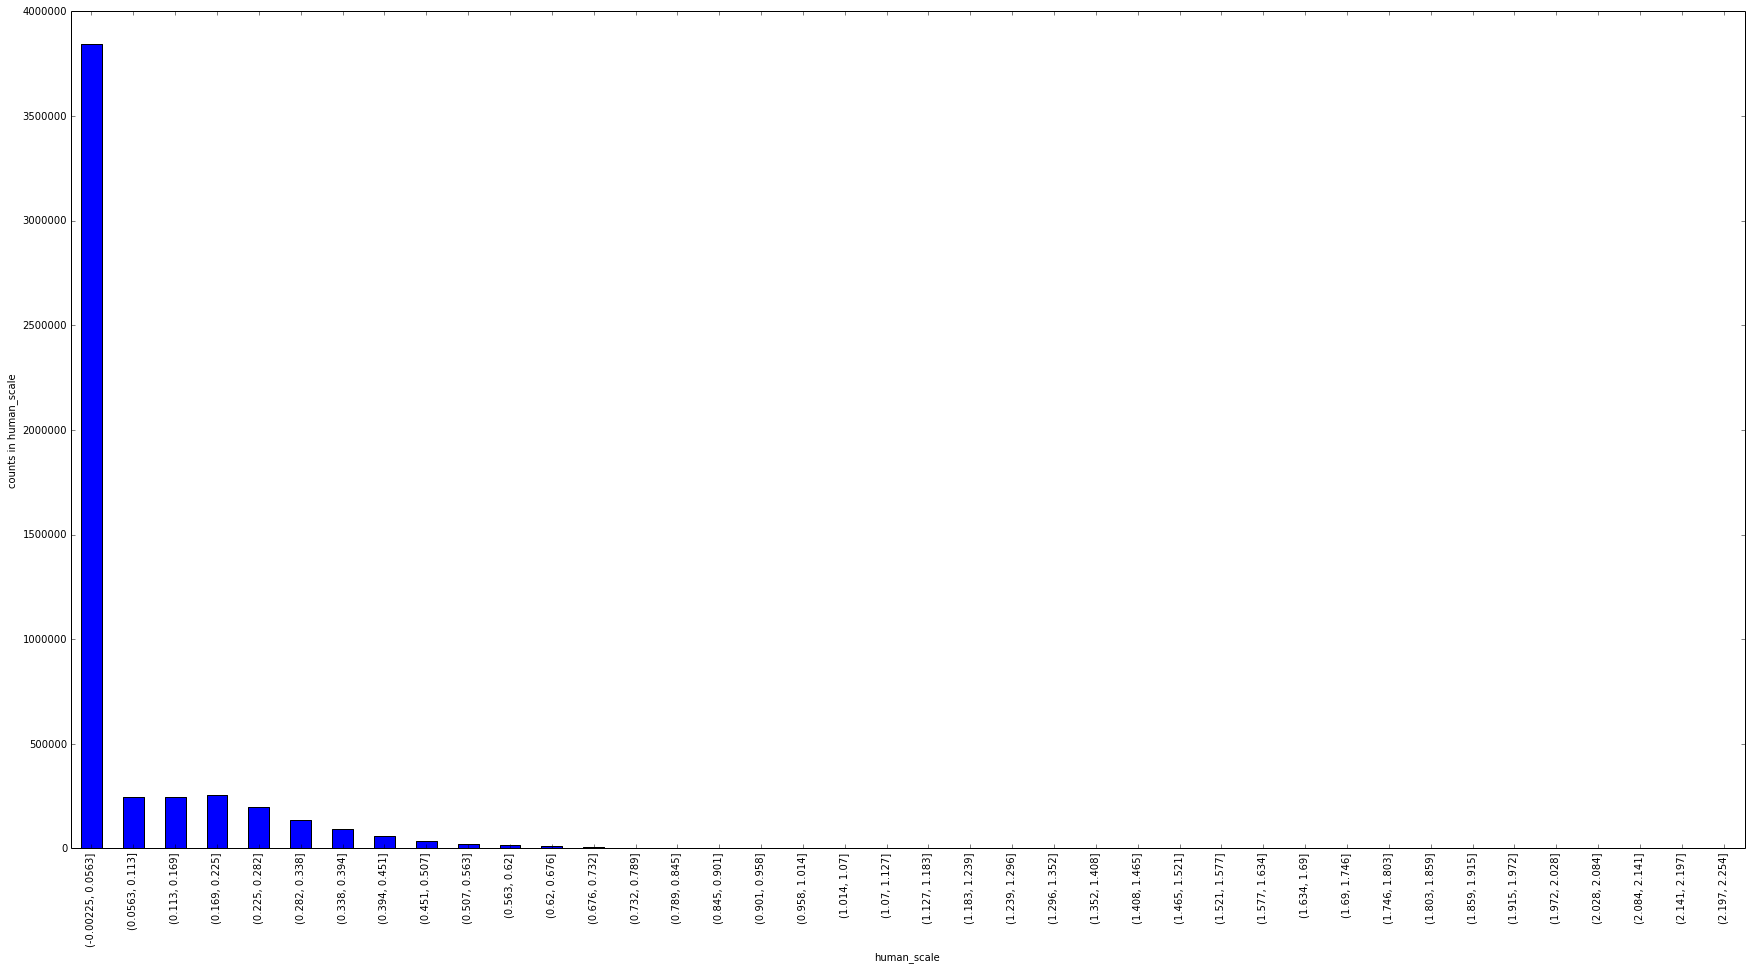

In [59]:
plot_data_cut(photo_data, 'human_scale', 40)

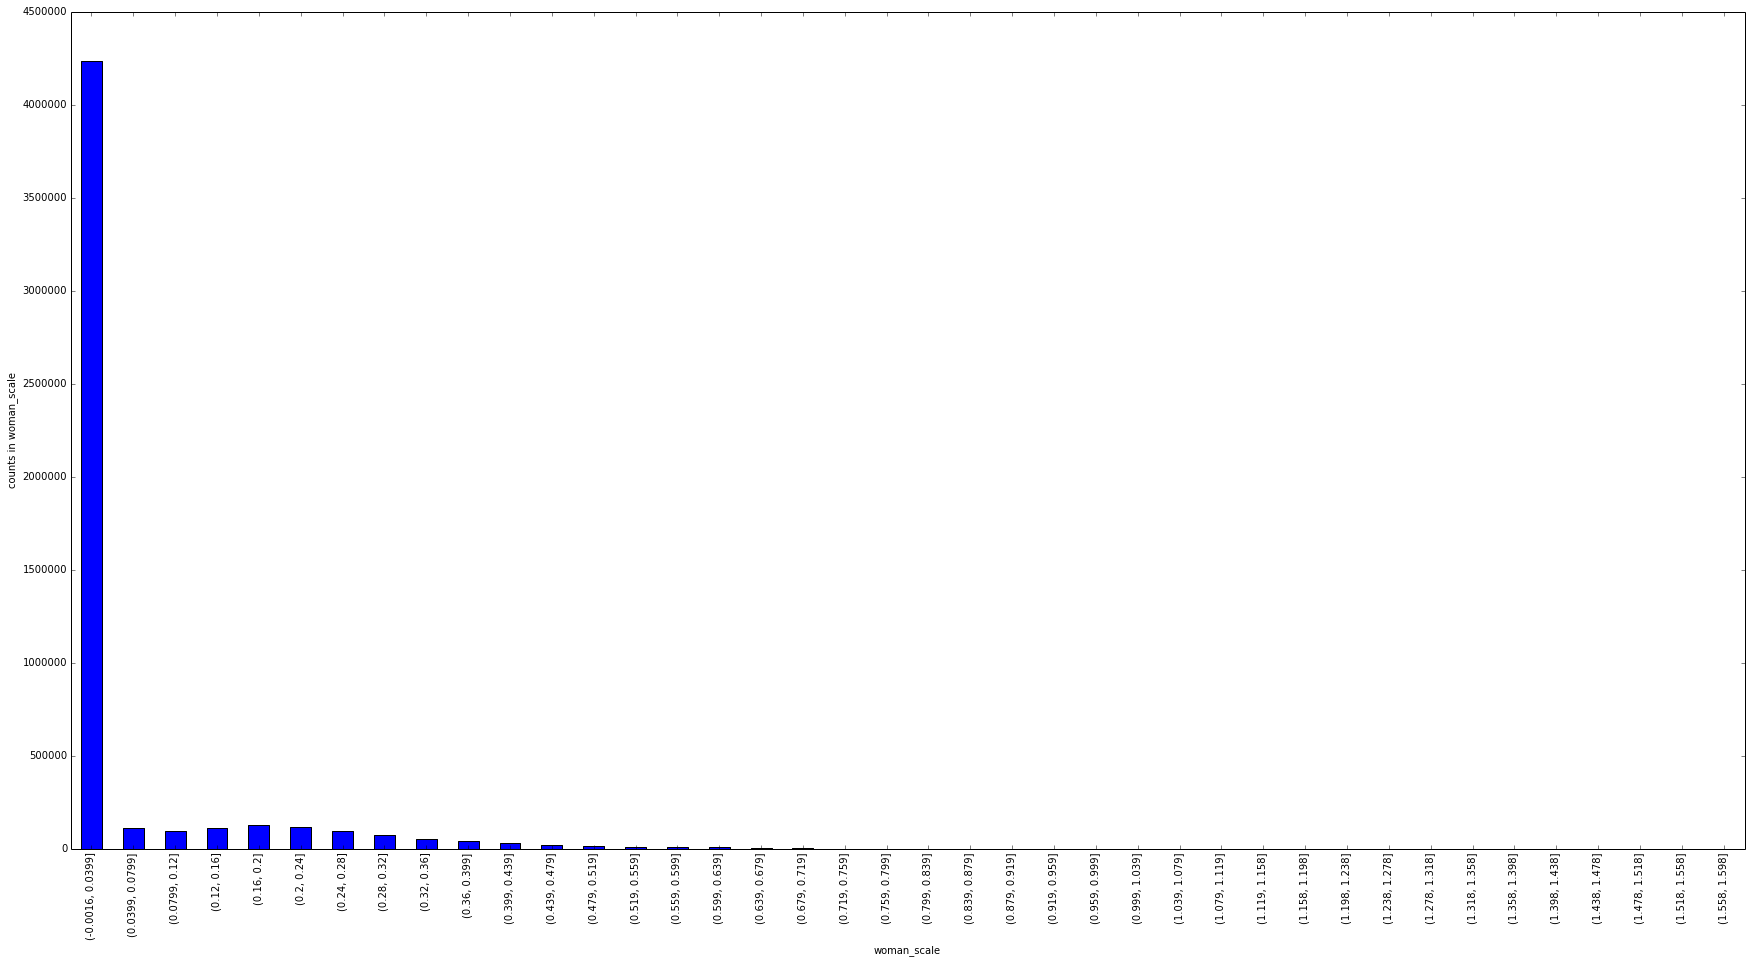

In [60]:
plot_data_cut(photo_data, 'woman_scale', 40)

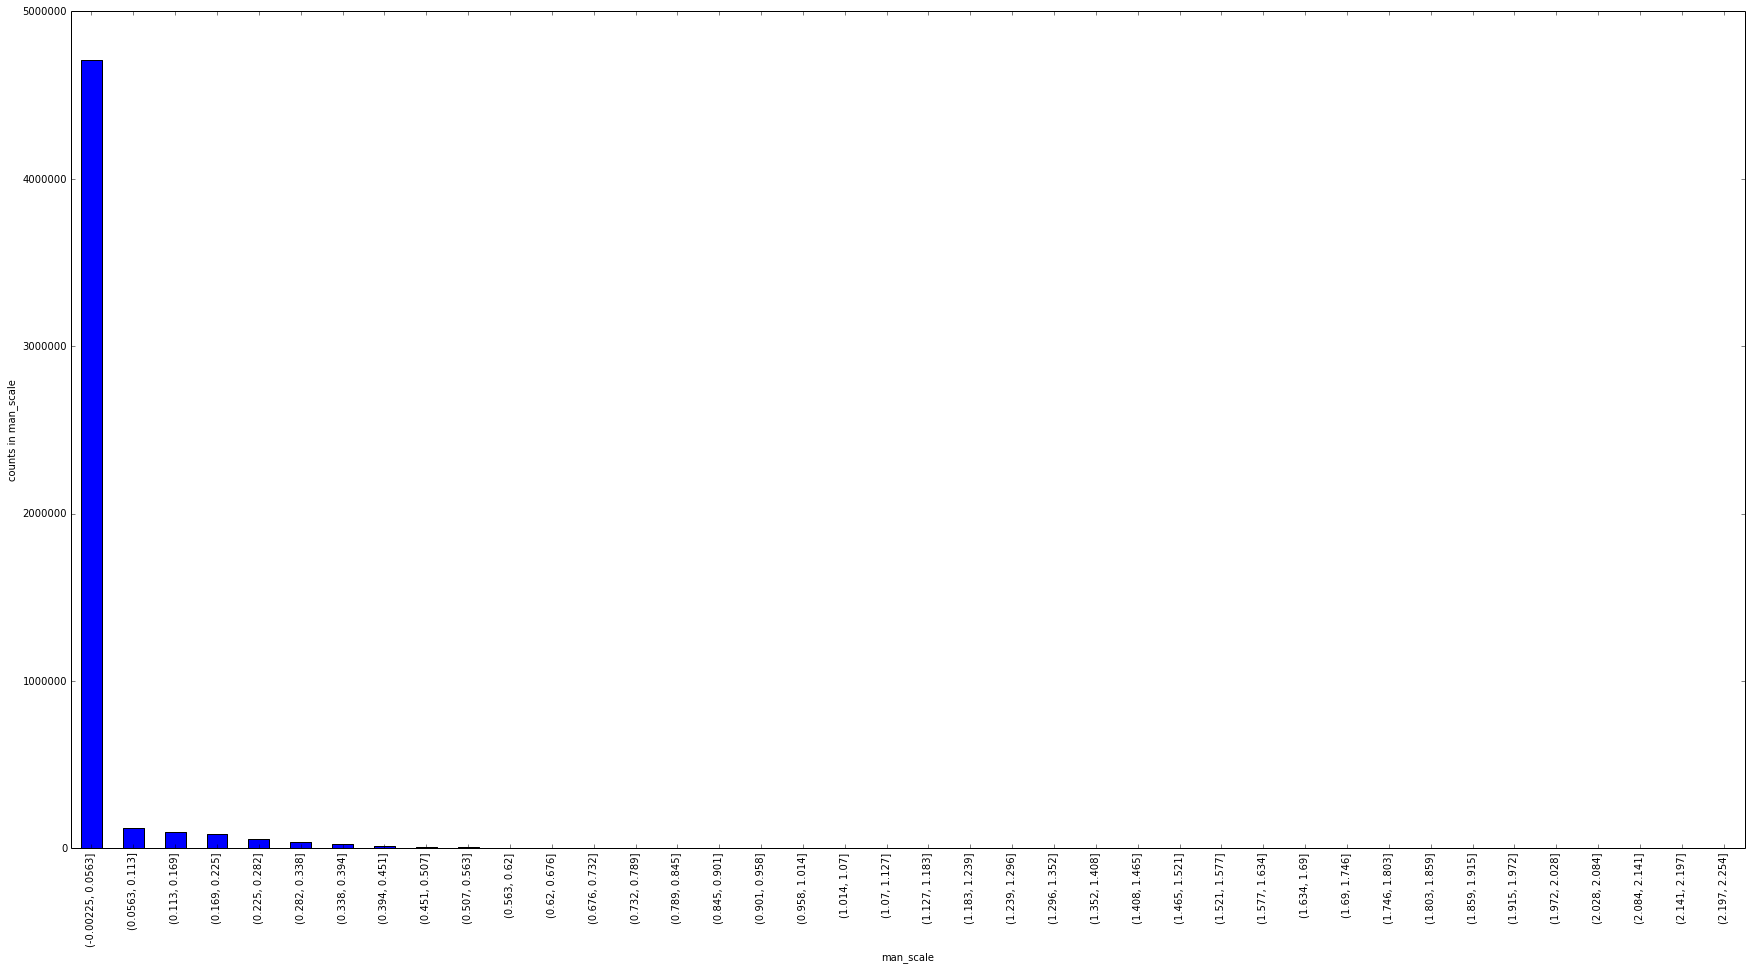

In [61]:
plot_data_cut(photo_data, 'man_scale', 40)

In [67]:
user_item_data.columns.values

array(['user_id', 'photo_id', 'time', 'duration_time'], dtype=object)

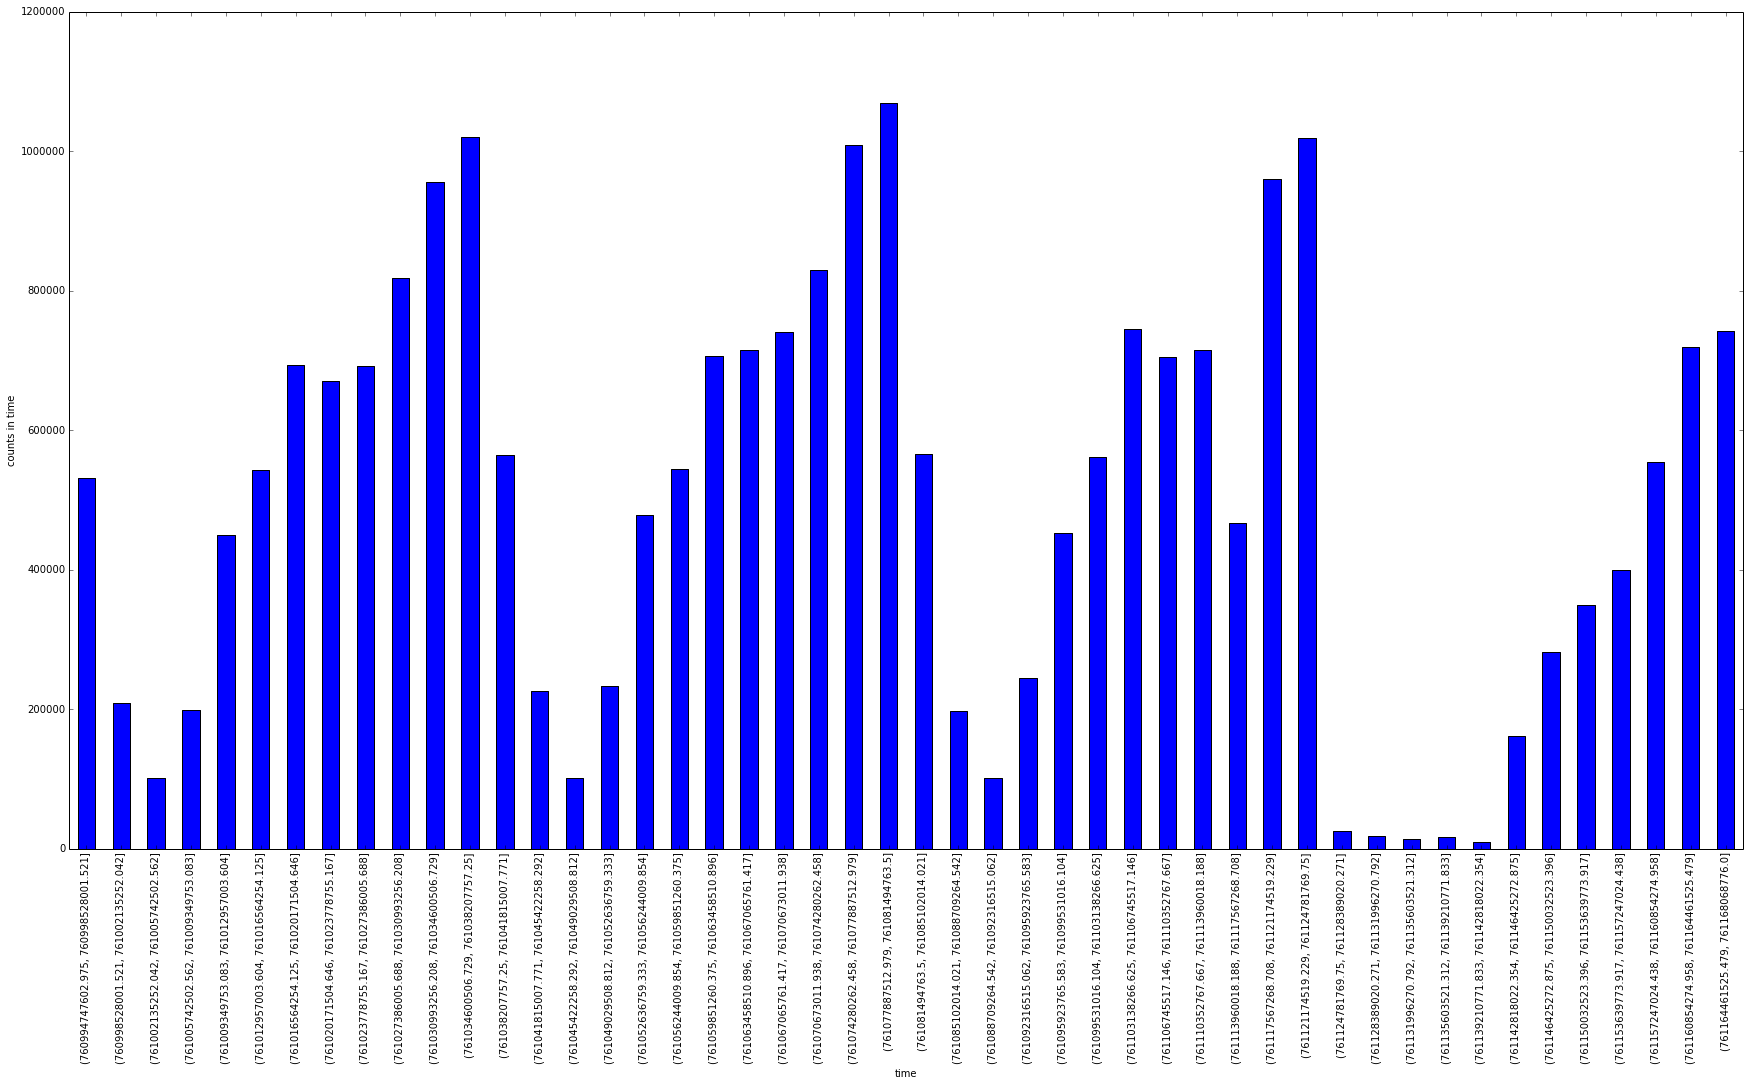

In [68]:
plot_data_cut(user_item_data, 'time', 48)

In [69]:
user_item_data['datetime'] = pd.to_datetime(user_item_data['time']-8*3600*1000, utc=True, unit='ms')761124966356

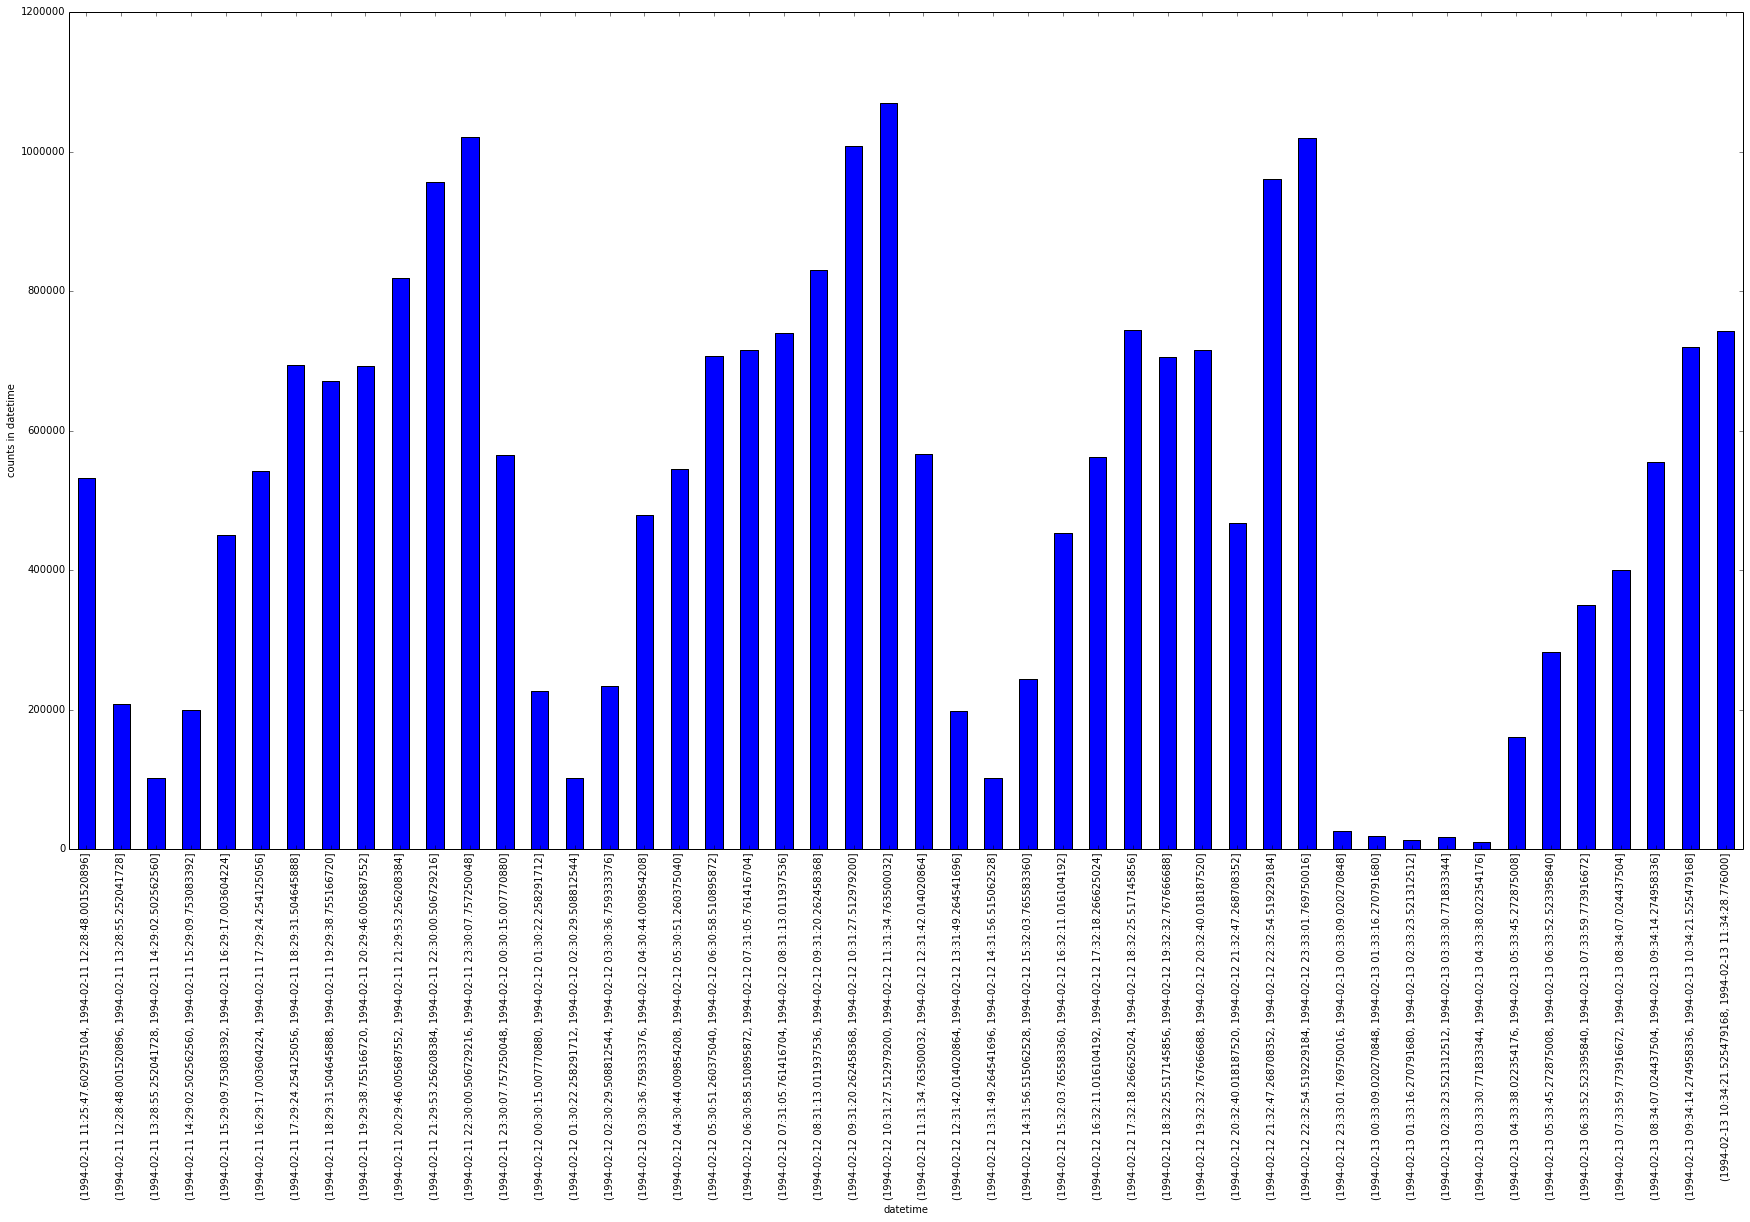

In [70]:
plot_data_cut(user_item_data, 'datetime', 48)

In [71]:
num_train, num_test = user_item_train.shape[0], user_item_test.shape[0]761124966356

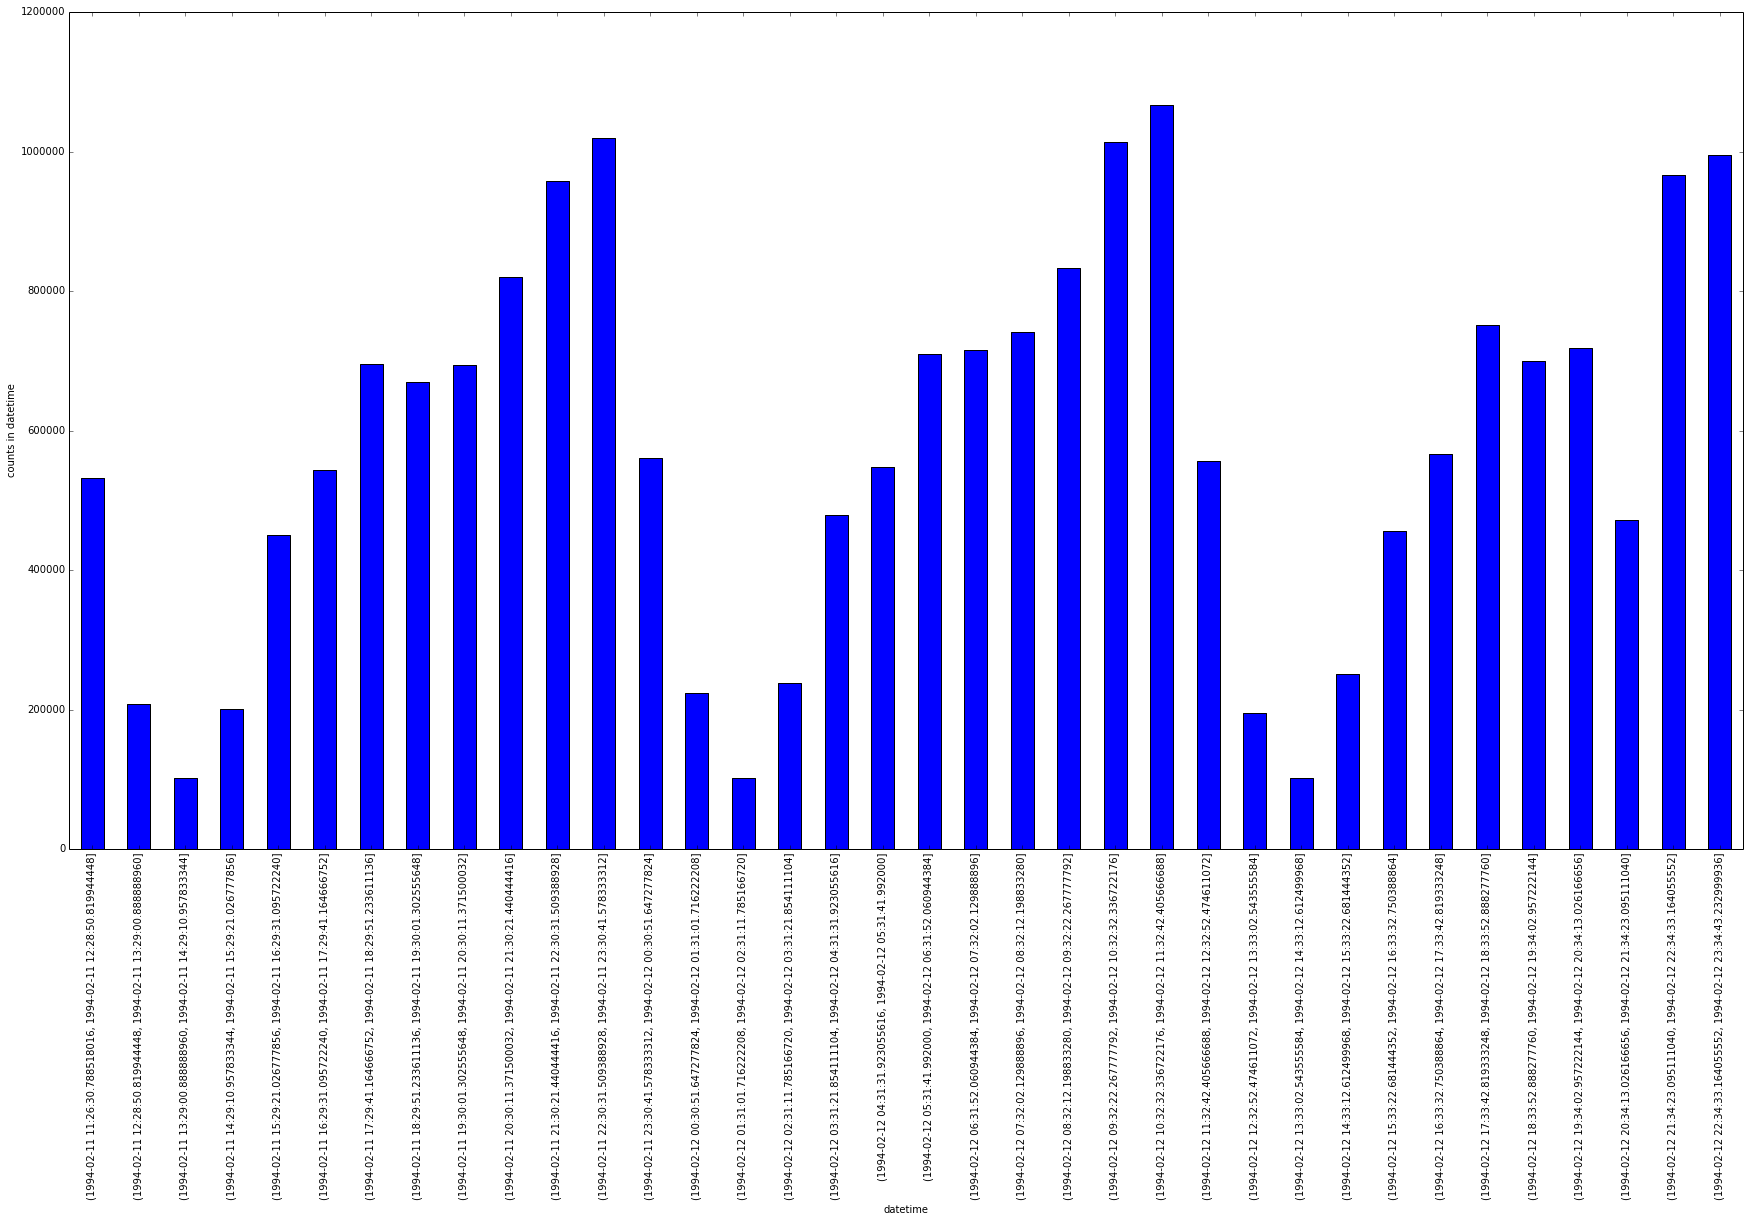

In [72]:
plot_data_cut(user_item_data.iloc[:num_train], 'datetime', 36)

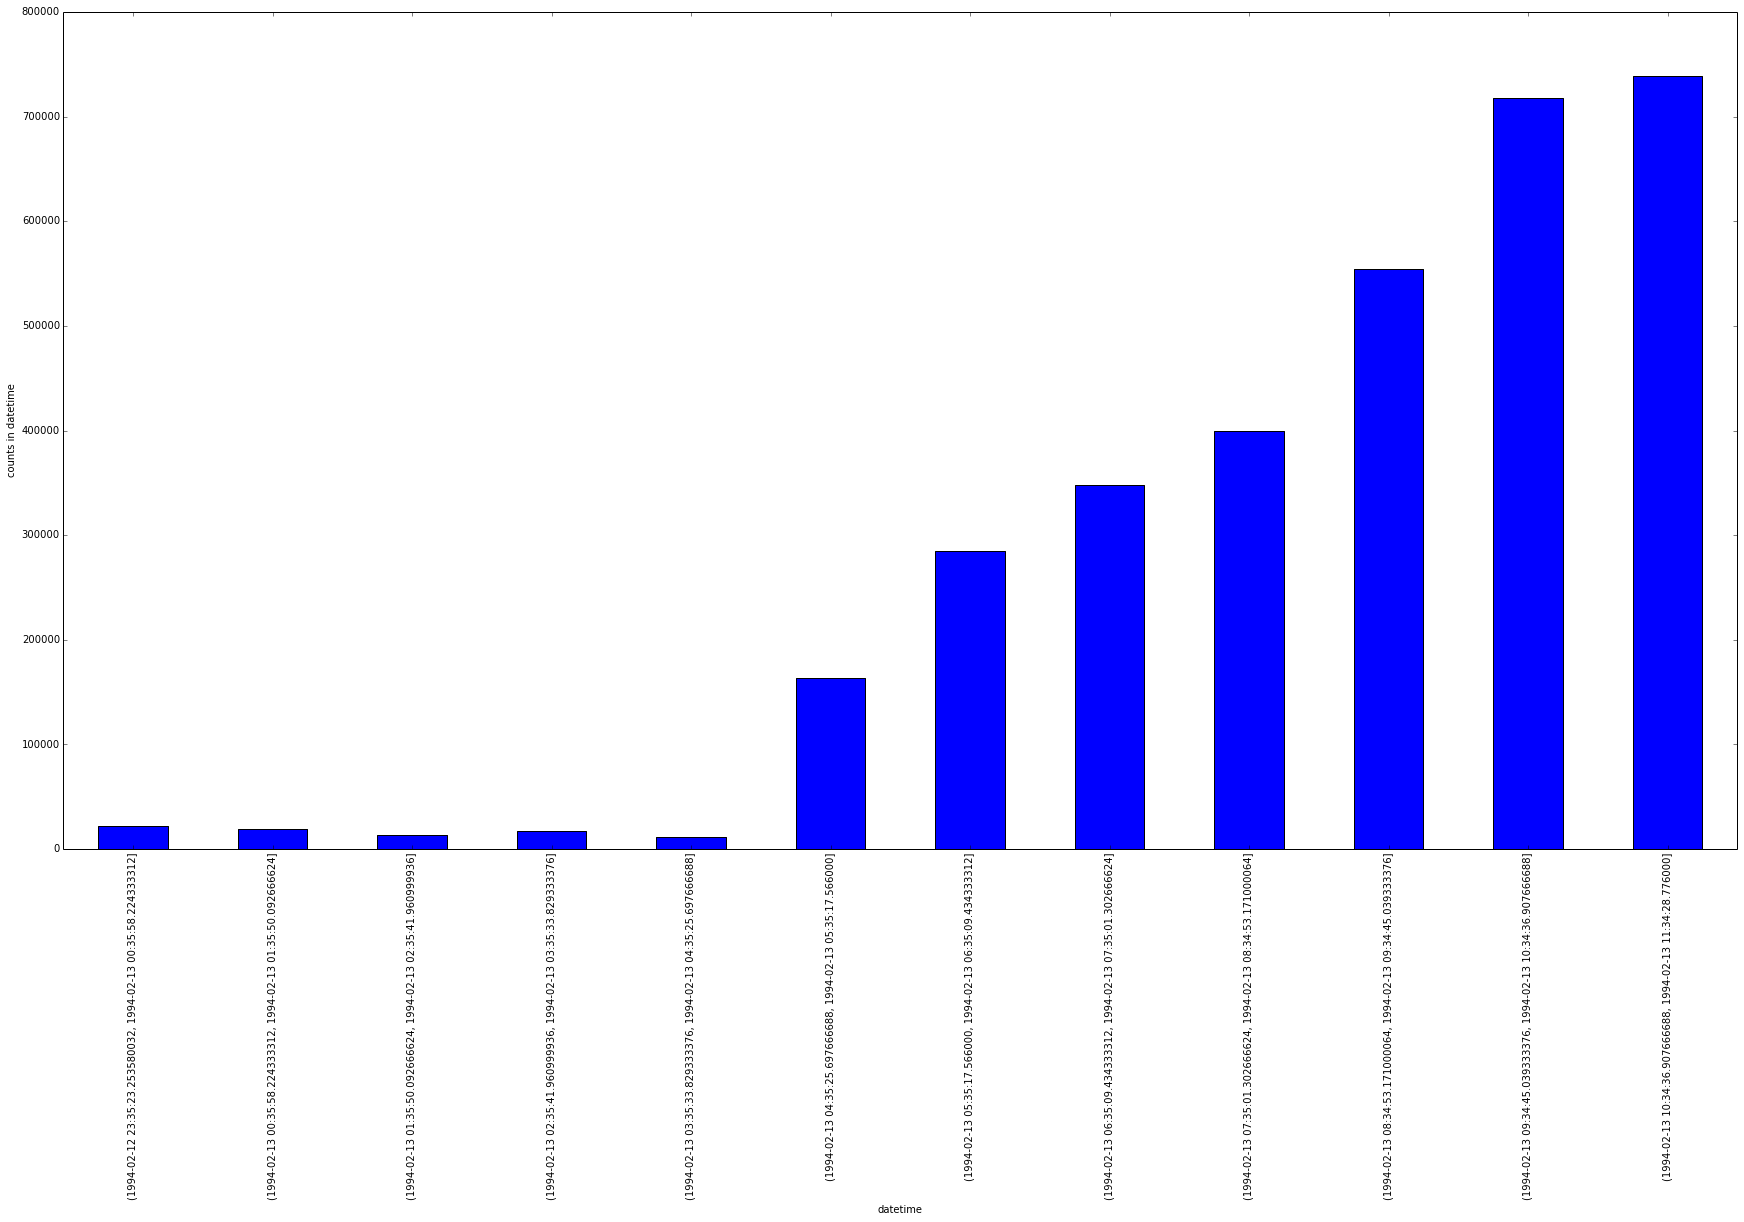

In [73]:
plot_data_cut(user_item_data.iloc[num_train:], 'datetime', 12)

In [74]:
user_item_data.head()

,user_id,photo_id,time,duration_time,datetime
0,1637,6484142,761036604603,11,1994-02-11 23:03:24.603
1,1637,4647664,761035501863,11,1994-02-11 22:45:01.863
2,1637,4994626,761036933553,10,1994-02-11 23:08:53.553
3,1637,4416881,761119247892,9,1994-02-12 22:00:47.892
4,1637,2597756,761119421332,11,1994-02-12 22:03:41.332


In [112]:
user_item_data.iloc[:num_train]['datetime'].min()

Timestamp('1994-02-11 11:28:40.751000')

In [113]:
user_item_data.iloc[:num_train]['datetime'].max()

Timestamp('1994-02-12 23:34:43.233000')

In [114]:
user_item_data.iloc[num_train:]['datetime'].min()

Timestamp('1994-02-12 23:36:06.356000')

In [115]:
user_item_data.iloc[num_train:]['datetime'].max()

Timestamp('1994-02-13 11:34:28.776000')

In [75]:
user_item_data.tail()

,user_id,photo_id,time,duration_time,datetime
3291327,18692,7737173,761157885200,17,1994-02-13 08:44:45.200
3291328,18692,9010845,761165110089,17,1994-02-13 10:45:10.089
3291329,18692,8965384,761165002966,13,1994-02-13 10:43:22.966
3291330,18692,8327003,761167172811,11,1994-02-13 11:19:32.811
3291331,18692,7569417,761157853199,11,1994-02-13 08:44:13.199


In [76]:
datetime.time(1,0,0) < user_item_data.iloc[0]['datetime'].time() < datetime.time(5, 0, 0)

False

In [77]:
import datetime
periods_24 = []
for i in range(24):
    periods_24.append(datetime.time(i,0,0))

def datetime_discretization(dt):
    global periods_24
    t = dt.time()
    if periods_24[0] <= t < periods_24[1]:
        return 0
    elif periods_24[1] <= t < periods_24[2]:
        return 1
    elif periods_24[2] < t < periods_24[3]:
        return 2
    elif periods_24[3] < t < periods_24[4]:
        return 3
    elif periods_24[4] < t < periods_24[5]:
        return 4
    elif periods_24[5] < t < periods_24[6]:
        return 5
    elif periods_24[6] <= t < periods_24[7]:
        return 6
    elif periods_24[7] <= t < periods_24[8]:
        return 7
    elif periods_24[8] <= t < periods_24[9]:
        return 8
    elif periods_24[9] <= t < periods_24[10]:
        return 9
    elif periods_24[10] <= t < periods_24[11]:
        return 10
    elif periods_24[11] <= t < periods_24[12]:
        return 11
    elif periods_24[12] <= t < periods_24[13]:
        return 12
    elif periods_24[13] <= t < periods_24[14]:
        return 13
    elif periods_24[14] <= t < periods_24[15]:
        return 14
    elif periods_24[15] <= t < periods_24[16]:
        return 15
    elif periods_24[16] <= t < periods_24[17]:
        return 16
    elif periods_24[17] <= t < periods_24[18]:
        return 17
    elif periods_24[18] <= t < periods_24[19]:
        return 18
    elif periods_24[19] <= t < periods_24[20]:
        return 19
    elif periods_24[20] <= t < periods_24[21]:
        return 20
    elif periods_24[21] <= t < periods_24[22]:
        return 21
    elif periods_24[22] <= t < periods_24[23]:
        return 22
    else:
        return 23
    
# period_0_1 = (datetime.time(0,0,0), datetime.time(1,0,0))
# period_5_8 = (datetime.time(1,0,0), datetime.time(2,0,0))
# period_8_12 = (datetime.time(2,0,0), datetime.time(3,0,0))
# period_12_15 = (datetime.time(12,0,0), datetime.time(15,0,0))
# period_15_17 = (datetime.time(15,0,0), datetime.time(17,0,0))
# period_17_23 = (datetime.time(17,0,0), datetime.time(23,0,0))
# period_0_1 = (datetime.time(0,0,0), datetime.time(1,0,0))
# period_23_0 = (datetime.time(23,0,0), datetime.time(0,0,0))


# def datetime_discretization(dt):
#     global period_1_5, period_5_8, period_8_12, period_12_15, period_15_17, period_17_23, period_0_1, period_23_0
#     t = dt.time()
#     if period_1_5[0] < t < period_1_5[1]:
#         return 0
#     elif period_5_8[0] < t < period_5_8[1]:
#         return 1
#     elif period_8_12[0] < t < period_8_12[1]:
#         return 2
#     elif period_12_15[0] < t < period_12_15[1]:
#         return 3
#     elif period_15_17[0] < t < period_15_17[1]:
#         return 4
#     elif period_17_23[0] < t < period_17_23[1]:
#         return 5
#     elif period_0_1[0] < t < period_0_1[1] or period_23_0[0] < t:
#         return 6
    

In [78]:
user_item_data['time_cate'] = user_item_data['datetime'].apply(datetime_discretization)

In [79]:
user_item_data.duration_time.describe()

count    2.414568e+07
mean     1.986848e+01
std      2.747413e+01
min      0.000000e+00
25%      1.100000e+01
50%      1.100000e+01
75%      1.700000e+01
max      3.831000e+03
Name: duration_time, dtype: float64

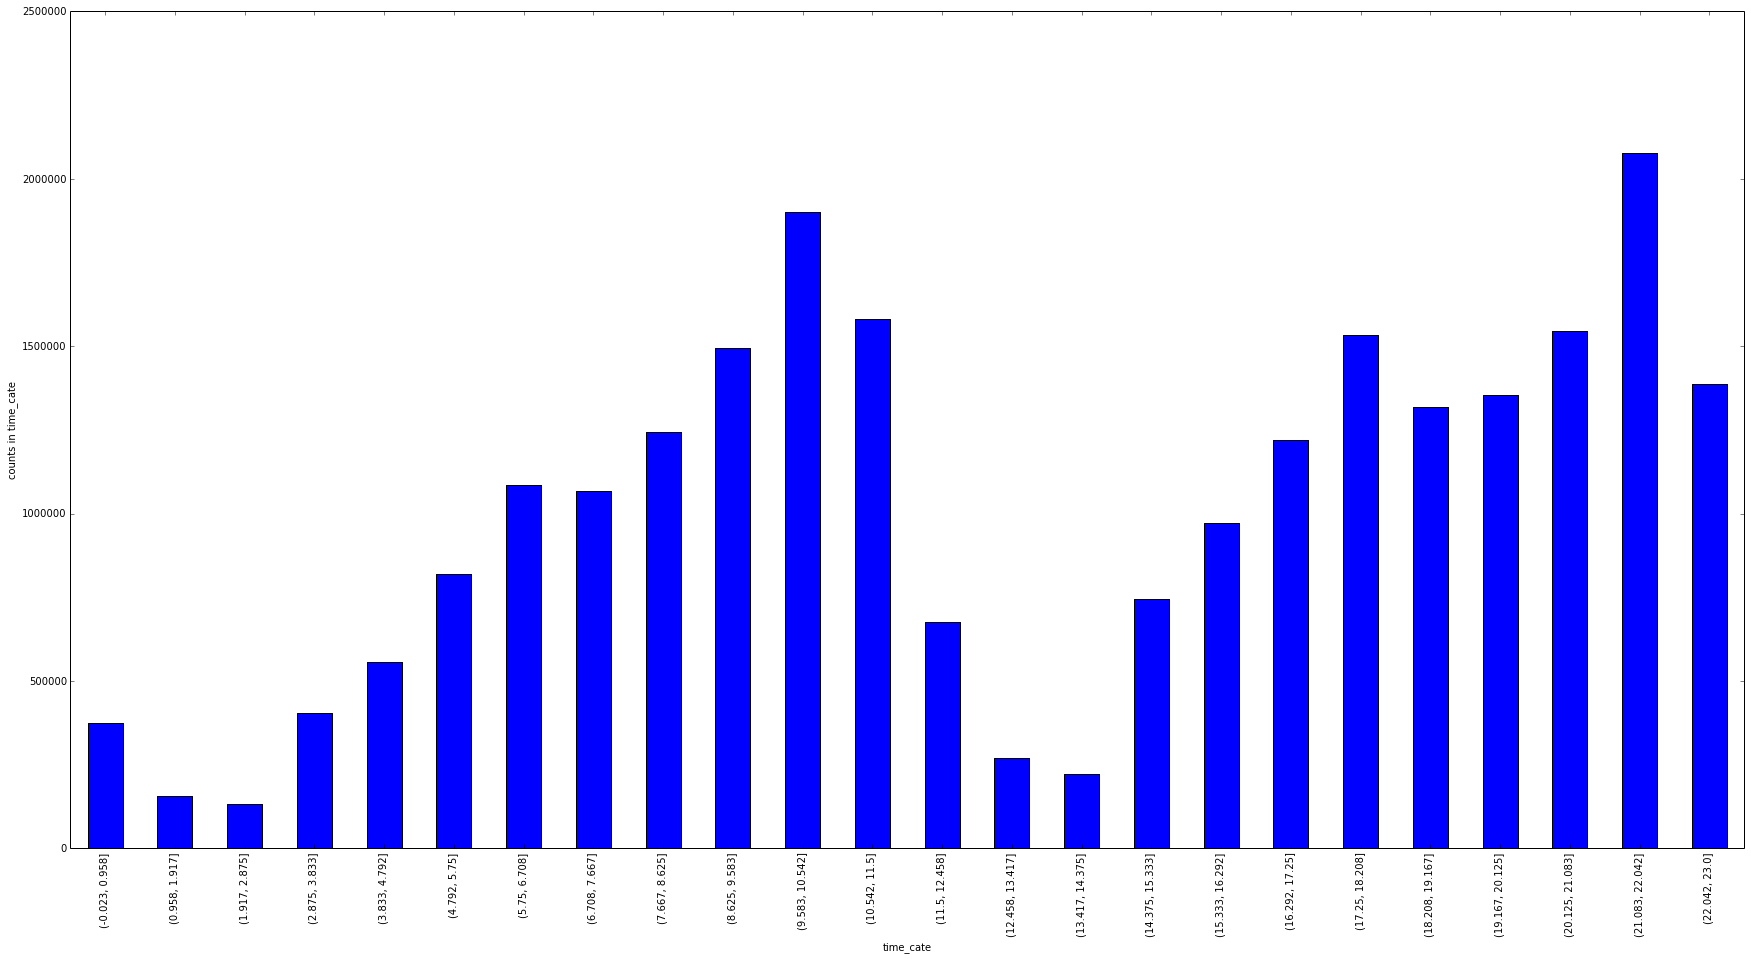

In [80]:
plot_data_cut(user_item_data, 'time_cate', 24)

In [81]:
user_item_data.groupby(['user_id']).head()

,user_id,photo_id,time,duration_time,datetime,time_cate
0,1637,6484142,761036604603,11,1994-02-11 23:03:24.603,23
1,1637,4647664,761035501863,11,1994-02-11 22:45:01.863,22
2,1637,4994626,761036933553,10,1994-02-11 23:08:53.553,23
3,1637,4416881,761119247892,9,1994-02-12 22:00:47.892,22
4,1637,2597756,761119421332,11,1994-02-12 22:03:41.332,22
1736,17470,4178153,761119428358,11,1994-02-12 22:03:48.358,22
1737,17470,1641289,761120053746,11,1994-02-12 22:14:13.746,22
1738,17470,4473798,761073933780,12,1994-02-12 09:25:33.780,9
1739,17470,5842580,761119510556,17,1994-02-12 22:05:10.556,22
1740,17470,7161406,761119595360,11,1994-02-12 22:06:35.360,22


In [82]:
list(photo_data.columns.values)

['photo_id',
 'exposure_num',
 'face_num',
 'man_num',
 'woman_num',
 'man_scale',
 'woman_scale',
 'human_scale',
 'man_avg_age',
 'woman_avg_age',
 'human_avg_age',
 'man_avg_attr',
 'woman_avg_attr',
 'human_avg_attr']

In [83]:
def exposure_num_discretization(exposure_num):
    if 0 < exposure_num and exposure_num <= 10:
        return 0
    elif 10 < exposure_num and exposure_num <= 100:
        return 1
    elif 100 < exposure_num and exposure_num <= 1000:
        return 2
    else:
        return 3
    
def duration_time_discretization(t):
    if 0 < t <= 30:
        return 0
    elif 30 < t <= 60:
        return 1
    elif 60 < t < 300:
        return 2
    else:
        return 3

def face_num_discretization(face_num):
    if face_num == 0:
        return 0
    elif face_num == 1:
        return 1
    elif face_num == 2:
        return 2
    elif face_num == 3:
        return 3
    else:
        return 4

def man_num_discretization(man_num):
    if man_num == 0:
        return 0
    elif man_num == 1:
        return 1
    elif man_num == 2:
        return 2
    elif man_num == 3:
        return 3
    else:
        return 4
    
def woman_num_discretization(woman_num):
    if woman_num == 0:
        return 0
    elif woman_num == 1:
        return 1
    elif woman_num == 2:
        return 2
    elif woman_num == 3:
        return 3
    else:
        return 4

def human_avg_age_discretization(human_age):
    if human_age == 0:
        return 0
    elif 0 < human_age and human_age <= 12:
        return 1
    elif 12 < human_age and human_age <= 18:
        return 2
    elif 18 < human_age and human_age <= 24:
        return 3
    elif 24 < human_age and human_age <= 32:
        return 4
    elif human_age > 32:
        return 5

def woman_avg_age_discretization(woman_age):
    if woman_age == 0:
        return 0
    elif 0 < woman_age and woman_age <= 12:
        return 1
    elif 12 < woman_age and woman_age <= 18:
        return 2
    elif 18 < woman_age and woman_age <= 24:
        return 3
    elif 24 < woman_age and woman_age <= 28:
        return 4
    elif woman_age > 28:
        return 5

def man_avg_age_discretization(man_age):
    if man_age == 0:
        return 0
    elif 0 < man_age and man_age <= 12:
        return 1
    elif 12 < man_age and man_age <= 18:
        return 2
    elif 18 < man_age and man_age <= 24:
        return 3
    elif 24 < man_age and man_age <= 40:
        return 4
    elif woman_age > 40:
        return 5
    
def human_avg_attr_discretization(human_attr):
    if human_attr == 0:
        return 0
    elif 0 < human_attr and human_attr <= 50:
        return 1
    elif 50 < human_attr and human_attr <= 60:
        return 2
    elif 60 < human_attr and human_attr <= 70:
        return 3
    elif 70 < human_attr and human_attr <= 80:
        return 4
    elif human_attr > 80:
        return 5

def man_avg_attr_discretization(man_attr):
    if man_attr == 0:
        return 0
    elif 0 < man_attr and man_attr <= 50:
        return 1
    elif 50 < man_attr and man_attr <= 60:
        return 2
    elif 60 < man_attr and man_attr <= 70:
        return 3
    elif 70 < man_attr and man_attr <= 80:
        return 4
    elif man_attr > 80:
        return 5
    
def woman_avg_attr_discretization(woman_attr):
    if woman_attr == 0:
        return 0
    elif 0 < woman_attr and woman_attr <= 50:
        return 1
    elif 50 < woman_attr and woman_attr <= 60:
        return 2
    elif 60 < woman_attr and woman_attr <= 70:
        return 3
    elif 70 < woman_attr and woman_attr <= 80:
        return 4
    elif woman_attr > 80:
        return 5
    
def human_scale_discretization(human_scale):
    if human_scale == 0:
        return 0
    elif 0 < human_scale and human_scale <= 0.1:
        return 1
    elif 0.1 < human_scale and human_scale <= 0.2:
        return 2
    elif 0.2 < human_scale and human_scale <= 0.3:
        return 3
    elif 0.3 < human_scale and human_scale <= 0.4:
        return 4
    elif 0.4 < human_scale and human_scale <= 0.5:
        return 5
    elif 0.5 < human_scale and human_scale <= 0.6:
        return 6
    else:
        return 7

def man_scale_discretization(man_scale):
    if man_scale == 0:
        return 0
    elif 0 < man_scale and man_scale <= 0.1:
        return 1
    elif 0.1 < man_scale and man_scale <= 0.2:
        return 2
    elif 0.2 < man_scale and man_scale <= 0.3:
        return 3
    elif 0.3 < man_scale and man_scale <= 0.4:
        return 4
    elif 0.4 < man_scale and man_scale <= 0.5:
        return 5
    elif 0.5 < man_scale and man_scale <= 0.6:
        return 6
    else:
        return 7

def woman_scale_discretization(woman_scale):
    if woman_scale == 0:
        return 0
    elif 0 < woman_scale and woman_scale <= 0.1:
        return 1
    elif 0.1 < woman_scale and woman_scale <= 0.2:
        return 2
    elif 0.2 < woman_scale and woman_scale <= 0.3:
        return 3
    elif 0.3 < woman_scale and woman_scale <= 0.4:
        return 4
    elif 0.4 < woman_scale and woman_scale <= 0.5:
        return 5
    elif 0.5 < woman_scale and woman_scale <= 0.6:
        return 6
    else:
        return 7


In [84]:
photo_data['have_face_cate'] = photo_data['face_num'].apply(lambda x: x >= 1)

In [85]:
photo_data.head()

,photo_id,exposure_num,face_num,man_num,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,have_face_cate
0,6484142,13,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
1,4647664,2,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
2,4994626,34,3.0,3.0,0.0,0.3959,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333,True
3,4416881,1,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
4,2597756,2,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False


In [86]:
# pd.get_dummies(photo_data)

In [87]:
user_item_train = pd.merge(user_item_train, photo_data,
                          how='left',
                          on=['photo_id'])

In [88]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,have_face_cate
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.3959,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333,True
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False


In [89]:
# user_item_train[(user_item_train['user_id'] == 35273) & (user_item_train['click'] == 1)]

In [90]:
# user_item_train['user_id'].groupby(user_item_train['user_id']).transform('count').drop_duplicates()

In [91]:
# user_item_train['like'].groupby(user_item_train['user_id']).transform('sum').drop_duplicates()

# 点击率相关特征平滑
点击率、喜爱率、偏爱率的统计，如果是直接用点击数比总数，对于CTR来说往往会有偏差，比如一个用户看了一个视频，而且点了，那么他的点击率就是1，但是一个用户看了100个视频，点了80个，点击率是0.8，显然，我们不能说前者就是倾向于更爱点击了，因此我们需要做平滑处理！
雅虎一篇论文做了关于CTR特征平滑的方法，$\frac{C + \alpha}{I + \alpha + \beta}$, 关键是找到分子分母合适的平滑参数。I 代表曝光次数 impressions， C 代表点击次数 clicks

## 先验概率后验概率似然函数
 - [详解最大似然估计（MLE）、最大后验概率估计（MAP），以及贝叶斯公式的理解](https://blog.csdn.net/u011508640/article/details/72815981)
 - [先验分布、后验分布、似然估计这几个概念是什么意思，它们之间的关系是什么？](https://www.zhihu.com/question/24261751)
 

## 概率中的PDF，PMF，CDF
 - [概率中的PDF，PMF，CDF](https://blog.csdn.net/wzgbm/article/details/51680540)
 
## beta 分布、二项分布和贝叶斯推断
 beta 分布这里的应用其实是概率的概率分布，这个概率是先验概率 $p(\theta)$ 的分布假设服从 beta 分布。比如这里的视频点击概率，一个视频被点击的概率，我们先验的认为他服从 beta 分布。
 $$
 \beta(a,b) = \frac{\theta^{a-1} (1 - \theta)^{b-1}}{B(a,b)} \varpropto \theta^{a-1} (1 - \theta)^{b-1}
 $$
 
 二项分布即重复n次独立的伯努利试验。在每次试验中只有两种可能的结果，而且两种结果发生与否互相对立，并且相互独立，与其它各次试验结果无关，事件发生与否的概率在每一次独立试验中都保持不变，则这一系列试验总称为n重伯努利实验，当试验次数为1时，二项分布服从0-1分布。 而在这里，我们的视频曝光次数可以看成 n 次独立的伯努利试验，形成二项分布。二项分布的似然函数（可以认为是条件概率）：
 $$
 p(data|\theta) \varpropto \theta^C (1 - \theta)^{I-C} \\
 C = \sum_{i}{X_i}
 $$
 
 注意前面的都是人为属于概率的范畴，因为是我们假设知道概率分布，得到分布函数。后面的推断使用的是统计，反过来的方法，通过已知的假设和观测的统计数据，来计算相关参数！
 
 贝叶斯推断，贝叶斯估计的目的就是要在给定数据的情况下求出θ的值，所以我们的目的是求解如下后验概率：
 $$
 p(\theta|data) = \frac{p(data|\theta)p(\theta)}{p(data)} \varpropto p(data|\theta)p(\theta)
 $$
 以上公式就是我们常说的，**后验分布 正比于 似然函数与先验分布的乘积**. 
 
 共轭先验, 现在有了二项分布的似然函数和beta分布，将beta分布代进贝叶斯估计中的P(θ)中，将二项分布的似然函数代入P(data|θ)中，可以得到:
 $$
 p(\theta|data) \varpropto \theta^C (1 - \theta)^{I-C} \theta^{a-1} (1 - \theta)^{b-1} = \theta^{a+C-1} (1-\theta)^{b+I-C-1}
 $$
 最后的贝叶斯后验概率分布也是一个beta分布的形式，$a^{'}=a+C,b^{'}=b+I−C$ 那这里根据 beta 分布的均值 $\mu = \frac{a}{a+b}$, 可以算出 后验概率的均值 $\frac{a^{'}}{a^{'}+b^{'}} = \frac{C+a}{I+a+b}$. 而实际上，均值就是我们需要的概率最大的解，概率统计中我们学过，通过求导，取导数为0的地方即可。这个均值其实就是我们需要的点击率平滑后的值。也就是说，我们可以根据一系列的观察到的点击率 $\theta$，来估计出参数 $\alpha \beta$.
 
 现在由于我们只是假定了先验概率的分布式beta分布，但是$\theta$到底应该取哪一个值，目前需要通过其他方法学习或者推断出来，这里我们就会用到贝叶斯条件概率和极大似然法，条件概率就是执果索因，这个二项分布似然函数就是我们要最大化的地方，这就是为啥叫极大似然方法，就是我们断定在某种先验概率$\theta$（原因）给定的时候，出现这样的观测数据集的概率最大化，找到那个最大的先验概率，我们就认为找到了先验取值，从而找到了参数。对于如何找到最大似然，就是优化目标函数的问题了，可以最小二成，牛顿、梯度下降法等。 
 
 这里使用贝叶斯推断和极大似然的方法和 逻辑斯特回归模型的对数极大似然是一样的道理。

 - [如何通俗理解beta分布](https://www.zhihu.com/question/30269898)
 - [ctr平滑](http://d0evi1.com/ctr-smooth/)
 - [转化率（CTR）预测的贝叶斯平滑](https://blog.csdn.net/jinping_shi/article/details/78334362)
 - [CTR预估中的贝叶斯平滑方法（一）](https://blog.csdn.net/dengxing1234/article/details/77965536)
 - [【实践】CTR预估中的贝叶斯平滑方法（二）](https://blog.csdn.net/dengxing1234/article/details/77965657)
 - [Inferring probabilities with a Beta prior, a third example of Bayesian calculations](http://chrisstrelioff.ws/sandbox/2014/12/11/inferring_probabilities_with_a_beta_prior_a_third_example_of_bayesian_calculations.html)
 - [Introduction to Bayesian Inference](https://www.datascience.com/blog/introduction-to-bayesian-inference-learn-data-science-tutorials)
 - [第一届腾讯社交广告高校算法大赛(全国14名)](https://github.com/freelzy/Tencent_Social_Ads)
 - [yahoo-ctr-smoothing-paper](http://www.cs.cmu.edu/~xuerui/papers/ctr.pdf)

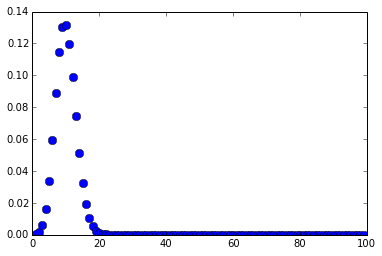

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

n, p = 100, 0.1
x = np.arange(1,100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
plt.show()

In [93]:
#!/usr/bin/python
# coding=utf-8

import numpy
import random
import scipy.special as special

class BayesianSmoothing(object):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def sample(self, alpha, beta, num, imp_upperbound):
        sample = numpy.random.beta(alpha, beta, num)
        print(sample)
        I = []
        C = []
        for clk_rt in sample:
            imp = imp_upperbound
            clk = imp * clk_rt
            I.append(imp)
            C.append(clk)
        return I, C

    def update(self, imps, clks, iter_num, epsilon):
        for i in range(iter_num):
            new_alpha, new_beta = self.__fixed_point_iteration(imps, clks, self.alpha, self.beta)
            if abs(new_alpha-self.alpha)<epsilon and abs(new_beta-self.beta)<epsilon:
                break
            self.alpha = new_alpha
            self.beta = new_beta

    def __fixed_point_iteration(self, imps, clks, alpha, beta):
        numerator_alpha = 0.0
        numerator_beta = 0.0
        denominator = 0.0

        for i in range(len(imps)):
            numerator_alpha += (special.digamma(clks[i]+alpha) - special.digamma(alpha))
            numerator_beta += (special.digamma(imps[i]-clks[i]+beta) - special.digamma(beta))
            denominator += (special.digamma(imps[i]+alpha+beta) - special.digamma(alpha+beta))

        return alpha*(numerator_alpha/denominator), beta*(numerator_beta/denominator)

def main():
    bs = BayesianSmoothing(1, 1)
    I, C = bs.sample(500, 500, 10, 1000)
    print(I, C)
    bs.update(I, C, 1000, 0.0000000001)
    print(bs.alpha, bs.beta)
    ctr = []
    for i in range(len(I)):
        ctr.append((C[i]+bs.alpha)/(I[i]+bs.alpha+bs.beta))
    print(ctr)

if __name__ == '__main__':
    main()

[0.49892533 0.49048593 0.49622683 0.54352011 0.49151314 0.46144346
 0.50099465 0.48654853 0.48550874 0.49840124]
([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], [498.9253341855768, 490.48592541621423, 496.2268250936933, 543.5201089443015, 491.5131427354002, 461.44345937207856, 500.994652201342, 486.54853086963067, 485.5087366926983, 498.4012376164819])
(74.26560471705828, 75.64813219758001)
[0.4984642938874508, 0.4911251270452435, 0.49611758821270696, 0.5372452679093613, 0.4920184265043335, 0.46586891424265525, 0.5002638358438044, 0.4877010488555629, 0.48679681217801674, 0.4980085235524507]


In [94]:
user_item_train['datetime'] = pd.to_datetime(user_item_train['time']-8*3600*1000, utc=True, unit='ms')

In [95]:
user_item_train['time_cate'] = user_item_train['datetime'].apply(datetime_discretization)

In [96]:
user_item_train.head(10)

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,have_face_cate,datetime,time_cate
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False,1994-02-11 23:03:24.603,23
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False,1994-02-11 22:45:01.863,22
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333,True,1994-02-11 23:08:53.553,23
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False,1994-02-12 22:00:47.892,22
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False,1994-02-12 22:03:41.332,22
5,1637,4977481,1,0,0,761034690620,7,11,155,3.0,...,0.0103,27.000000,0.0,27.000000,51.666667,0.0,51.666667,True,1994-02-11 22:31:30.620,22
6,1637,5089000,0,0,0,761035822185,0,10,852,1.0,...,0.0384,0.000000,22.0,22.000000,0.000000,84.0,84.000000,True,1994-02-11 22:50:22.185,22
7,1637,693195,0,0,0,761035023775,0,11,55,2.0,...,0.0256,27.000000,27.0,27.000000,50.000000,51.0,50.500000,True,1994-02-11 22:37:03.775,22
8,1637,163901,1,0,0,761034417190,10,17,265,2.0,...,0.0192,21.000000,27.0,24.000000,56.000000,48.0,52.000000,True,1994-02-11 22:26:57.190,22
9,1637,6472236,0,0,0,761035670110,0,7,1,0.0,...,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False,1994-02-11 22:47:50.110,22


In [97]:
user_item_train['hour_click_ratio'] = user_item_train.set_index(['user_id', 'time_cate']).groupby(level=['user_id', 'time_cate'])['click'].transform('mean').values

In [98]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,have_face_cate,datetime,time_cate,hour_click_ratio
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False,1994-02-11 23:03:24.603,23,0.209913
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False,1994-02-11 22:45:01.863,22,0.212898
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,26.333333,0.0,26.333333,48.333333,0.0,48.333333,True,1994-02-11 23:08:53.553,23,0.209913
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False,1994-02-12 22:00:47.892,22,0.212898
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,False,1994-02-12 22:03:41.332,22,0.212898


In [109]:
user_item_train[user_item_train['user_id'] == 29999]['time_cate'].unique()

array([22,  5, 10, 21, 17])

In [100]:
user_item_train[user_item_train['user_id'] == 29999]

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,have_face_cate,datetime,time_cate,hour_click_ratio
18187,29999,4814547,1,0,0,761122246230,13,32,299,1.0,...,30.000000,0.0,30.000000,50.0,0.0,50.0,True,1994-02-12 22:50:46.230,22,0.256410
18188,29999,5250283,0,0,0,761061513171,0,57,87,1.0,...,0.000000,25.0,25.000000,0.0,64.0,64.0,True,1994-02-12 05:58:33.171,5,0.413580
18189,29999,7239783,1,0,0,761060374541,75,57,547,1.0,...,28.000000,0.0,28.000000,50.0,0.0,50.0,True,1994-02-12 05:39:34.541,5,0.413580
18190,29999,6531515,0,0,0,761061283180,0,10,112,2.0,...,29.000000,0.0,29.000000,51.5,0.0,51.5,True,1994-02-12 05:54:43.180,5,0.413580
18191,29999,4035306,0,0,0,761122246230,0,11,1,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,False,1994-02-12 22:50:46.230,22,0.256410
18192,29999,770831,0,0,0,761060735662,0,17,1206,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,False,1994-02-12 05:45:35.662,5,0.413580
18193,29999,1705495,0,0,0,761061122157,0,55,71,1.0,...,0.000000,27.0,27.000000,0.0,57.0,57.0,True,1994-02-12 05:52:02.157,5,0.413580
18194,29999,3293013,0,0,0,761122246230,0,11,96,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,False,1994-02-12 22:50:46.230,22,0.256410
18195,29999,4252658,1,0,0,761060640758,13,11,219,1.0,...,29.000000,0.0,29.000000,43.0,0.0,43.0,True,1994-02-12 05:44:00.758,5,0.413580
18196,29999,1641811,1,0,0,761060640758,7,11,29,1.0,...,0.000000,28.0,28.000000,0.0,48.0,48.0,True,1994-02-12 05:44:00.758,5,0.413580


In [101]:
user_item_test.head()

,user_id,photo_id,time,duration_time
0,29999,8154819,761158905921,17
1,29999,8374672,761163438550,9
2,29999,7987126,761143659968,11
3,29999,7912672,761159000400,17
4,29999,9062638,761163738888,11


In [102]:
user_item_test['datetime'] = pd.to_datetime(user_item_test['time']-8*3600*1000, utc=True, unit='ms')

In [103]:
user_item_test['time_cate'] = user_item_test['datetime'].apply(datetime_discretization)

In [104]:
user_item_test.head()

,user_id,photo_id,time,duration_time,datetime,time_cate
0,29999,8154819,761158905921,17,1994-02-13 09:01:45.921,9
1,29999,8374672,761163438550,9,1994-02-13 10:17:18.550,10
2,29999,7987126,761143659968,11,1994-02-13 04:47:39.968,4
3,29999,7912672,761159000400,17,1994-02-13 09:03:20.400,9
4,29999,9062638,761163738888,11,1994-02-13 10:22:18.888,10


In [105]:
user_item_test[user_item_test['user_id'] == 29999]['time_cate'].unique()

array([ 9, 10,  4,  5])

In [106]:
user_item_test = pd.merge(user_item_test, user_item_train[['user_id', 'time_cate', 'hour_click_ratio']].drop_duplicates(), how='left', on=['user_id', 'time_cate'])


In [107]:
user_item_test.head(20)

,user_id,photo_id,time,duration_time,datetime,time_cate,hour_click_ratio
0,29999,8154819,761158905921,17,1994-02-13 09:01:45.921,9,NaN
1,29999,8374672,761163438550,9,1994-02-13 10:17:18.550,10,0.0
2,29999,7987126,761143659968,11,1994-02-13 04:47:39.968,4,NaN
3,29999,7912672,761159000400,17,1994-02-13 09:03:20.400,9,NaN
4,29999,9062638,761163738888,11,1994-02-13 10:22:18.888,10,0.0
5,29999,9200861,761164804383,12,1994-02-13 10:40:04.383,10,0.0
6,29999,8203287,761163411138,21,1994-02-13 10:16:51.138,10,0.0
7,29999,8315668,761143659968,7,1994-02-13 04:47:39.968,4,NaN
8,29999,7723844,761163411138,11,1994-02-13 10:16:51.138,10,0.0
9,29999,8196150,761163438550,11,1994-02-13 10:17:18.550,10,0.0


In [108]:
# user_item_train['hour_click_ratio'] = user_item_train['click'].groupby(user_item_train[['user_id', 'time_cate']]).transform('mean')

In [77]:
users = pd.DataFrame()
users['user_id'] = user_item_train['user_id']

users['browse_num'] = user_item_train['user_id'].groupby(user_item_train['user_id']).transform('count')
users['click_num'] = user_item_train['click'].groupby(user_item_train['user_id']).transform('sum')
users['like_num'] = user_item_train['like'].groupby(user_item_train['user_id']).transform('sum')
users['follow_num'] = user_item_train['follow'].groupby(user_item_train['user_id']).transform('sum')
users['playing_sum'] = user_item_train['playing_time'].groupby(user_item_train['user_id']).transform('sum')
users['duration_sum'] = user_item_train['duration_time'].groupby(user_item_train['user_id']).transform('sum')
users['click_ratio'] = user_item_train['click'].groupby(user_item_train['user_id']).transform('mean')
users['like_ratio'] = user_item_train['like'].groupby(user_item_train['user_id']).transform('mean')
users['follow_ratio'] = user_item_train['follow'].groupby(user_item_train['user_id']).transform('mean')
users['playing_ratio'] = (users['playing_sum'] / users['duration_sum'])
users[users['playing_ratio']>1] = 1

In [78]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio
0,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741
1,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741
2,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741
3,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741
4,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.0,0.148741


In [80]:
alpha = 2.5171267342473382
beta = 7.087836849232511

bs = BayesianSmoothing(1, 1)
I, C = users['browse_num'].values, users['click_num'].values
#bs.update(I, C, 10000, 0.0000000001)
#print(bs.alpha, bs.beta)
# alpha, beta = bs.alpha, bs.beta
ctr = []
for i in range(len(I)):
    ctr.append((C[i]+alpha)/(I[i]+alpha+beta))
users['click_ratio'] = ctr

In [83]:
users['smooth_ctr'] = ctr

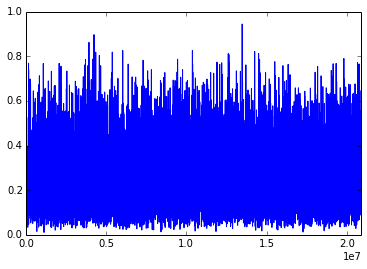

In [84]:
users['click_ratio'].plot()

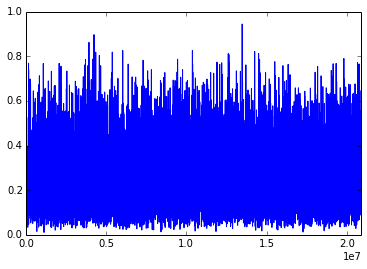

In [85]:
users['smooth_ctr'].plot()

In [6]:
user_item_train.head()

NameError: name 'user_item_train' is not defined

In [87]:
def browse_time_diff(group):
#     print(group.head())
    m1, m2 = group.min(), group.max()
    return (m2 - m1) / 1000

In [88]:
users['browse_time_diff'] = user_item_train.groupby(['user_id'])['time'].transform(browse_time_diff)

In [89]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio,smooth_ctr,browse_time_diff
0,1637,1736,365,4,0,4124,27726,0.210539,0.002304,0.0,0.148741,0.210539,85339
1,1637,1736,365,4,0,4124,27726,0.210539,0.002304,0.0,0.148741,0.210539,85339
2,1637,1736,365,4,0,4124,27726,0.210539,0.002304,0.0,0.148741,0.210539,85339
3,1637,1736,365,4,0,4124,27726,0.210539,0.002304,0.0,0.148741,0.210539,85339
4,1637,1736,365,4,0,4124,27726,0.210539,0.002304,0.0,0.148741,0.210539,85339


In [5]:
85339/3600

23

In [90]:
users.drop_duplicates(['user_id'], inplace=True)

In [91]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio,smooth_ctr,browse_time_diff
0,1637,1736,365,4,0,4124,27726,0.210539,0.002304,0.000000,0.148741,0.210539,85339
1736,17470,477,82,0,1,1937,8586,0.173687,0.000000,0.002096,0.225600,0.173687,52031
2213,14148,852,139,2,1,1120,16928,0.164248,0.002347,0.001174,0.066163,0.164248,91511
3065,37431,355,128,4,1,2548,8752,0.357969,0.011268,0.002817,0.291133,0.357969,42472
3420,35273,2486,576,0,1,7228,35415,0.231814,0.000000,0.000402,0.204094,0.231814,112242


In [92]:
users.reset_index(drop=True, inplace=True)

In [93]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio,smooth_ctr,browse_time_diff
0,1637,1736,365,4,0,4124,27726,0.210539,0.002304,0.000000,0.148741,0.210539,85339
1,17470,477,82,0,1,1937,8586,0.173687,0.000000,0.002096,0.225600,0.173687,52031
2,14148,852,139,2,1,1120,16928,0.164248,0.002347,0.001174,0.066163,0.164248,91511
3,37431,355,128,4,1,2548,8752,0.357969,0.011268,0.002817,0.291133,0.357969,42472
4,35273,2486,576,0,1,7228,35415,0.231814,0.000000,0.000402,0.204094,0.231814,112242


In [94]:
users.shape

(15120, 13)

In [143]:
users[users['click_ratio']>0.9]

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,...,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor,face_click_favor,non_face_click_favor
9724,15221,1478,1402,0,0,15966,22528,0.944147,0.0,0.0,...,0.270328,0.151213,0.006991,0.009857,5.66297,3.202271,10.002722,7.806586,0.315977,0.684023


# 数据科学竞赛中的Data Leakage
因果颠倒，比如点击之后视频就会被播放，但是视频播放并不是点击的原因，恰恰是点击的结果，因此这种特征在比赛中可以提高成绩，但是却把因果颠倒了。

 - [Data Leakage in Machine Learning](https://machinelearningmastery.com/data-leakage-machine-learning/)
 - [Working with Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)

In [97]:
# 先验认为，点击频率越大，点击的可能性越高？试试
users['click_freq'] = users['click_num'] / users['browse_time_diff']
users['browse_freq'] = users['browse_num'] / users['browse_time_diff']
users['playing_freq'] = users['playing_sum'] / users['browse_time_diff']

In [98]:
def face_counts(group):
    face_counts = 0
    
    for v in group.values:
        if v != 0:
            face_counts += 1.
    return face_counts / group.size
            

In [99]:
def face_counts(group):
    have_faces = group > 0
    return 1. * np.sum(have_faces) / group.size
 
def non_face_counts(group):
    have_faces = group == 0
    return 1. * np.sum(have_faces) / group.size

In [100]:
test = user_item_train.loc[user_item_train['click']==1, ['user_id', 'face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'man_avg_age', 'woman_avg_age', 'man_avg_attr', 'woman_avg_attr']]


In [101]:
test['face_click_favor'] = test['face_num'].groupby(test['user_id']).transform(face_counts)

In [102]:
test['non_face_click_favor'] = test['face_num'].groupby(test['user_id']).transform(non_face_counts)

In [104]:
favors = user_item_train.loc[user_item_train['click']==1, ['user_id', 'face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'man_avg_age', 'woman_avg_age', 'man_avg_attr', 'woman_avg_attr']]
favors['face_favor'] = favors['face_num'].groupby(favors['user_id']).transform('mean')
favors['man_favor'] = favors['man_num'].groupby(favors['user_id']).transform('mean')
favors['woman_favor'] = favors['woman_num'].groupby(favors['user_id']).transform('mean')
favors['man_cv_favor'] = favors['man_scale'].groupby(favors['user_id']).transform('mean')
favors['woman_cv_favor'] = favors['woman_scale'].groupby(favors['user_id']).transform('mean')
favors['man_age_favor'] = favors['man_avg_age'].groupby(favors['user_id']).transform('mean')
favors['woman_age_favor'] = favors['woman_avg_age'].groupby(favors['user_id']).transform('mean')
favors['man_yen_value_favor'] = favors['man_avg_attr'].groupby(favors['user_id']).transform('mean')
favors['woman_yen_value_favor'] = favors['woman_avg_attr'].groupby(favors['user_id']).transform('mean')

In [105]:
favors['face_click_favor'] = favors['face_num'].groupby(favors['user_id']).transform(face_counts)
favors['non_face_click_favor'] = favors['face_num'].groupby(favors['user_id']).transform(non_face_counts)

In [106]:
len(favors)

4221529

In [107]:
favors.head()

,user_id,face_num,man_num,woman_num,man_scale,woman_scale,man_avg_age,woman_avg_age,man_avg_attr,woman_avg_attr,...,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor,face_click_favor,non_face_click_favor
2,1637,3.0,3.0,0.0,0.3959,0.0000,26.333333,0.0,48.333333,0.0,...,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749,0.649315,0.350685
5,1637,3.0,3.0,0.0,0.0103,0.0000,27.000000,0.0,51.666667,0.0,...,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749,0.649315,0.350685
8,1637,2.0,1.0,1.0,0.0088,0.0104,21.000000,27.0,56.000000,48.0,...,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749,0.649315,0.350685
19,1637,2.0,0.0,2.0,0.0000,0.1018,0.000000,24.0,0.000000,47.0,...,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749,0.649315,0.350685
20,1637,1.0,0.0,1.0,0.0000,0.1203,0.000000,22.0,0.000000,92.0,...,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749,0.649315,0.350685


In [108]:
favors.drop_duplicates(['user_id'], inplace=True)

favors.drop(['face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'man_avg_age', 'woman_avg_age', 'man_avg_attr', 'woman_avg_attr'], axis=1, inplace=True)

favors.reset_index(drop=True, inplace=True)

In [109]:
favors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15140 entries, 0 to 15139
Data columns (total 12 columns):
user_id                  15140 non-null int64
face_favor               15140 non-null float64
man_favor                15140 non-null float64
woman_favor              15140 non-null float64
man_cv_favor             15140 non-null float64
woman_cv_favor           15140 non-null float64
man_age_favor            15140 non-null float64
woman_age_favor          15140 non-null float64
man_yen_value_favor      15140 non-null float64
woman_yen_value_favor    15140 non-null float64
face_click_favor         15140 non-null float64
non_face_click_favor     15140 non-null float64
dtypes: float64(11), int64(1)
memory usage: 1.4 MB


In [110]:
favors.head()

,user_id,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor,face_click_favor,non_face_click_favor
0,1637,0.997260,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749,0.649315,0.350685
1,17470,0.426829,0.268293,0.158537,0.006262,0.014798,5.912602,3.987805,10.439024,10.829268,0.341463,0.658537
2,14148,0.726619,0.201439,0.525180,0.008571,0.051771,4.125899,10.139688,7.700000,25.859712,0.525180,0.474820
3,37431,0.484375,0.226562,0.257812,0.012066,0.018660,4.979167,5.050781,8.635417,14.738281,0.359375,0.640625
4,35273,0.359375,0.194444,0.164931,0.007851,0.011083,4.123264,3.647569,7.314959,9.075087,0.284722,0.715278


In [111]:
# # 用户点击视频中对人脸和颜值以及年龄的偏好，以后考虑离散化
# users['face_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'face_num']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['face_num'].values
# users['man_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'man_num']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['man_num'].values
# users['woman_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'woman_num']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['woman_num'].values
# users['man_cv_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'man_scale']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['man_scale'].values
# users['woman_cv_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'woman_scale']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['woman_scale'].values
# users['man_age_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'man_avg_age']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['man_avg_age'].values
# users['woman_age_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'woman_avg_age']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['woman_avg_age'].values
# users['man_yen_value_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'man_avg_attr']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['man_avg_attr'].values
# users['woman_yen_value_favor'] = user_item_train.loc[user_item_train['click']==1, ['user_id', 'woman_avg_attr']].groupby(user_item_train['user_id']).transform('mean').drop_duplicates(['user_id'])['woman_avg_attr'].values


In [112]:
users = pd.merge(users, favors,
                how='left',
                on=['user_id'])

In [113]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 0 to 15119
Data columns (total 27 columns):
user_id                  15120 non-null int64
browse_num               15120 non-null int64
click_num                15120 non-null int64
like_num                 15120 non-null int64
follow_num               15120 non-null int64
playing_sum              15120 non-null int64
duration_sum             15120 non-null int64
click_ratio              15120 non-null float64
like_ratio               15120 non-null float64
follow_ratio             15120 non-null float64
playing_ratio            15120 non-null float64
smooth_ctr               15120 non-null float64
browse_time_diff         15120 non-null int64
click_freq               15120 non-null float64
browse_freq              15120 non-null float64
playing_freq             15120 non-null float64
face_favor               15119 non-null float64
man_favor                15119 non-null float64
woman_favor              15119 non-null flo

In [114]:
users.columns.values

array(['user_id', 'browse_num', 'click_num', 'like_num', 'follow_num',
       'playing_sum', 'duration_sum', 'click_ratio', 'like_ratio',
       'follow_ratio', 'playing_ratio', 'smooth_ctr', 'browse_time_diff',
       'click_freq', 'browse_freq', 'playing_freq', 'face_favor',
       'man_favor', 'woman_favor', 'man_cv_favor', 'woman_cv_favor',
       'man_age_favor', 'woman_age_favor', 'man_yen_value_favor',
       'woman_yen_value_favor', 'face_click_favor',
       'non_face_click_favor'], dtype=object)

In [115]:
np.sum(np.isnan(users))

user_id                  0
browse_num               0
click_num                0
like_num                 0
follow_num               0
playing_sum              0
duration_sum             0
click_ratio              0
like_ratio               0
follow_ratio             0
playing_ratio            0
smooth_ctr               0
browse_time_diff         0
click_freq               0
browse_freq              0
playing_freq             0
face_favor               1
man_favor                1
woman_favor              1
man_cv_favor             1
woman_cv_favor           1
man_age_favor            1
woman_age_favor          1
man_yen_value_favor      1
woman_yen_value_favor    1
face_click_favor         1
non_face_click_favor     1
dtype: int64

In [116]:
users.fillna(0, inplace=True)

In [117]:
np.sum(np.isnan(users))

user_id                  0
browse_num               0
click_num                0
like_num                 0
follow_num               0
playing_sum              0
duration_sum             0
click_ratio              0
like_ratio               0
follow_ratio             0
playing_ratio            0
smooth_ctr               0
browse_time_diff         0
click_freq               0
browse_freq              0
playing_freq             0
face_favor               0
man_favor                0
woman_favor              0
man_cv_favor             0
woman_cv_favor           0
man_age_favor            0
woman_age_favor          0
man_yen_value_favor      0
woman_yen_value_favor    0
face_click_favor         0
non_face_click_favor     0
dtype: int64

In [119]:
users[users['click_ratio']==1]

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,...,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor,face_click_favor,non_face_click_favor


# 特征离散化
离散化是特征处理的重要手段之一，可以提高模型的抗干扰能力，比如年龄20和30其实对某些视频点击差异不大，但是如果使用连续值，在LR中会导致W差异巨大。比如一个年龄突然200岁，如果可以分段，那么相对来说，就可以避免这一异常。

## 各种离散编码方式对比
 - Categorical Encoding (raw, as is)
   * 原始的分类特征，不一定是数字，比如，性别（男女），国家（中国、美国、俄罗斯）
 - Numeric Encoding
   * 分类特征分别映射到数字叫 Numeric Encoding, 只需要1维度. 比如 性别(0|1), 国家(0|1|2)
 - One-Hot Encoding
   * 进行 one hot 编码，取值种类为 N，则需要 N 个维度，因此对于像用户 id 这种上亿级别的特征，最好不适用 one hot编码
 - Binary Encoding
   * 对分类的N种取值进行二进制编码，这就是计算机编码方式，只需要 logN 的维度即可
   
LR 模型比较适合 one-hot 编码，树模型直接使用 Categorical 或者 Numerical Encoding 即可，其他编码方式对于树模型来讲，效果一般

### 参考
 - [Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)
 - [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
 
## ONE-HOT 编码解释
 - 使用one-hot编码，将离散特征的取值扩展到了欧式空间，离散特征的某个取值就对应欧式空间的某个点.
 - 将离散特征通过one-hot编码映射到欧式空间，是因为，在回归，分类，聚类等机器学习算法中，特征之间距离的计算或相似度的计算是非常重要的，而我们常用的距离或相似度的计算都是在欧式空间的相似度计算，计算余弦相似性，基于的就是欧式空间.
 - 将离散型特征使用one-hot编码，确实会让特征之间的距离计算更加合理。比如，有一个离散型特征，代表工作类型，该离散型特征，共有三个取值，不使用one-hot编码，其表示分别是x_1 = (1), x_2 = (2), x_3 = (3)。两个工作之间的距离是，(x_1, x_2) = 1, d(x_2, x_3) = 1, d(x_1, x_3) = 2。那么x_1和x_3工作之间就越不相似吗？显然这样的表示，计算出来的特征的距离是不合理。那如果使用one-hot编码，则得到x_1 = (1, 0, 0), x_2 = (0, 1, 0), x_3 = (0, 0, 1)，那么两个工作之间的距离就都是sqrt(2).即每两个工作之间的距离是一样的，显得更合理.
 - 离散特征进行one-hot编码后，编码后的特征，其实每一维度的特征都可以看做是连续的特征。就可以跟对连续型特征的归一化方法一样，对每一维特征进行归一化。比如归一化到[-1,1]或归一化到均值为0,方差为1.
 - 基于树的方法是不需要进行特征的归一化，例如随机森林，bagging 和 boosting等。基于参数的模型或基于距离的模型，都是要进行特征的归一化.

In [120]:
def browse_num_discretization(num):
    if 0 <= num <= 100:
        return 0
    elif 100 < num <= 200:
        return 1
    elif 200 < num <= 500:
        return 2
    elif 500 < num <= 1000:
        return 3
    else:
        return 4

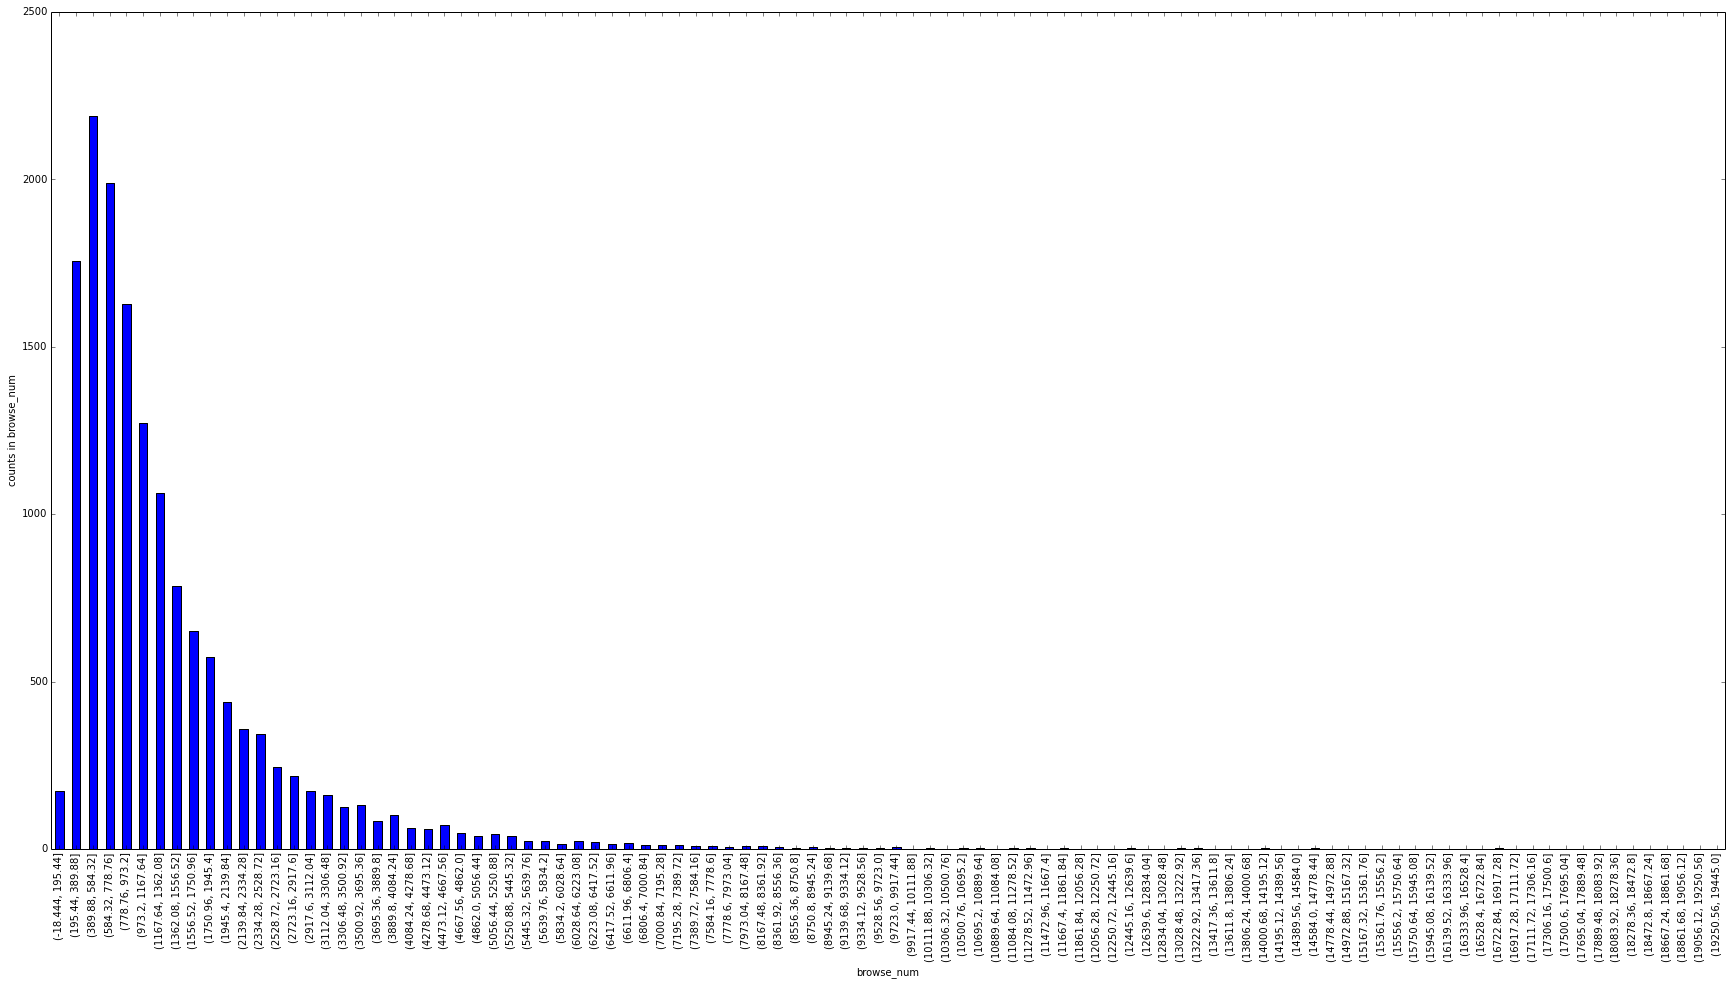

In [121]:
plot_data_cut(users, 'browse_num', 100)

In [179]:
users[users['browse_num']> 10000]['click_num'].describe()

count      42.000000
mean      848.761905
std       590.091965
min       117.000000
25%       379.750000
50%       658.500000
75%      1160.500000
max      2440.000000
Name: click_num, dtype: float64

In [ ]:
def browse_time_diff_discretization(num):
    if 0 <= num <= 500:
        return 0
    elif 500 < num <= 10000:
        return 1
    elif 10000 < num <= 20000:
        return 2
    elif 20000 < num <= 30000:
        return 3
    elif 30000 < num <= 40000:
        return 4
    elif 40000 < num <= 50000:
        return 5
    elif 50000 < num <= 60000:
        return 6
    elif 60000 < num <= 80000:
        return 7
    elif 80000 < num <= 100000:
        return 8
    else:
        return 9
    

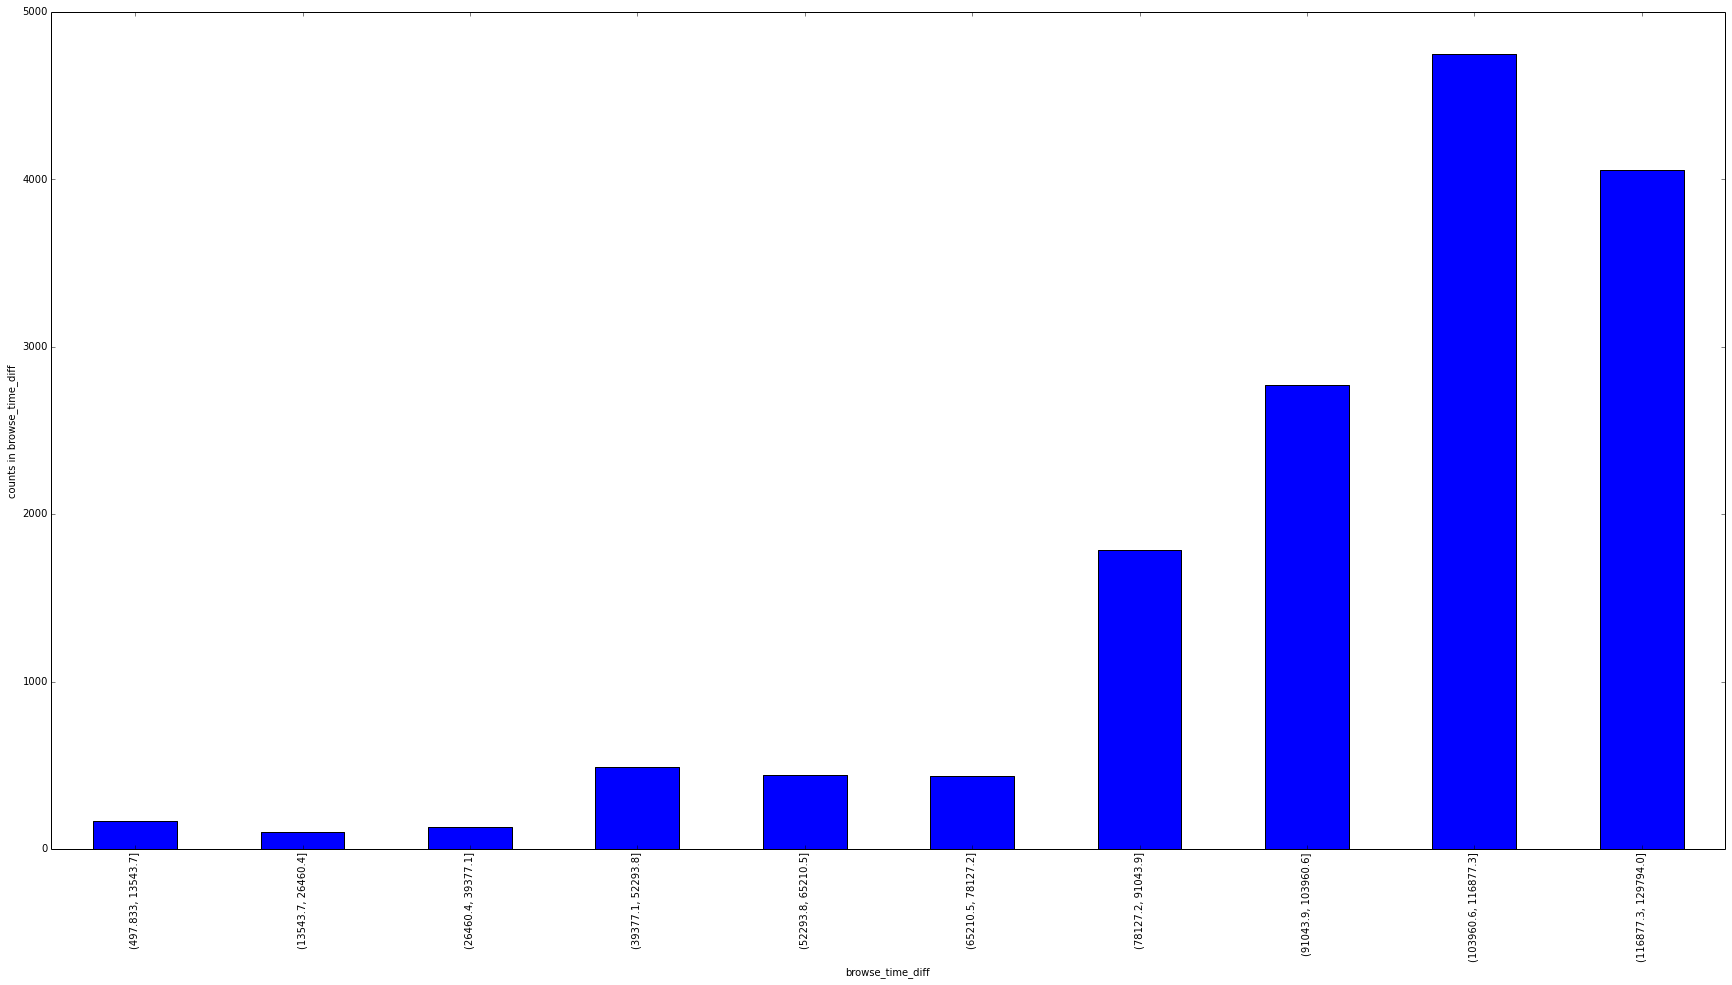

In [163]:
plot_data_cut(users, 'browse_time_diff', 10)

In [122]:
def click_num_discretization(num):
    if 0 <= num <= 50:
        return 0
    elif 50 < num <= 100:
        return 1
    elif 100 < num <= 500:
        return 2
    elif 500 < num <= 1000:
        return 3
    else:
        return 4

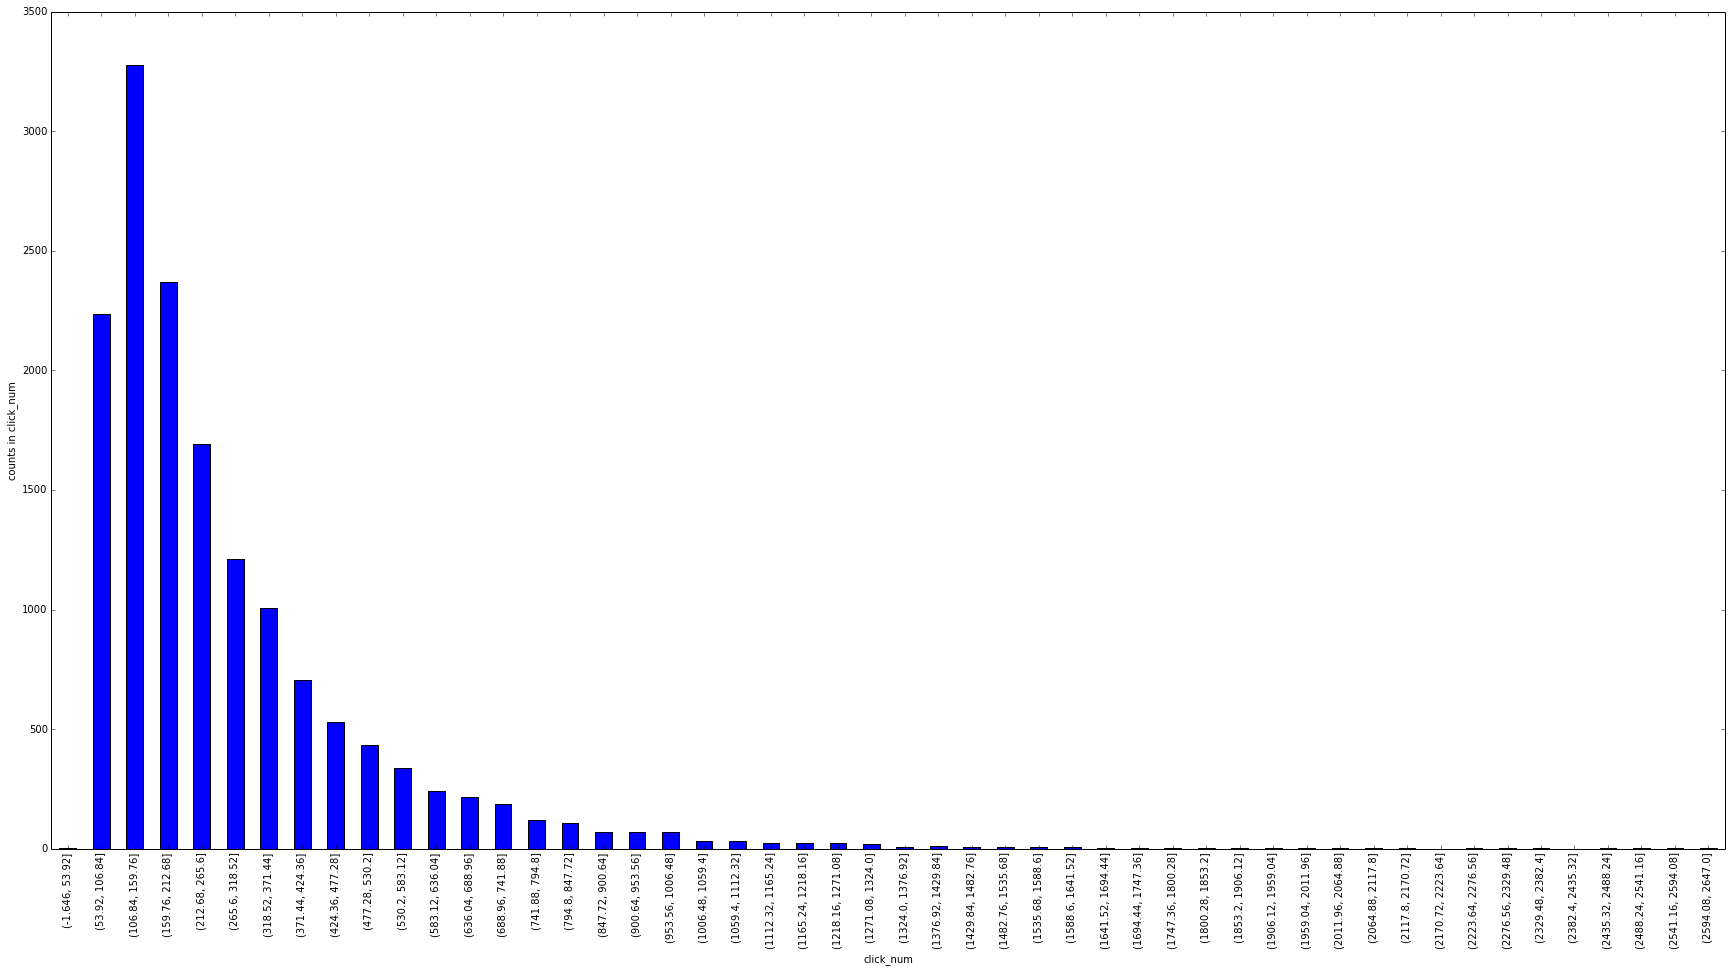

In [123]:
plot_data_cut(users, 'click_num', 50)

In [116]:
users[users['click_num']>1000].shape

NameError: name 'users' is not defined

In [182]:
users[users['click_num']>1500]['browse_num'].describe()

count       54.000000
mean      6257.333333
std       3289.064580
min       2242.000000
25%       3807.250000
50%       5289.500000
75%       7467.250000
max      14656.000000
Name: browse_num, dtype: float64

In [124]:
def like_num_discretization(num):
    if 0 == num:
        return 0
    elif 1 <= num <= 5:
        return 1
    elif 5 < num <= 20:
        return 3
    else:
        return 4

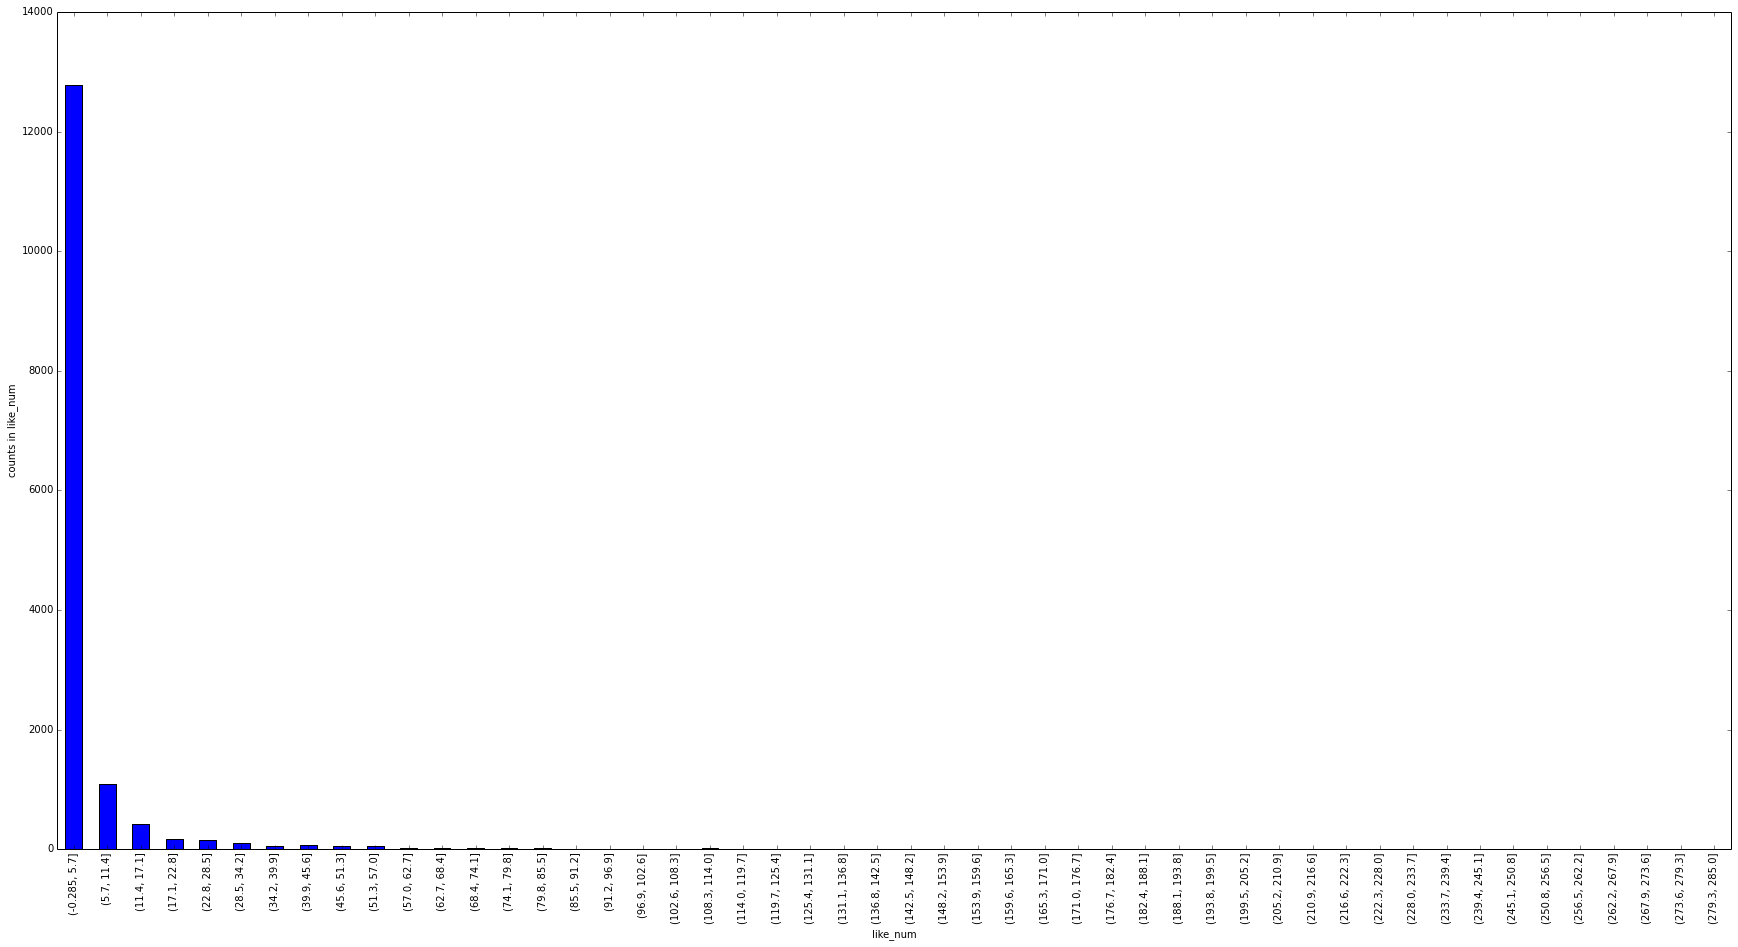

In [125]:
plot_data_cut(users, 'like_num', 50)

In [197]:
users[users['like_num']==0].shape

(7505, 27)

In [200]:
users[users['like_num']>20].shape

(718, 27)

In [126]:
def follow_num_discretization(num):
    if 0 == num:
        return 0
    else:
        return 1

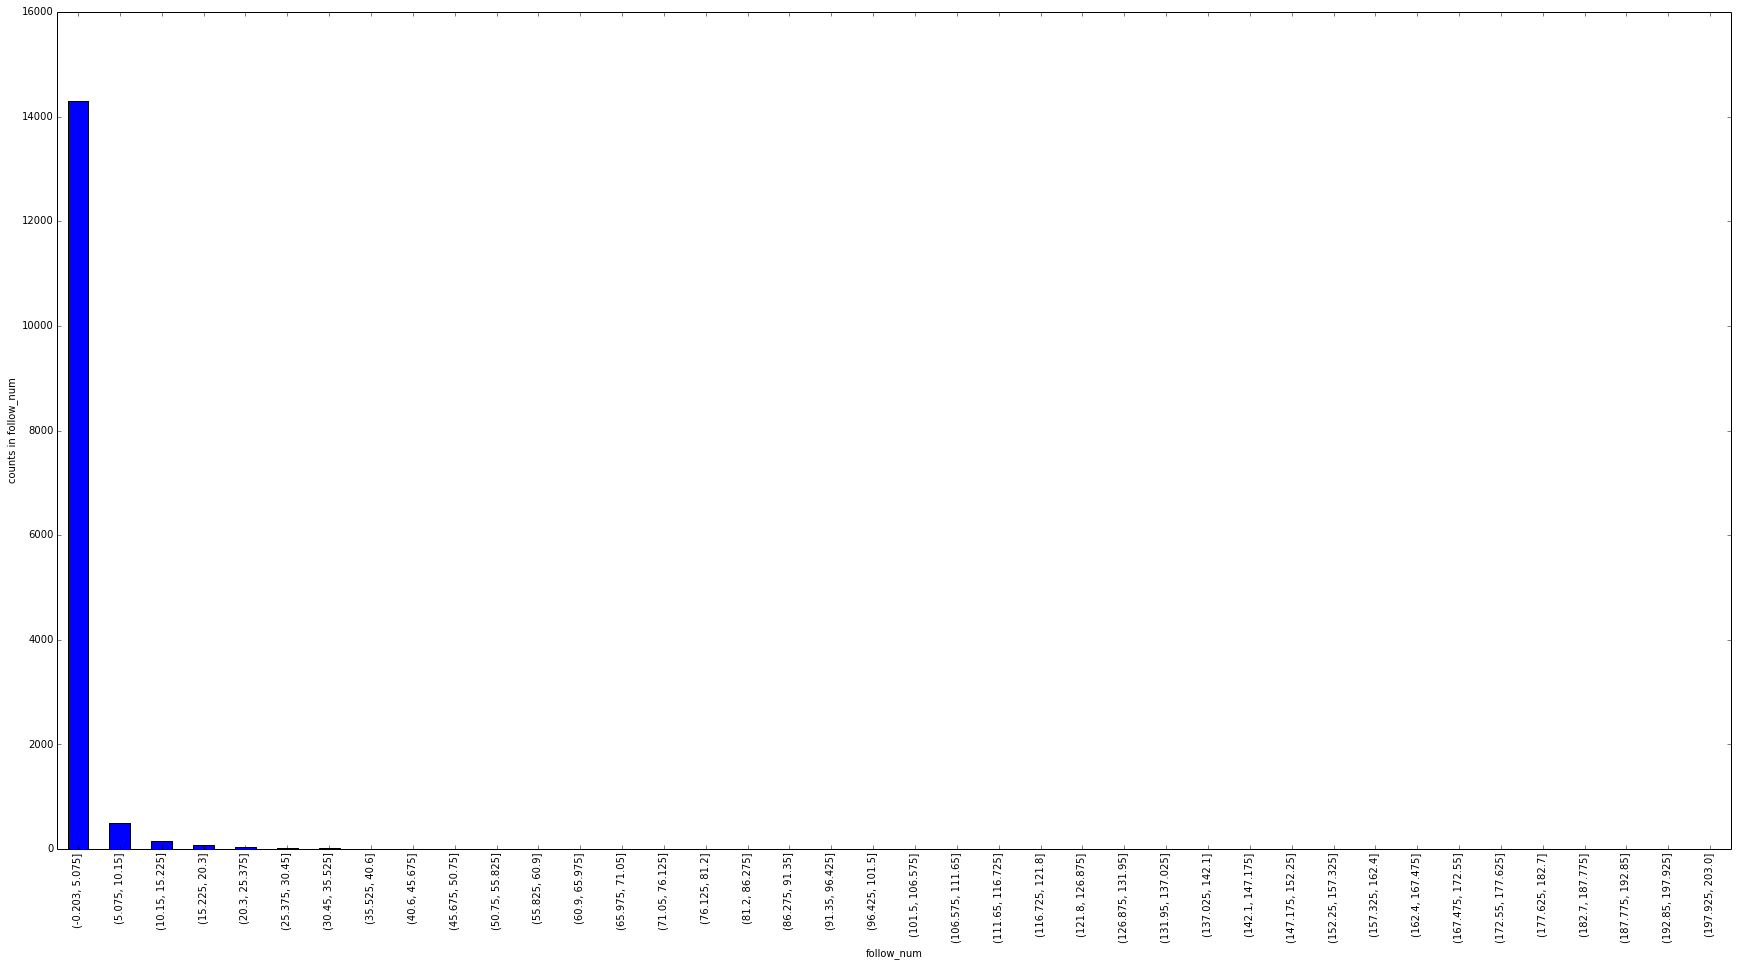

In [127]:
plot_data_cut(users, 'follow_num', 40)

In [191]:
users[users['follow_num']>1].shape

(3472, 27)

In [128]:
def playing_sum_discretization(num):
    if 0 <= num and num <= 2000:
        return 0
    elif 2000 < num <= 5000:
        return 1
    elif 5000 < num <= 10000:
        return 2
    elif 10000 < num <= 20000:
        return 3
    else:
        return 4

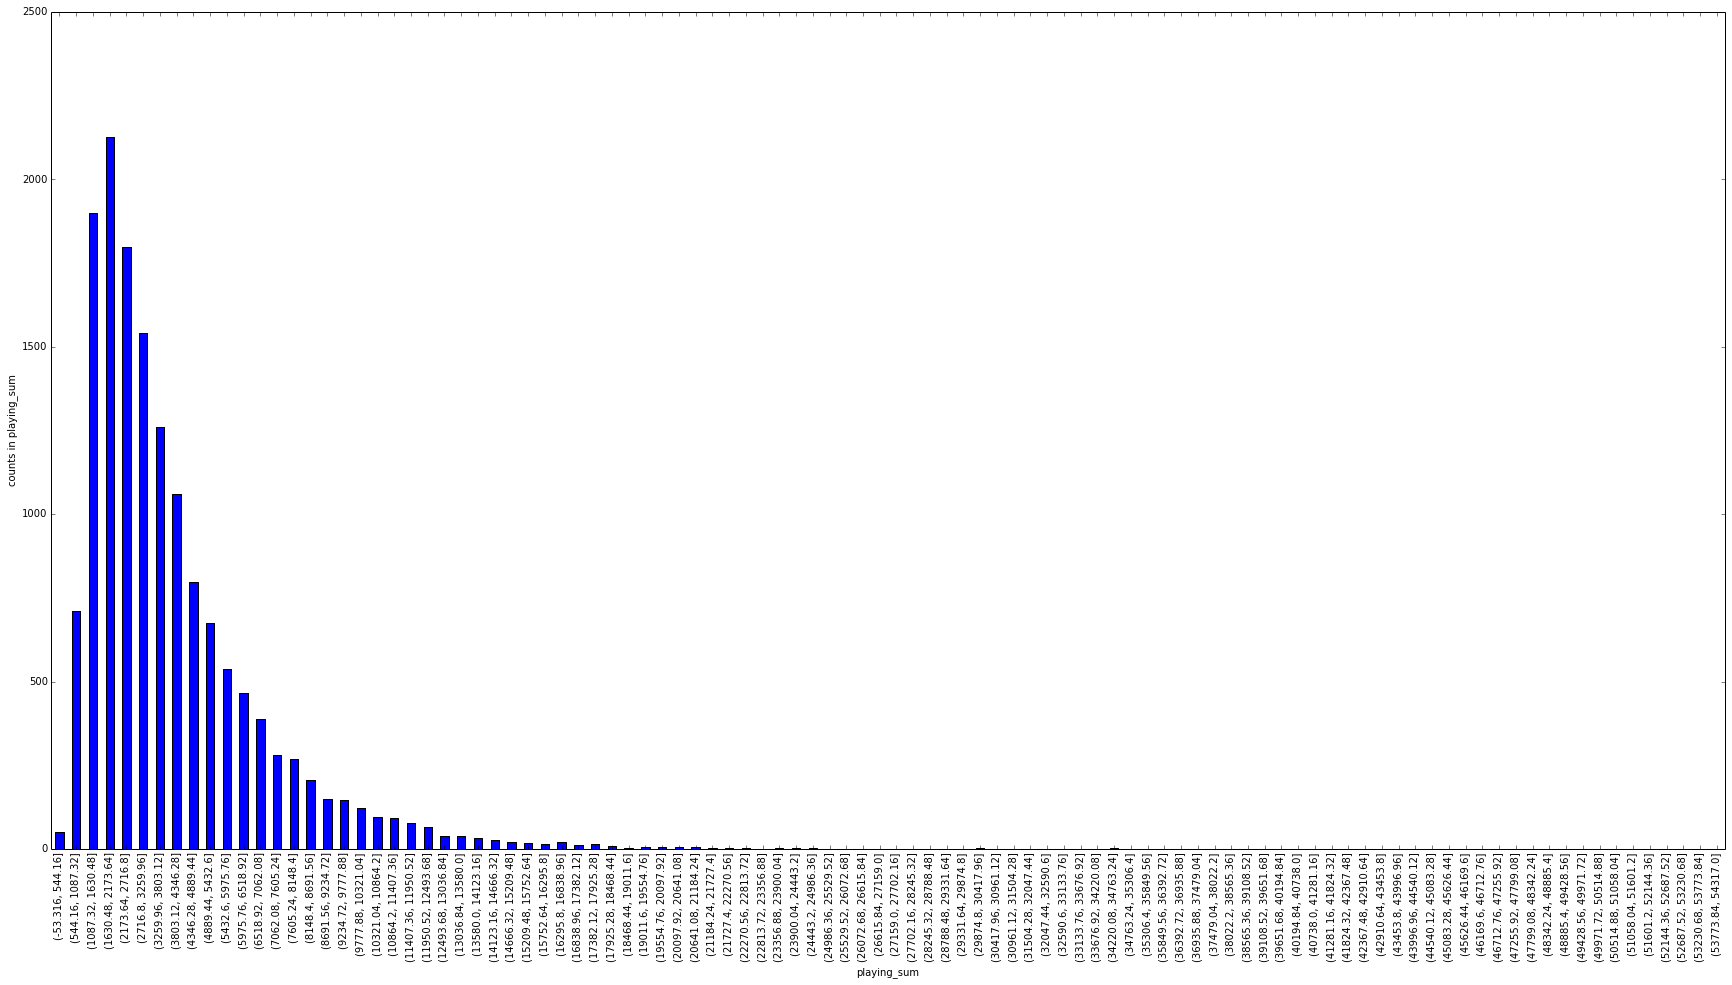

In [129]:
plot_data_cut(users, 'playing_sum', 100)

In [142]:
def duration_sum_discretization(num):
    if 1000 <= num <= 10000:
        return 0
    elif 10000 < num <= 20000:
        return 1
    elif 20000 < num <= 30000:
        return 2
    elif 30000 < num <= 40000:
        return 3
    elif 40000 < num <= 60000:
        return 4
    elif 60000 < num <= 80000:
        return 5
    else:
        return 6

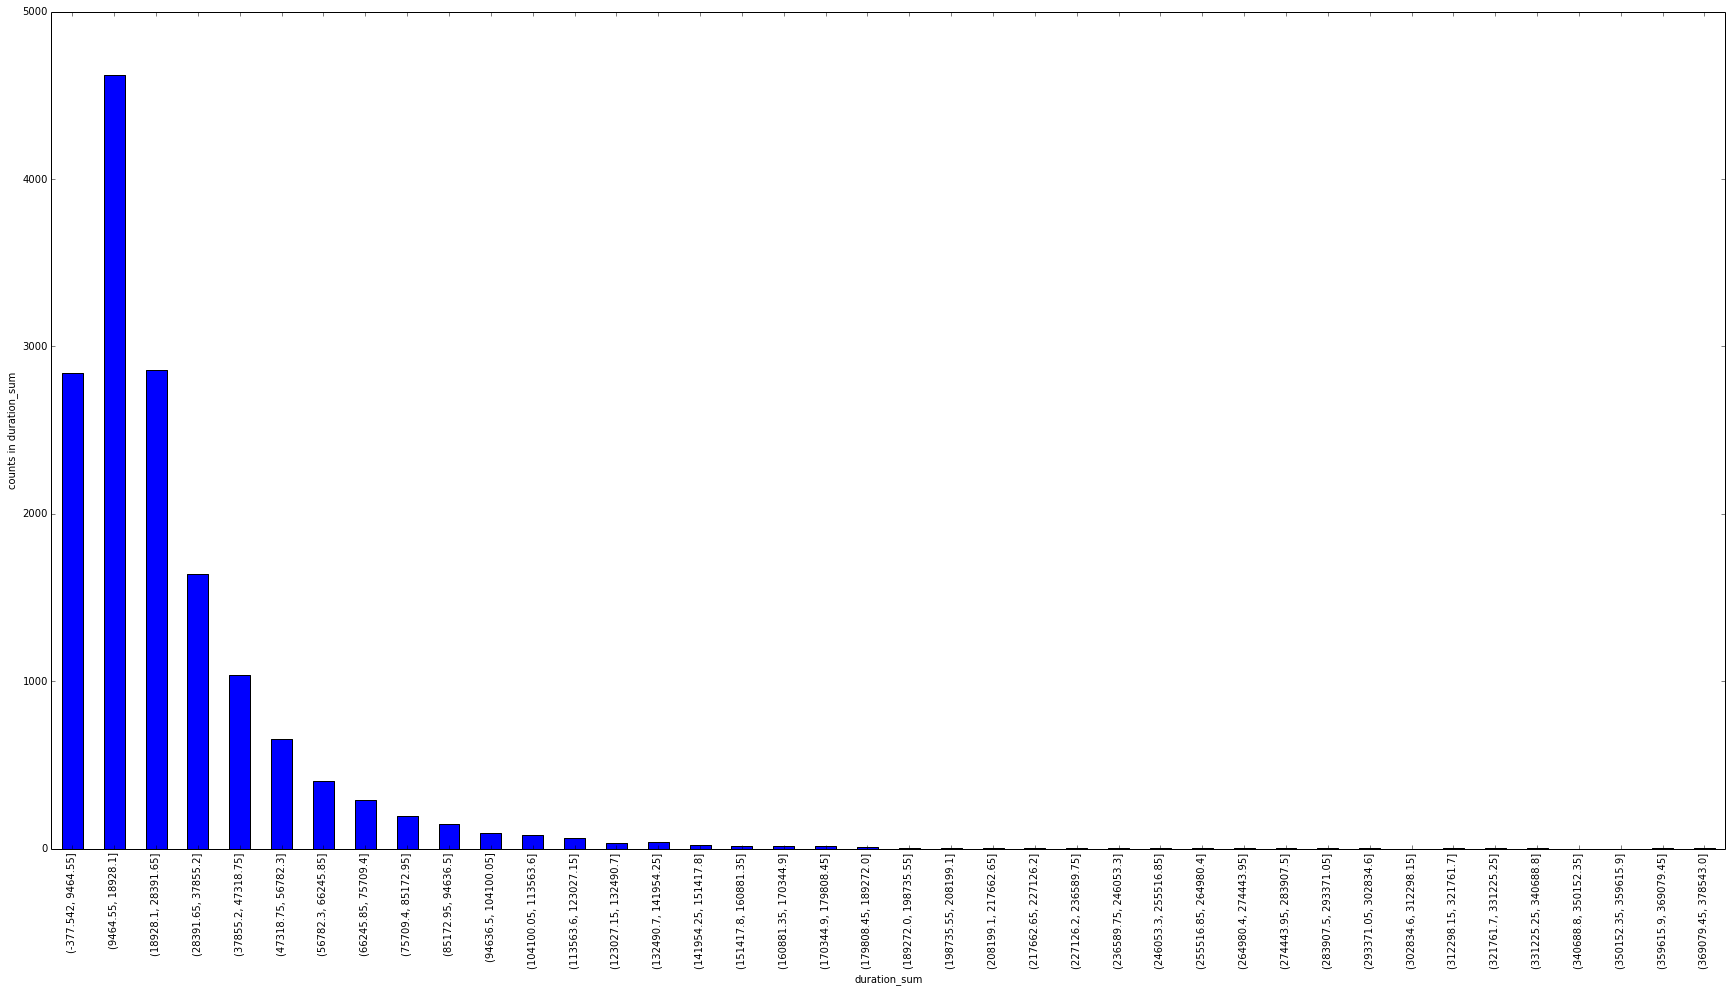

In [131]:
plot_data_cut(users, 'duration_sum', 40)

In [132]:
def click_ratio_discretization(num):
    if 0 < num and num < 0.1:
        return 0
    elif 0.1 < num and num < 0.2:
        return 1
    elif 0.2 < num and num < 0.4:
        return 2
    elif 0.4 < num and num < 0.6:
        return 3
    elif 0.6 < num and num < 0.8:
        return 4
    else:
        return 5

In [110]:
users[users['click_ratio']>0.5].shape

NameError: name 'users' is not defined

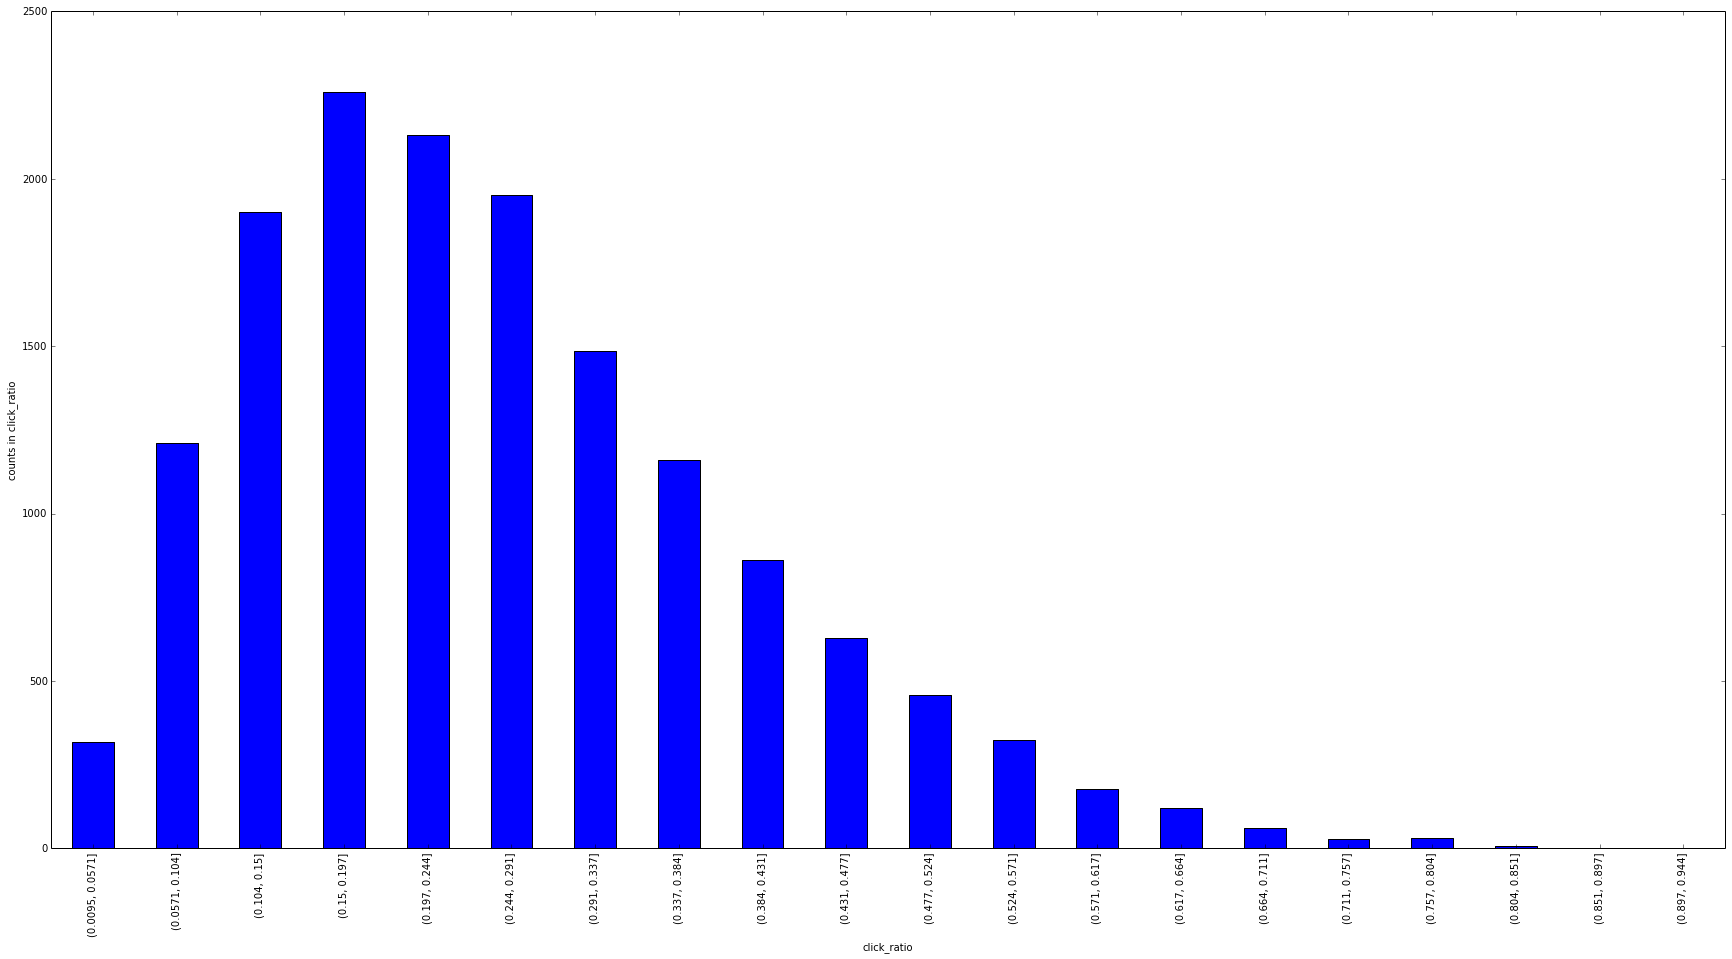

In [133]:
plot_data_cut(users, 'click_ratio', 20)

In [ ]:
def face_click_favor_discretization(num):
    if 0 <= num <= 0.1:
        return 0
    elif 0.1 < num <= 0.2:
        return 1
    elif 0.2 < num <= 0.4:
        return 2
    elif 0.4 < num <= 0.6:
        return 3
    elif 0.6 < num <= 0.8:
        return 4
    else:
        return 5

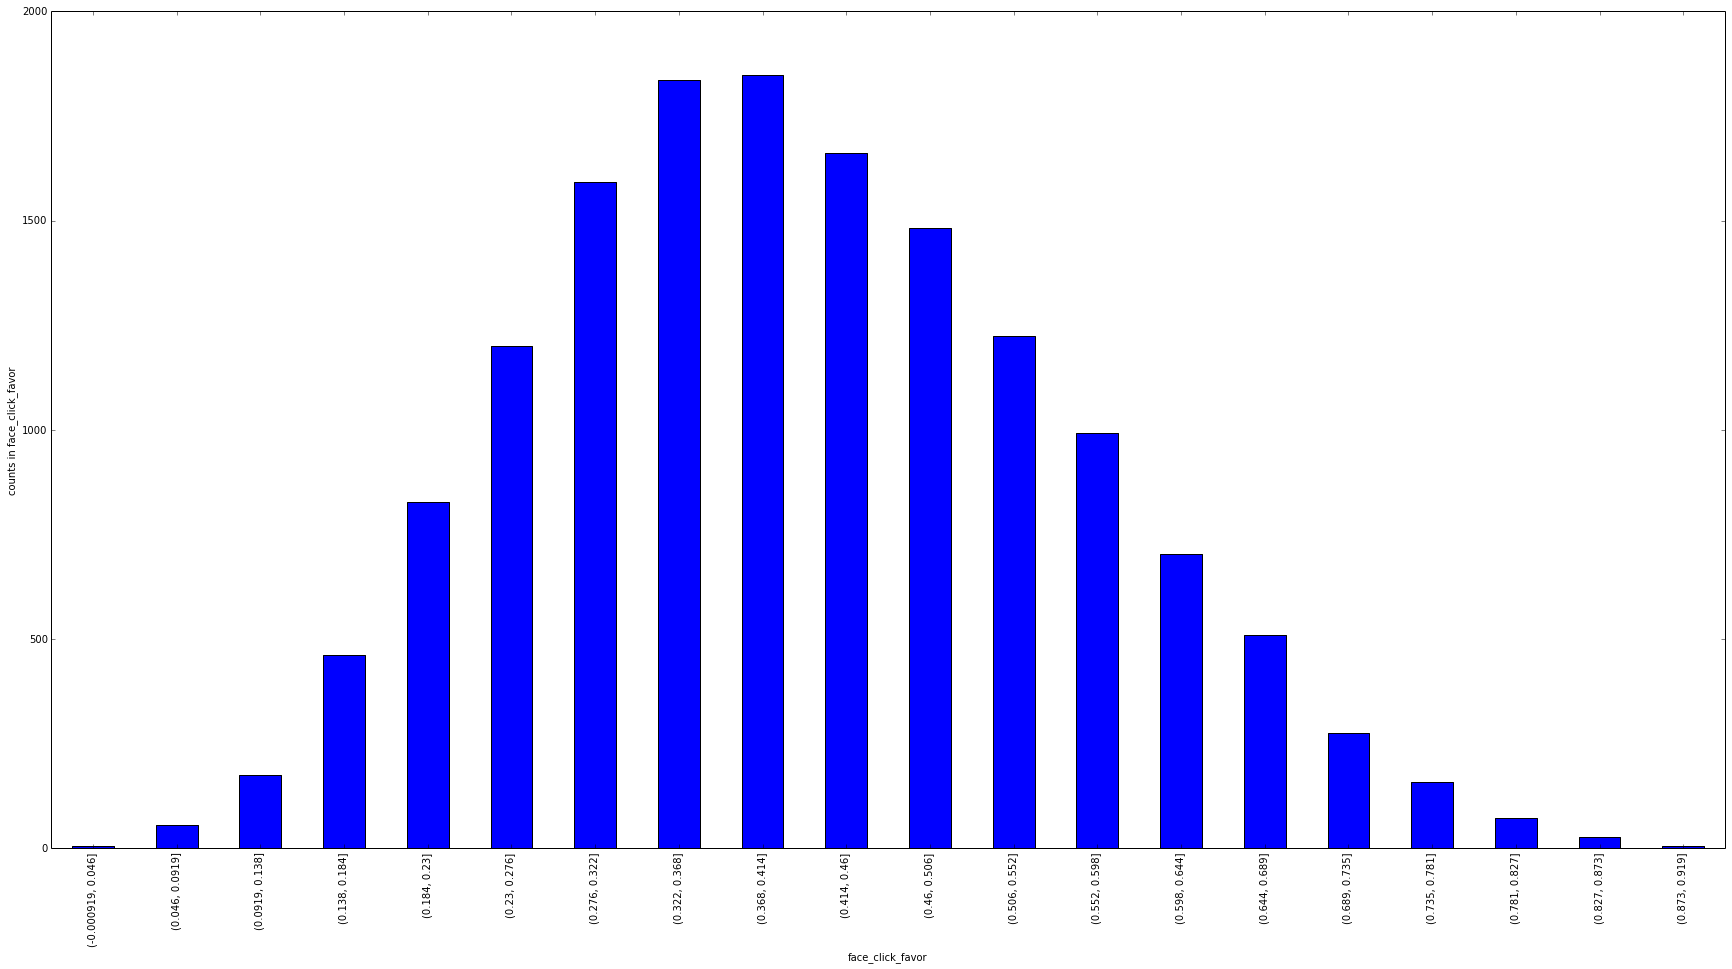

In [134]:
plot_data_cut(users, 'face_click_favor', 20)

In [ ]:
def non_face_click_favor_discretization(num):
    if 0 <= num <= 0.1:
        return 0
    elif 0.1 < num <= 0.2:
        return 1
    elif 0.2 < num <= 0.4:
        return 2
    elif 0.4 < num <= 0.6:
        return 3
    elif 0.6 < num <= 0.8:
        return 4
    else:
        return 5

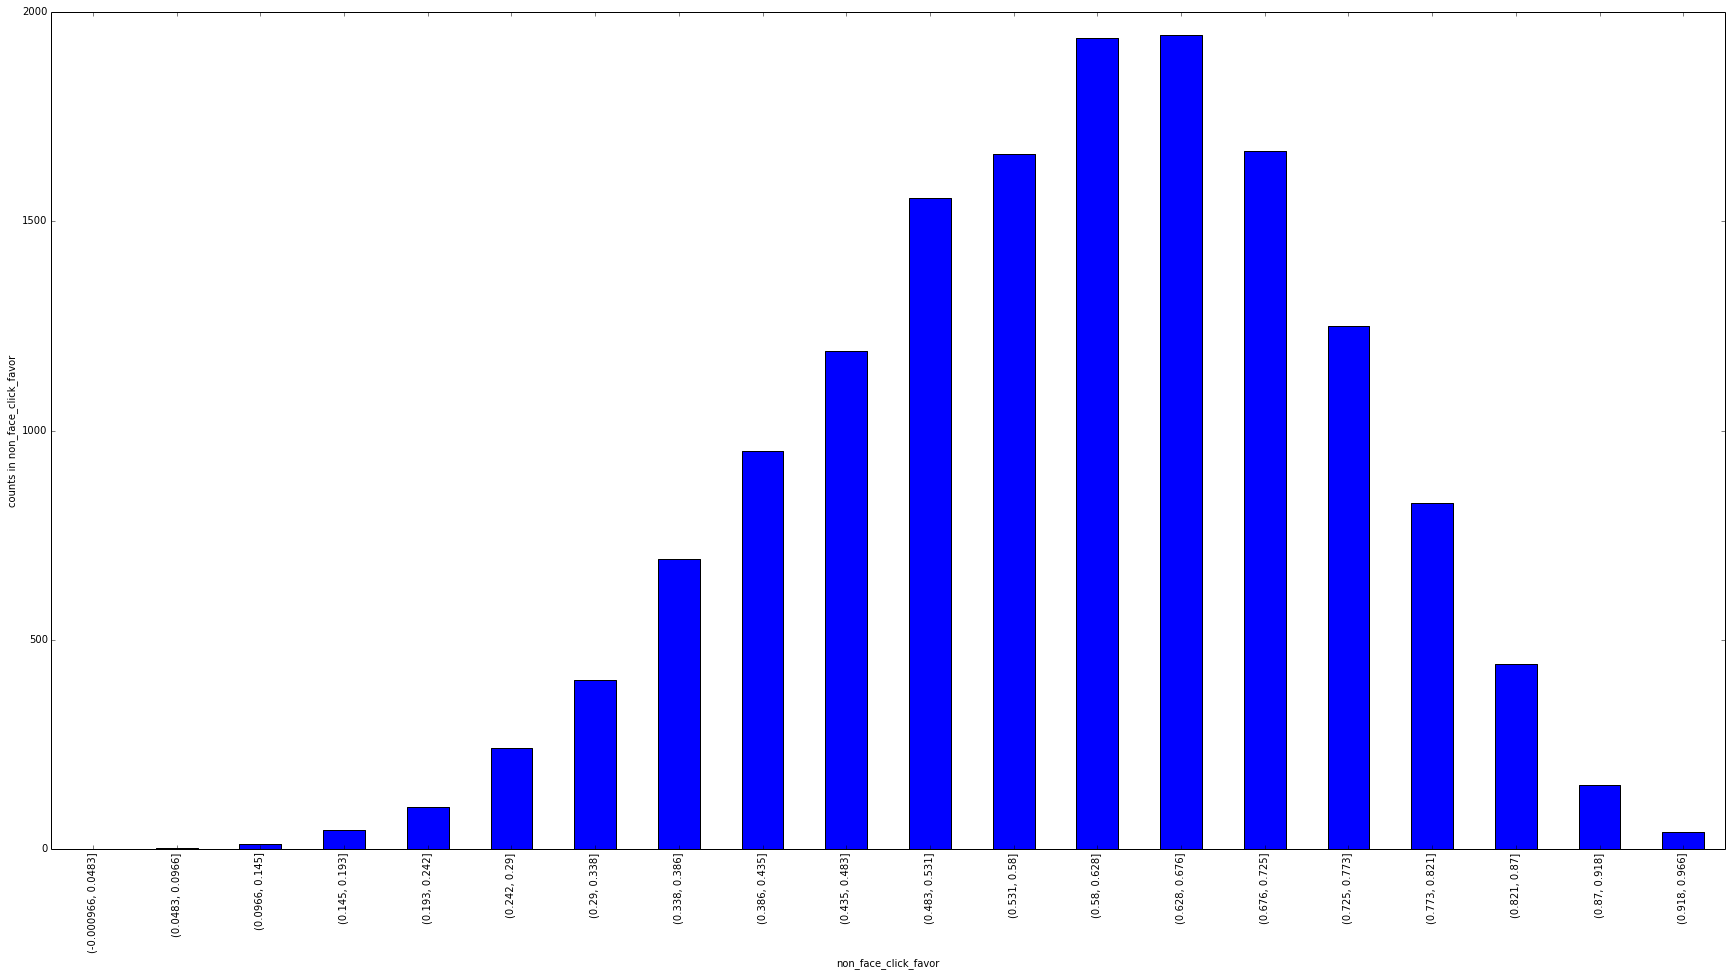

In [135]:
plot_data_cut(users, 'non_face_click_favor', 20)

In [ ]:
def click_freq_discretization(num):
    if 0 <= num <= 0.003:
        return 0
    elif 0.003 < num <= 0.006:
        return 1
    elif 0.006 < num <= 0.01:
        return 2
    else:
        return 3

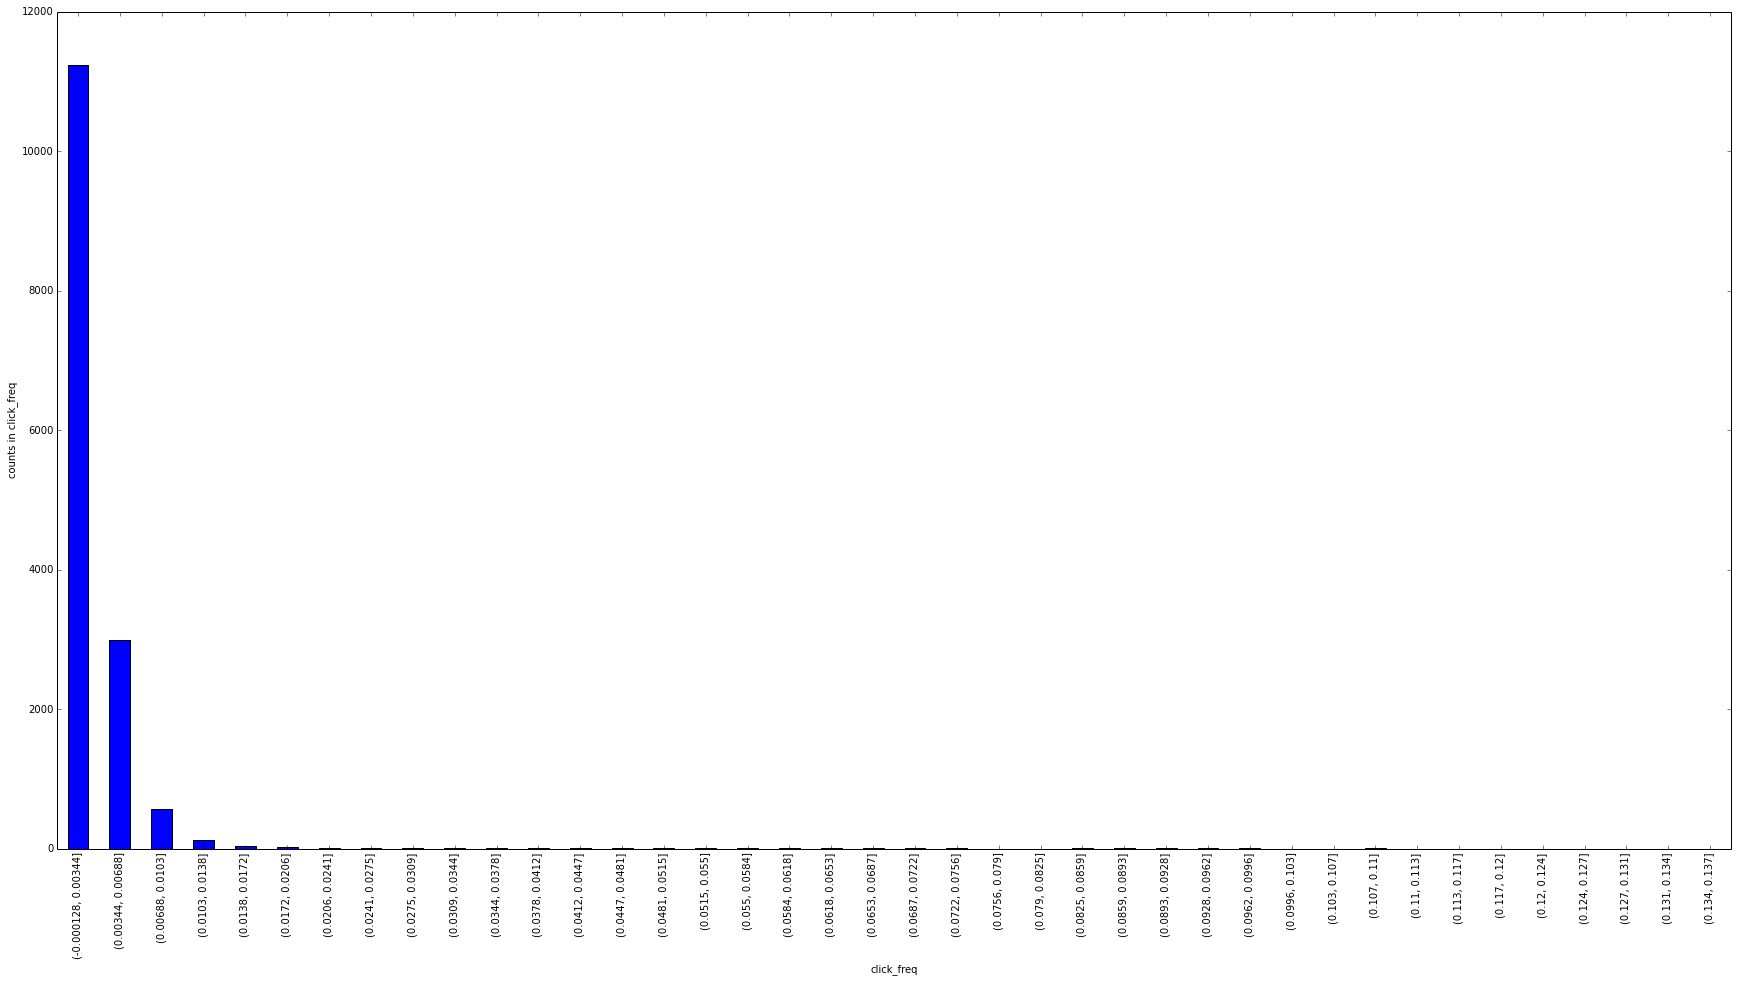

In [141]:
plot_data_cut(users, 'click_freq', 40)

In [ ]:
def browse_freq_discretization(num):
    if 0 <= num <= 0.02:
        return 0
    elif 0.02 < num <= 0.04:
        return 1
    elif 0.04 < num <= 0.06:
        return 2
    elif 0.06 < num <= 0.08
        return 3
    else:
        return 4

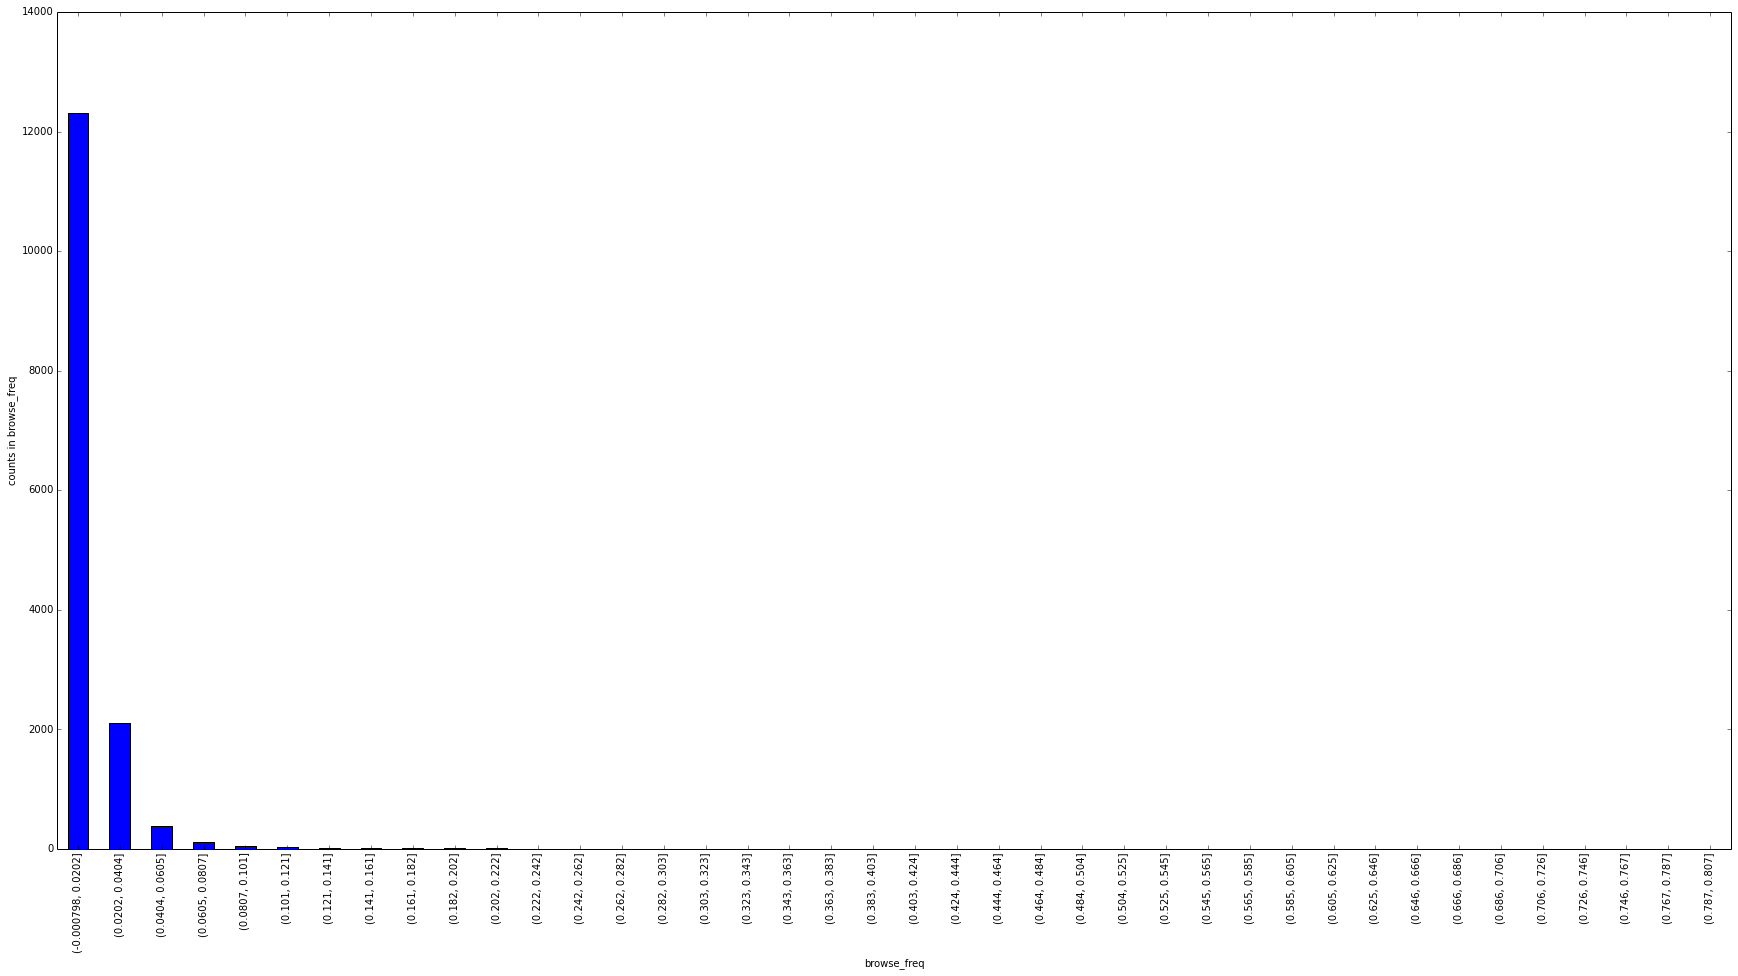

In [139]:
plot_data_cut(users, 'browse_freq', 40)

In [ ]:
def playing_freq_discretization(num):
    if 0 <= num <= 0.05:
        return 0
    elif 0.05 < num <= 0.1:
        return 1
    elif 0.15 < num <= 0.2:
        return 2
    else:
        return 3

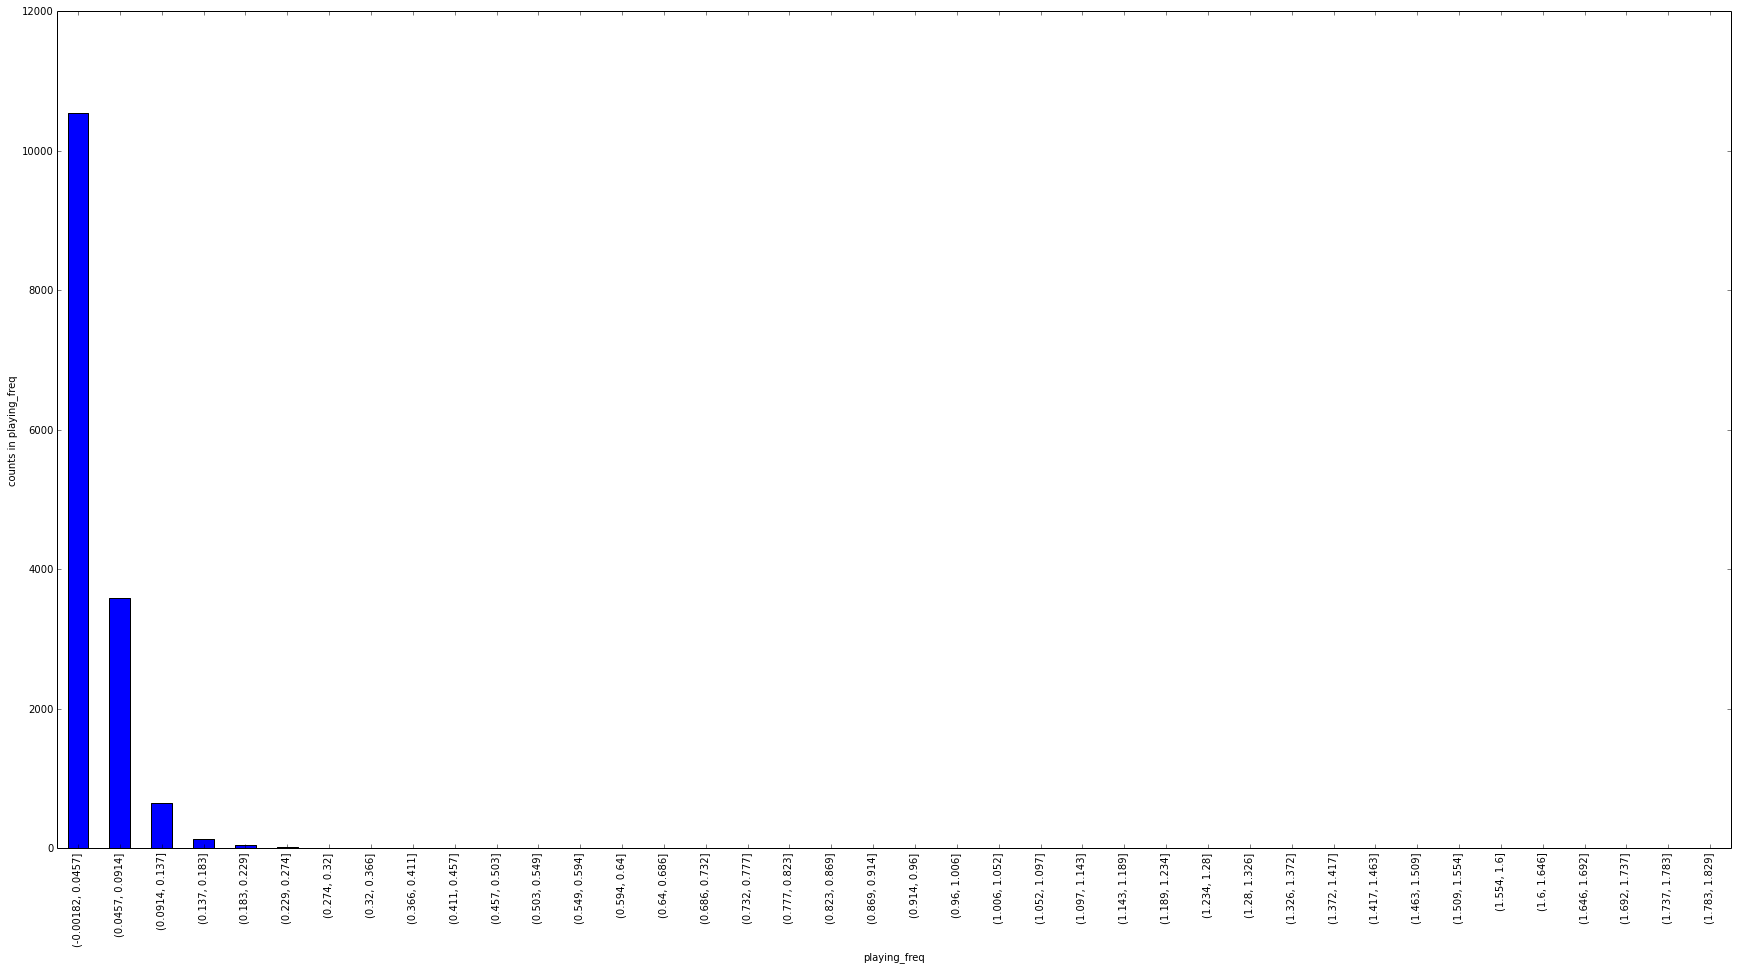

In [140]:
plot_data_cut(users, 'playing_freq', 40)

In [106]:
def like_ratio_discretization(num):
    if 0 < num and num < 0.02:
        return 0
    elif 0.02 < num and num < 0.04:
        return 1
    elif 0.04 < num and num < 0.06:
        return 2
    elif 0.06 < num and num < 0.1:
        return 3
    else:
        return 4

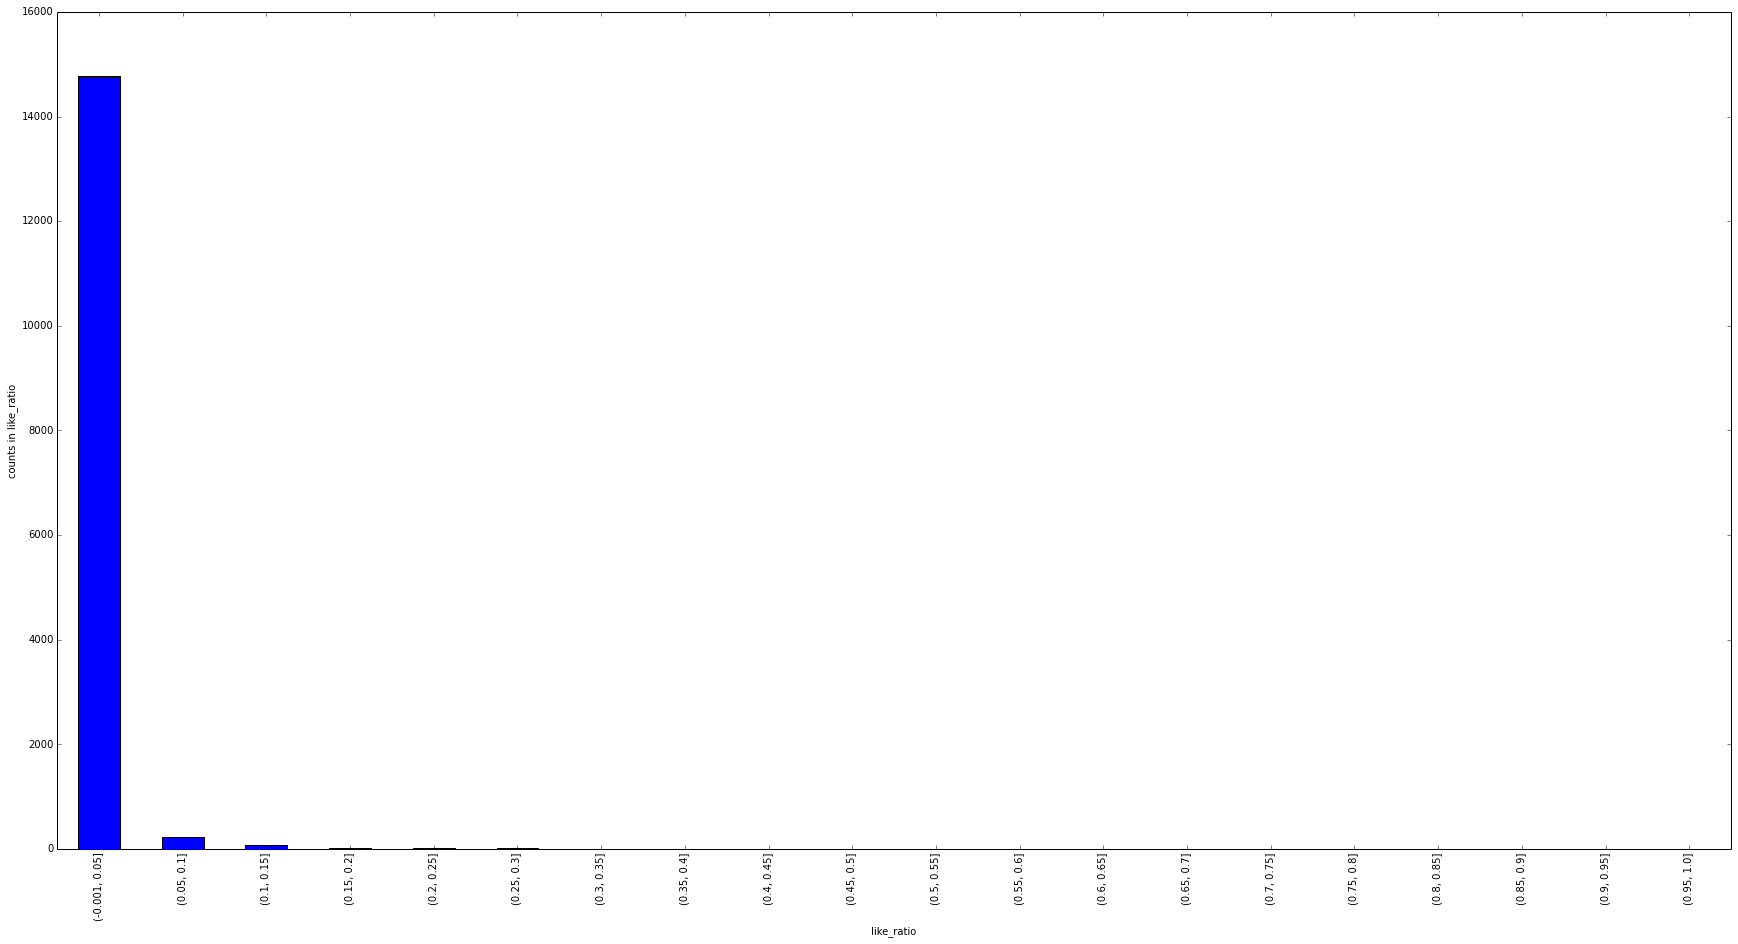

In [107]:
plot_data_cut(users, 'like_ratio', 20)

In [108]:
def follow_ratio_discretization(num):
    if 0 < num and num < 0.02:
        return 0
    elif 0.02 < num and num < 0.04:
        return 1
    elif 0.04 < num and num < 0.06:
        return 2
    else:
        return 3

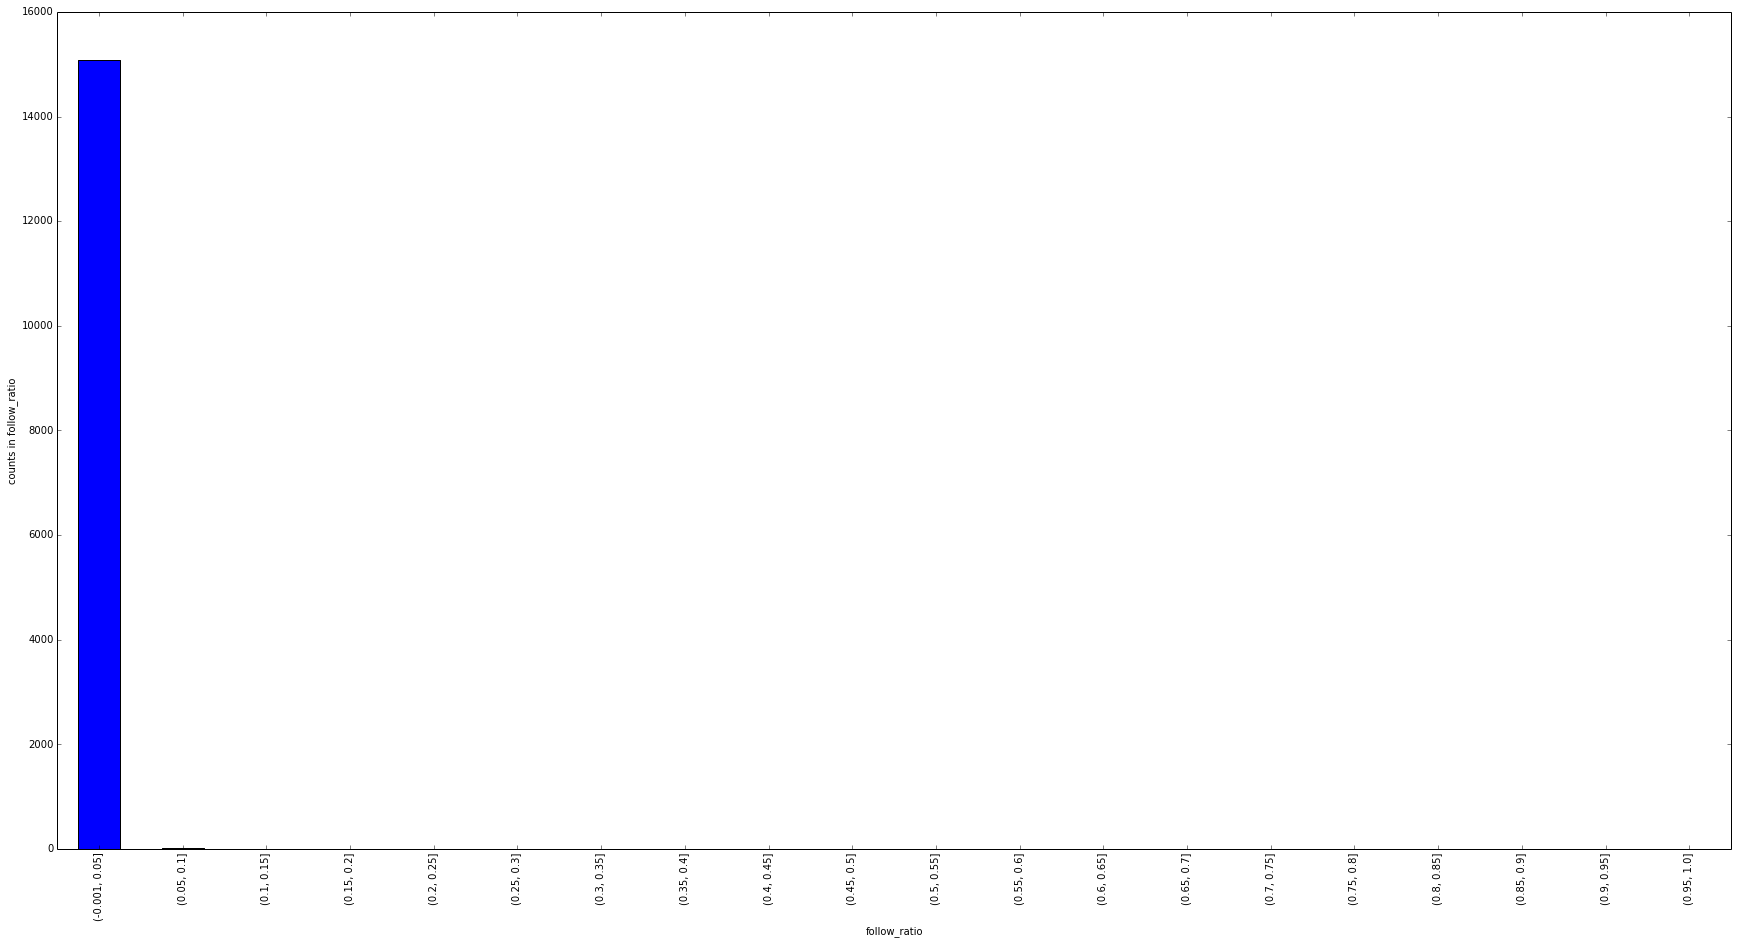

In [109]:
plot_data_cut(users, 'follow_ratio', 20)

In [110]:
def playing_ratio_discretization(num):
    if 0 < num and num < 0.2:
        return 0
    elif 0.2 < num and num < 0.4:
        return 1
    elif 0.4 < num and num < 0.6:
        return 2
    else:
        return 3

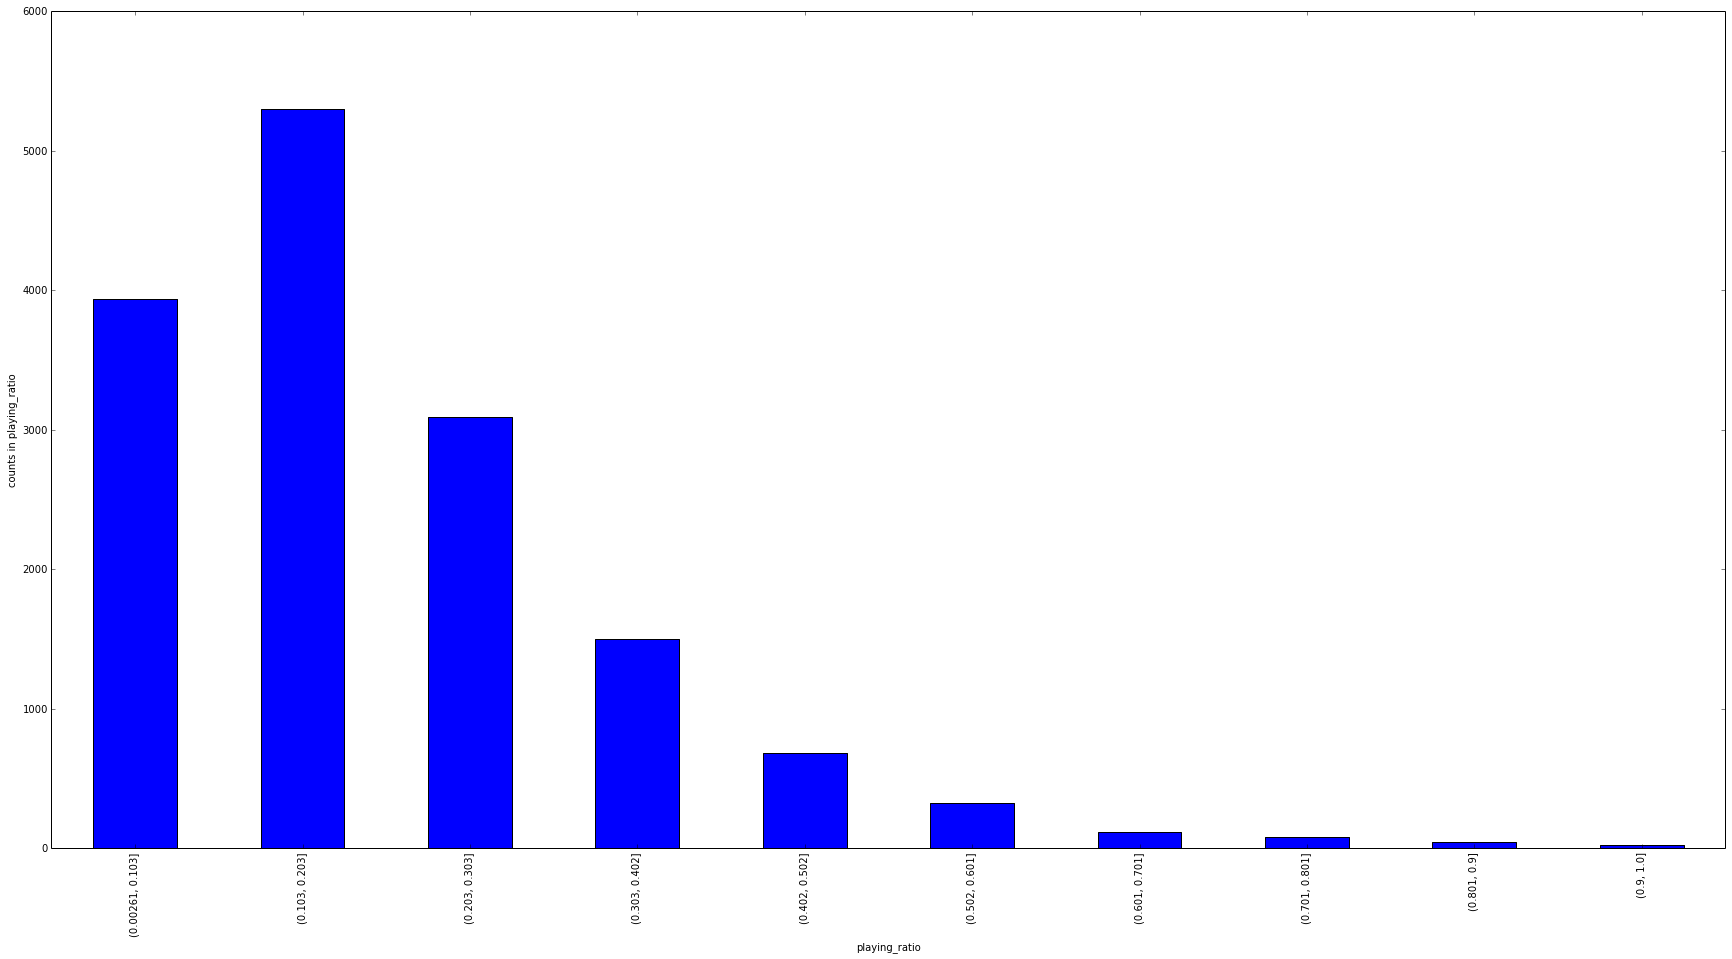

In [111]:
plot_data_cut(users, 'playing_ratio', 10)

In [112]:
def face_favor_discretization(num):
    if 0 < num and num < 1:
        return 0
    elif 1 < num and num < 2:
        return 1
    else:
        return 2

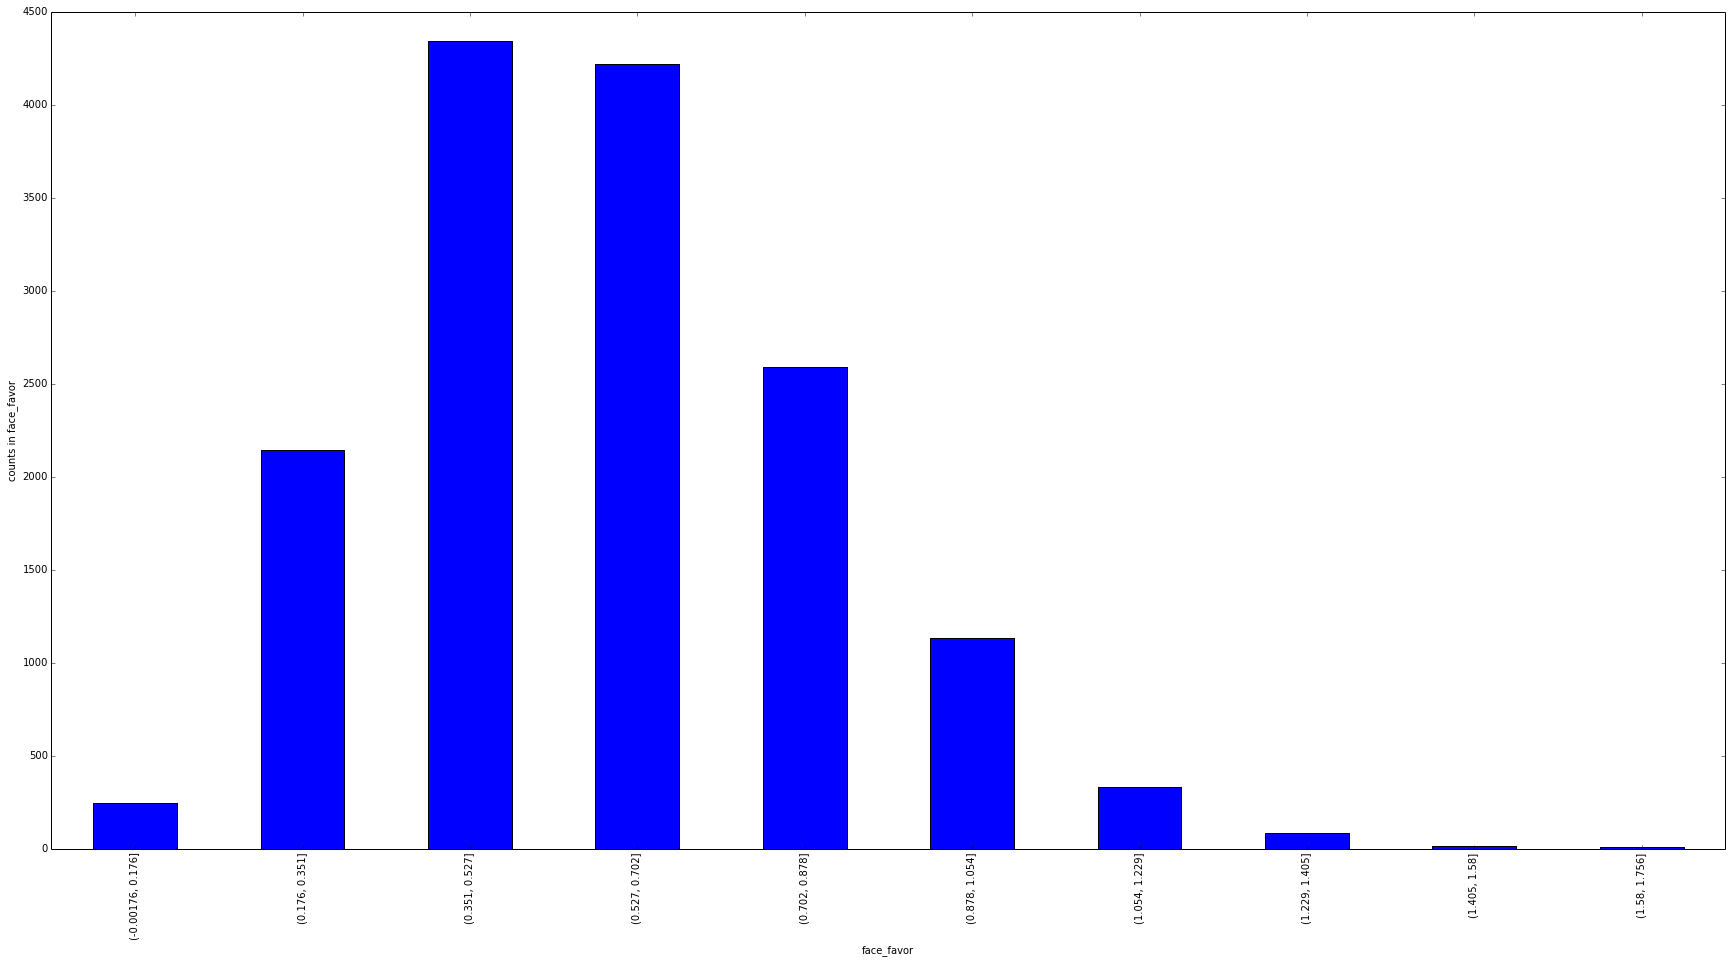

In [113]:
plot_data_cut(users, 'face_favor', 10)

In [114]:
def man_favor_discretization(num):
    if 0 < num and num < 1:
        return 0
    elif 1 < num and num < 2:
        return 1
    else:
        return 2

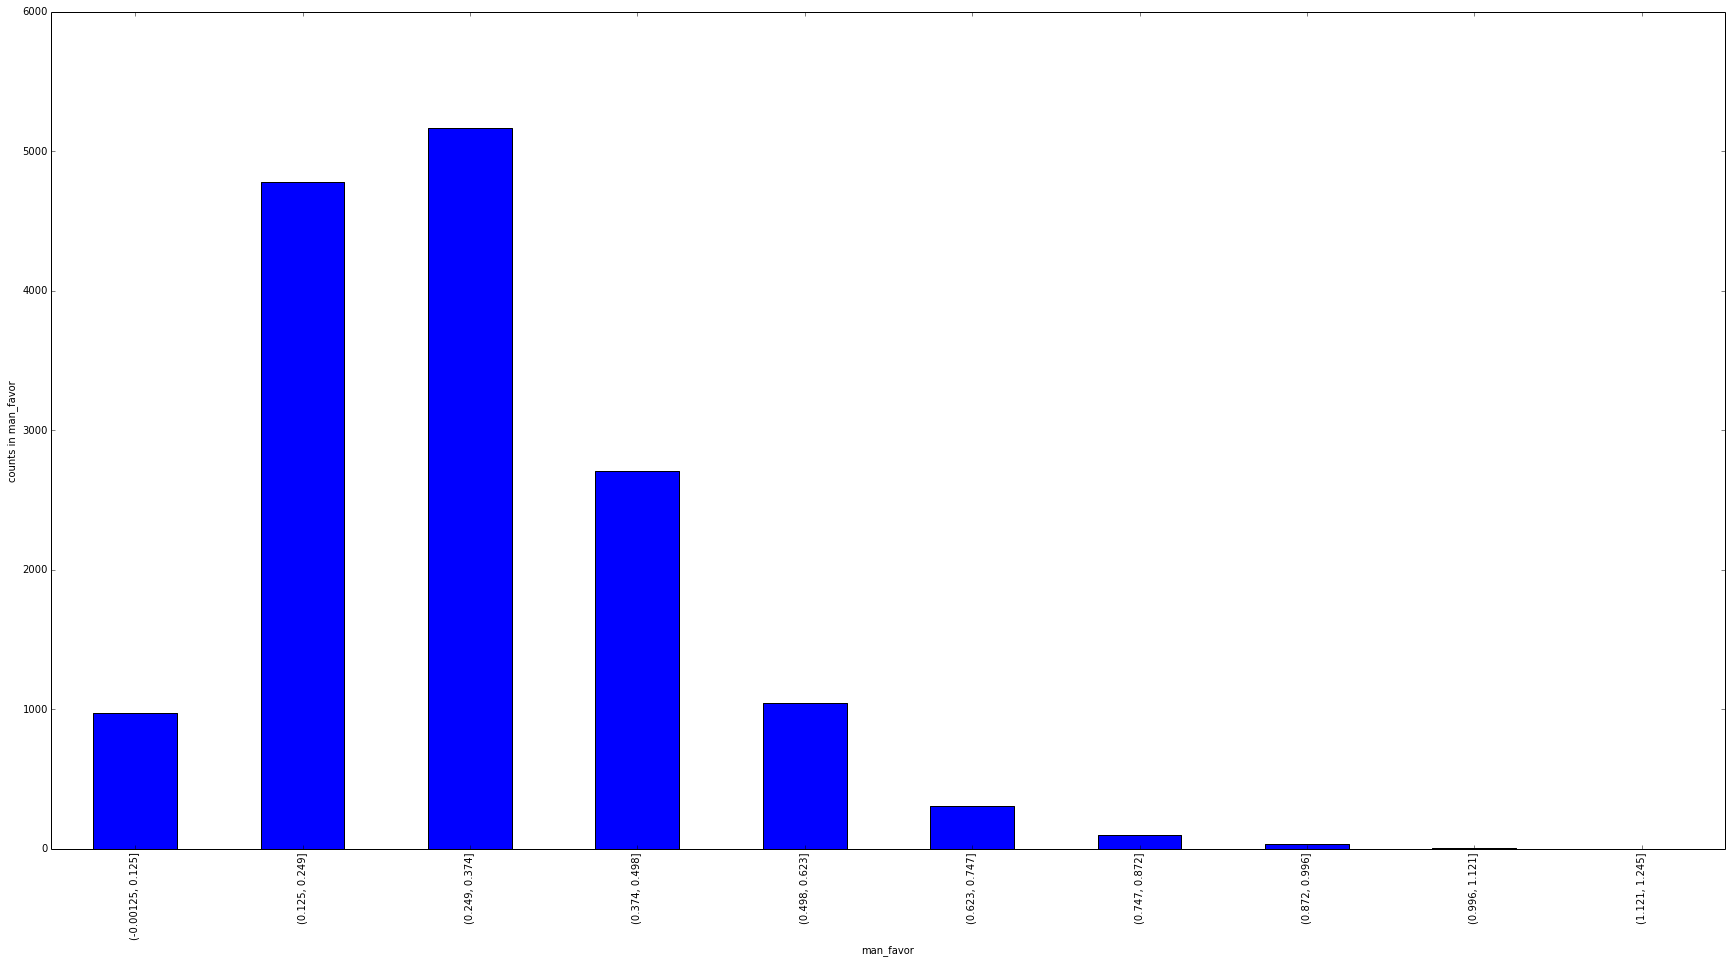

In [115]:
plot_data_cut(users, 'man_favor', 10)

In [116]:
def woman_favor_discretization(num):
    if 0 < num and num < 1:
        return 0
    elif 1 < num and num < 2:
        return 1
    else:
        return 2

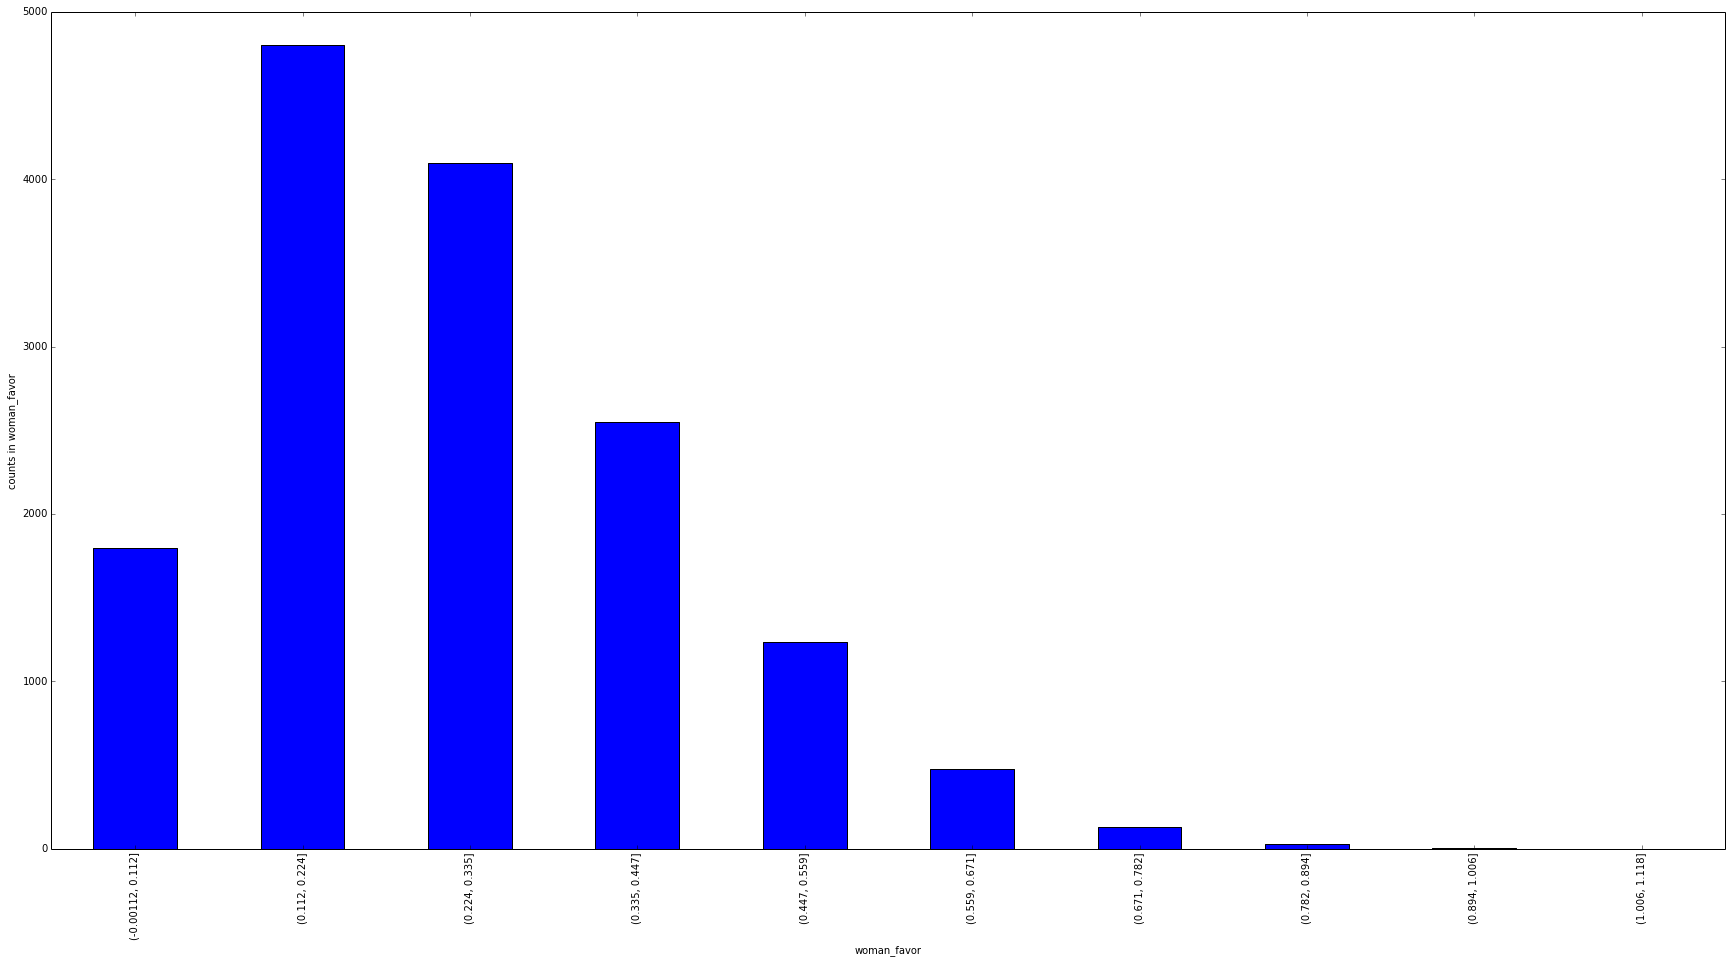

In [117]:
plot_data_cut(users, 'woman_favor', 10)

In [118]:
def man_cv_favor_discretization(num):
    if 0 < num and num < 0.02:
        return 0
    elif 0.02 < num and num < 0.04:
        return 1
    elif 0.04 < num and num < 0.06:
        return 2
    else:
        return 3

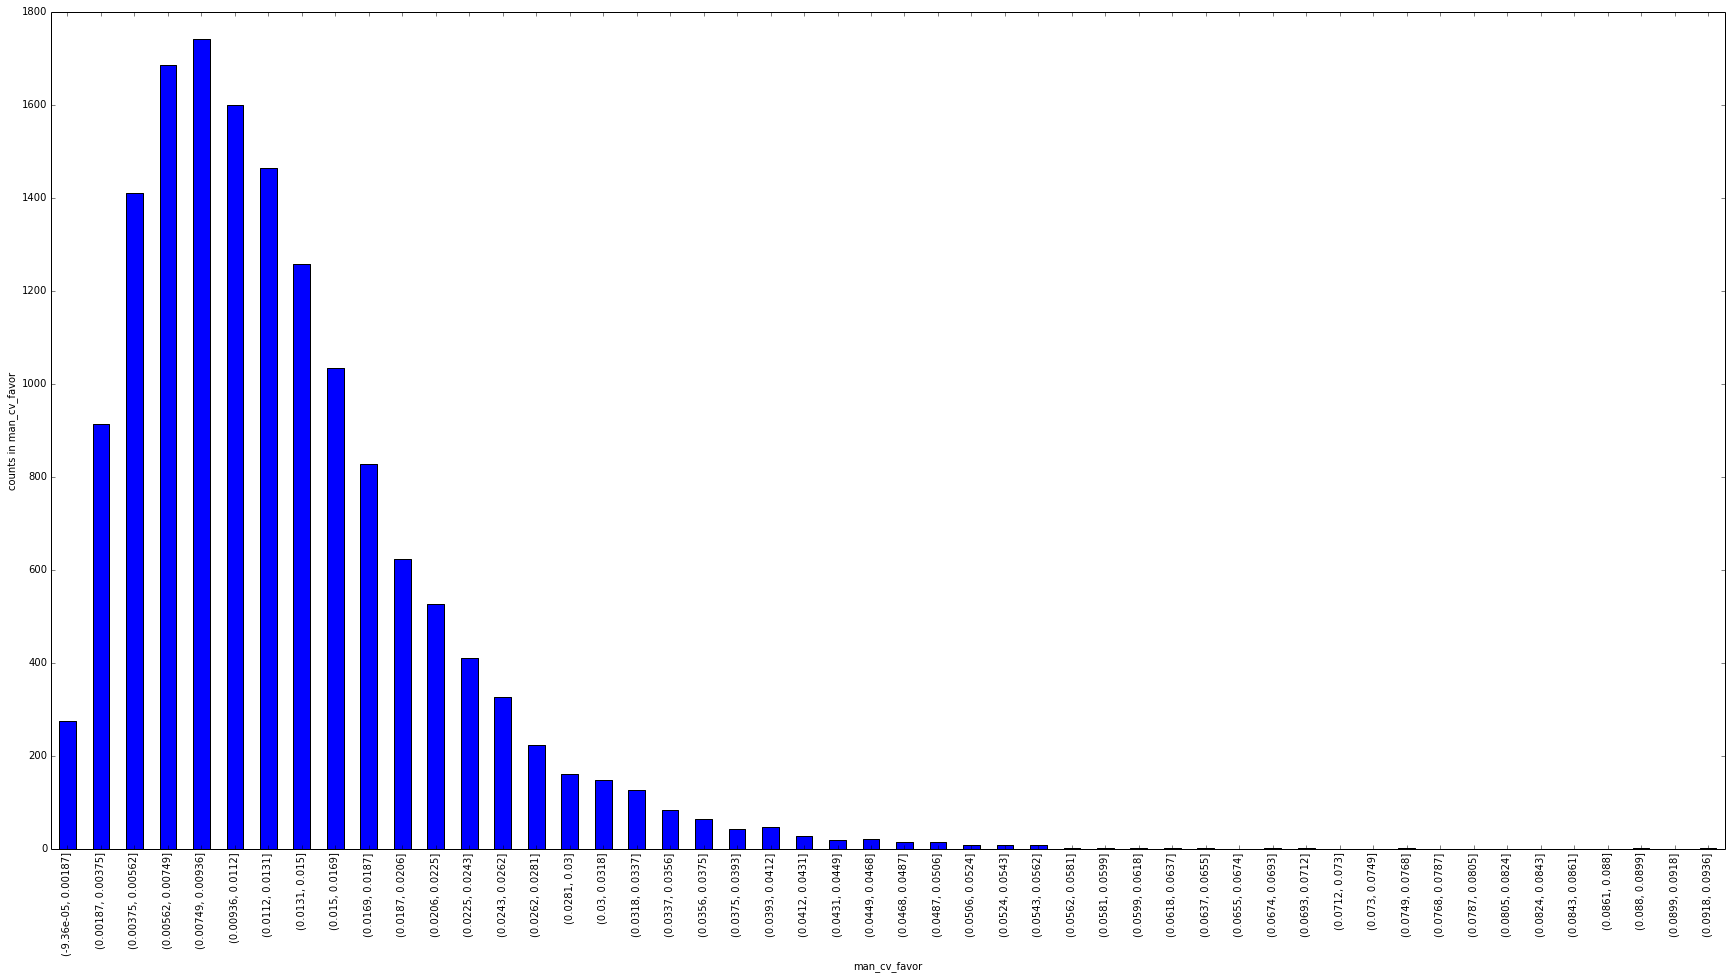

In [119]:
plot_data_cut(users, 'man_cv_favor', 50)

In [120]:
def woman_cv_favor_discretization(num):
    if 0 < num and num < 0.03:
        return 0
    elif 0.03 < num and num < 0.06:
        return 1
    elif 0.06 < num and num < 0.1:
        return 2
    else:
        return 3

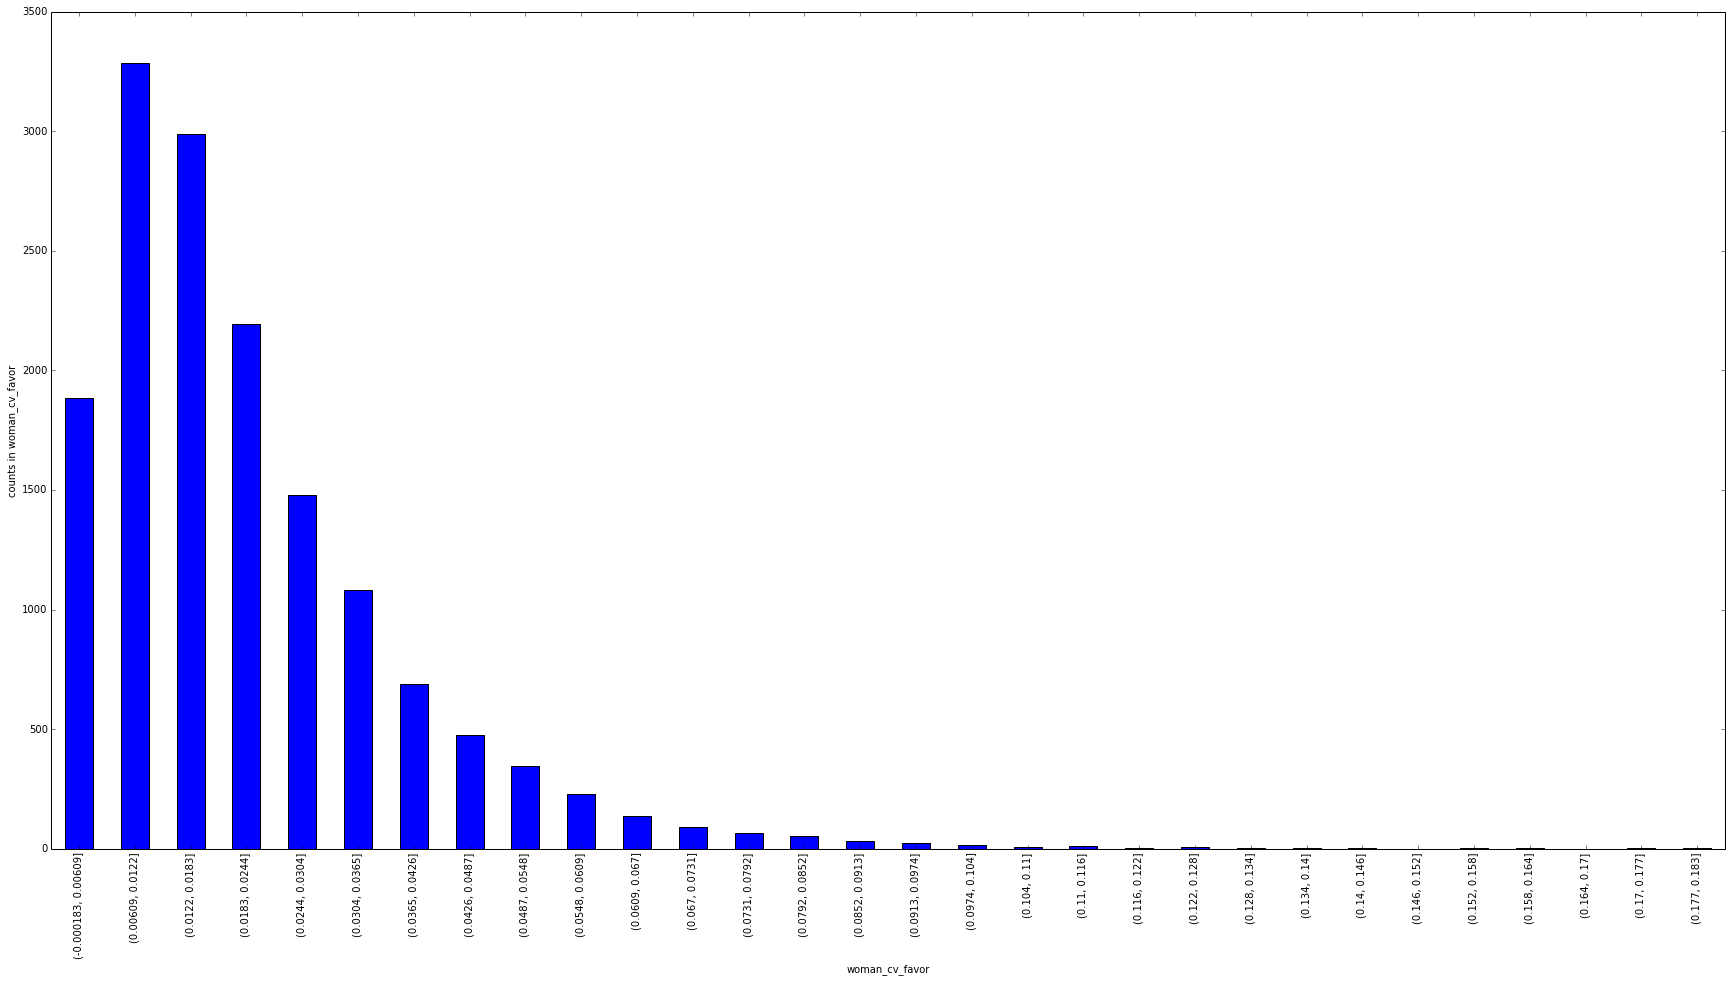

In [121]:
plot_data_cut(users, 'woman_cv_favor', 30)

In [122]:
def man_age_favor_discretization(num):
    if 0 < num and num < 4:
        return 0
    elif 4 < num and num < 8:
        return 1
    elif 8 < num and num < 12:
        return 2
    else:
        return 3

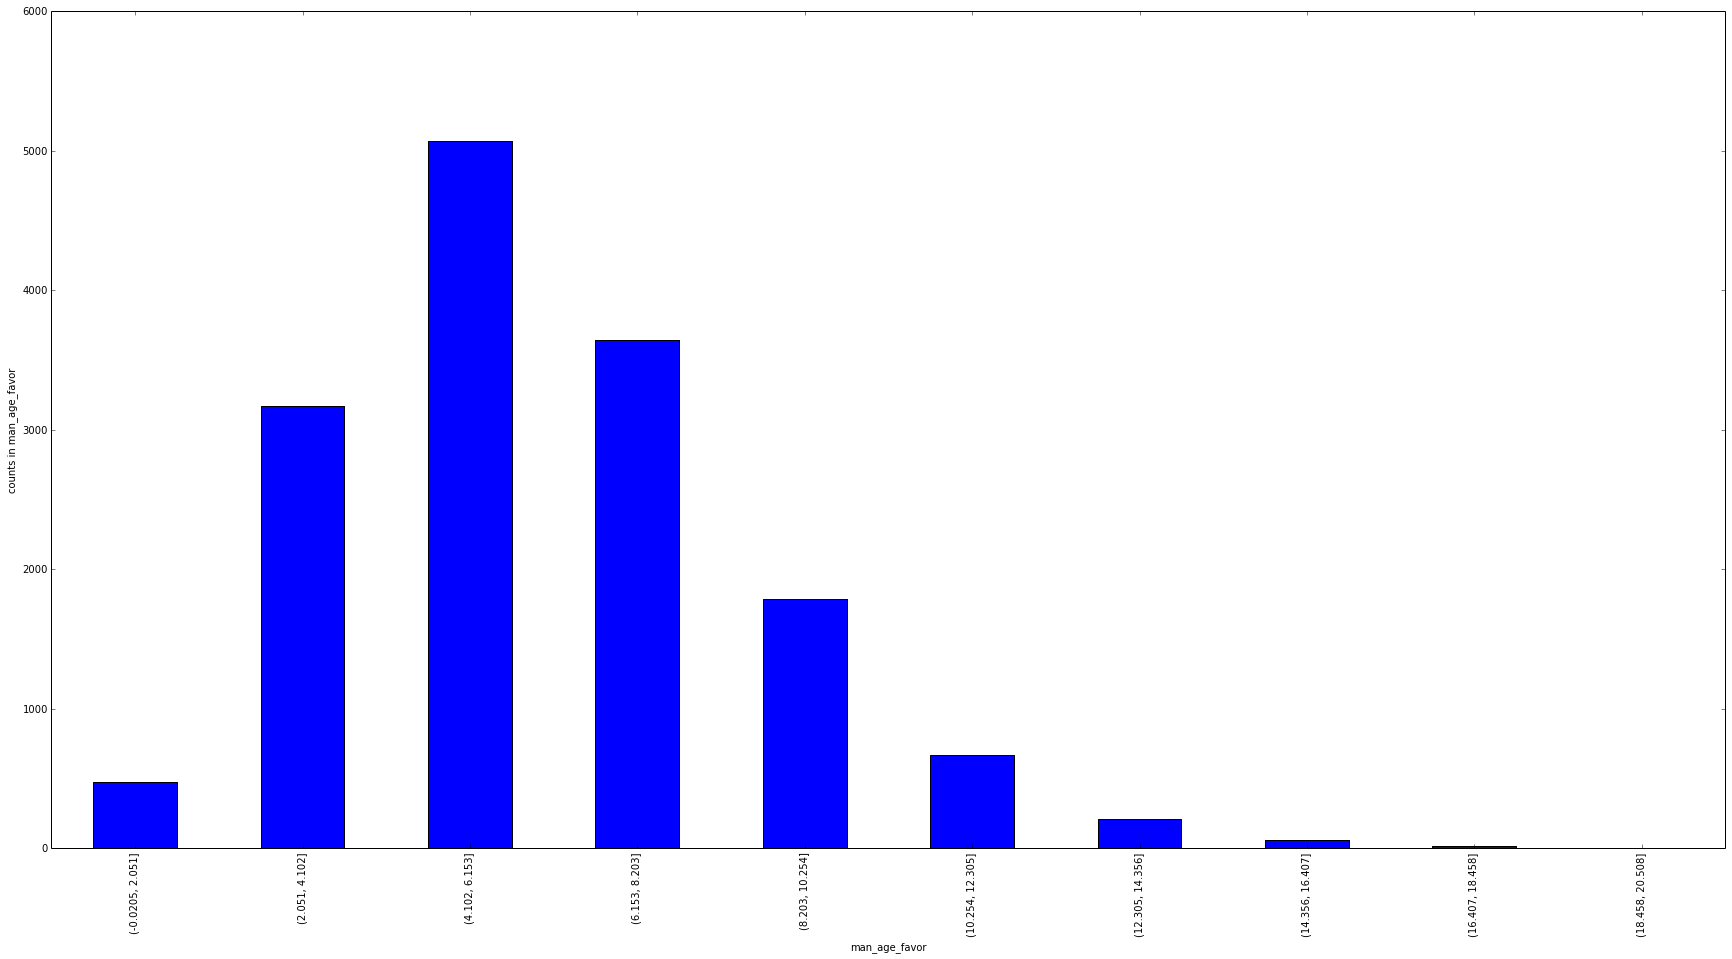

In [123]:
plot_data_cut(users, 'man_age_favor', 10)

In [124]:
def woman_age_favor_discretization(num):
    if 0 < num and num < 4:
        return 0
    elif 4 < num and num < 8:
        return 1
    elif 8 < num and num < 12:
        return 2
    else:
        return 3

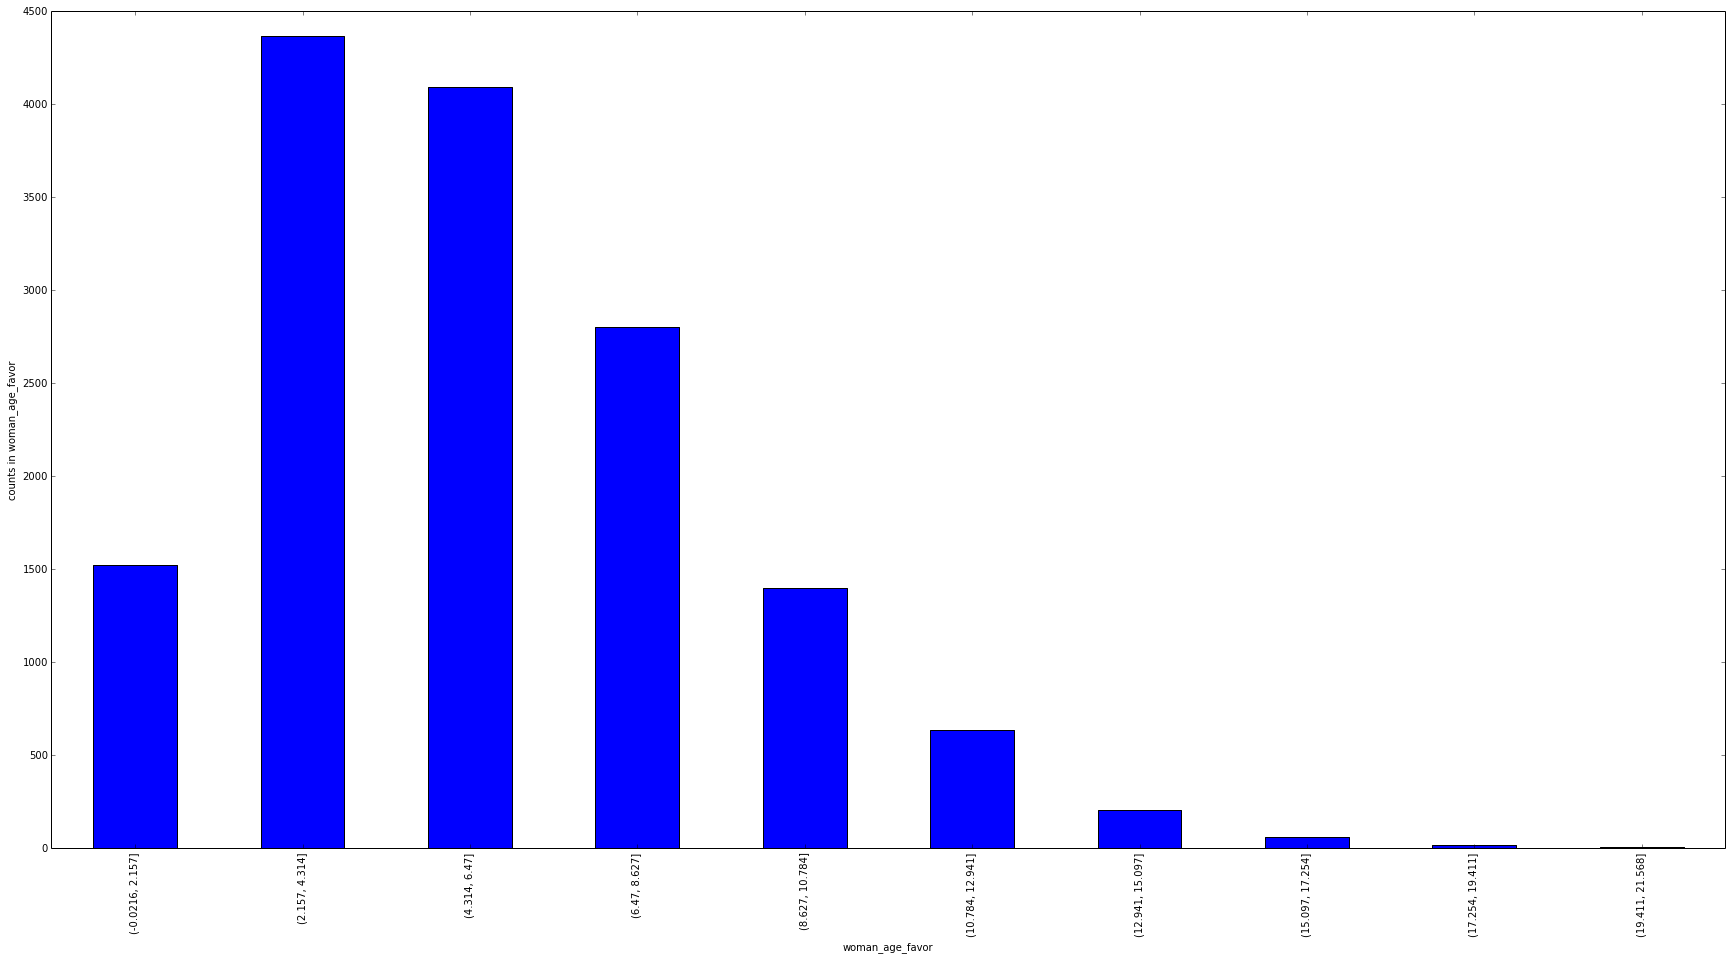

In [125]:
plot_data_cut(users, 'woman_age_favor', 10)

In [126]:
def man_yen_value_favor_discretization(num):
    if 0 < num and num < 10:
        return 0
    elif 10 < num and num < 20:
        return 1
    else:
        return 2

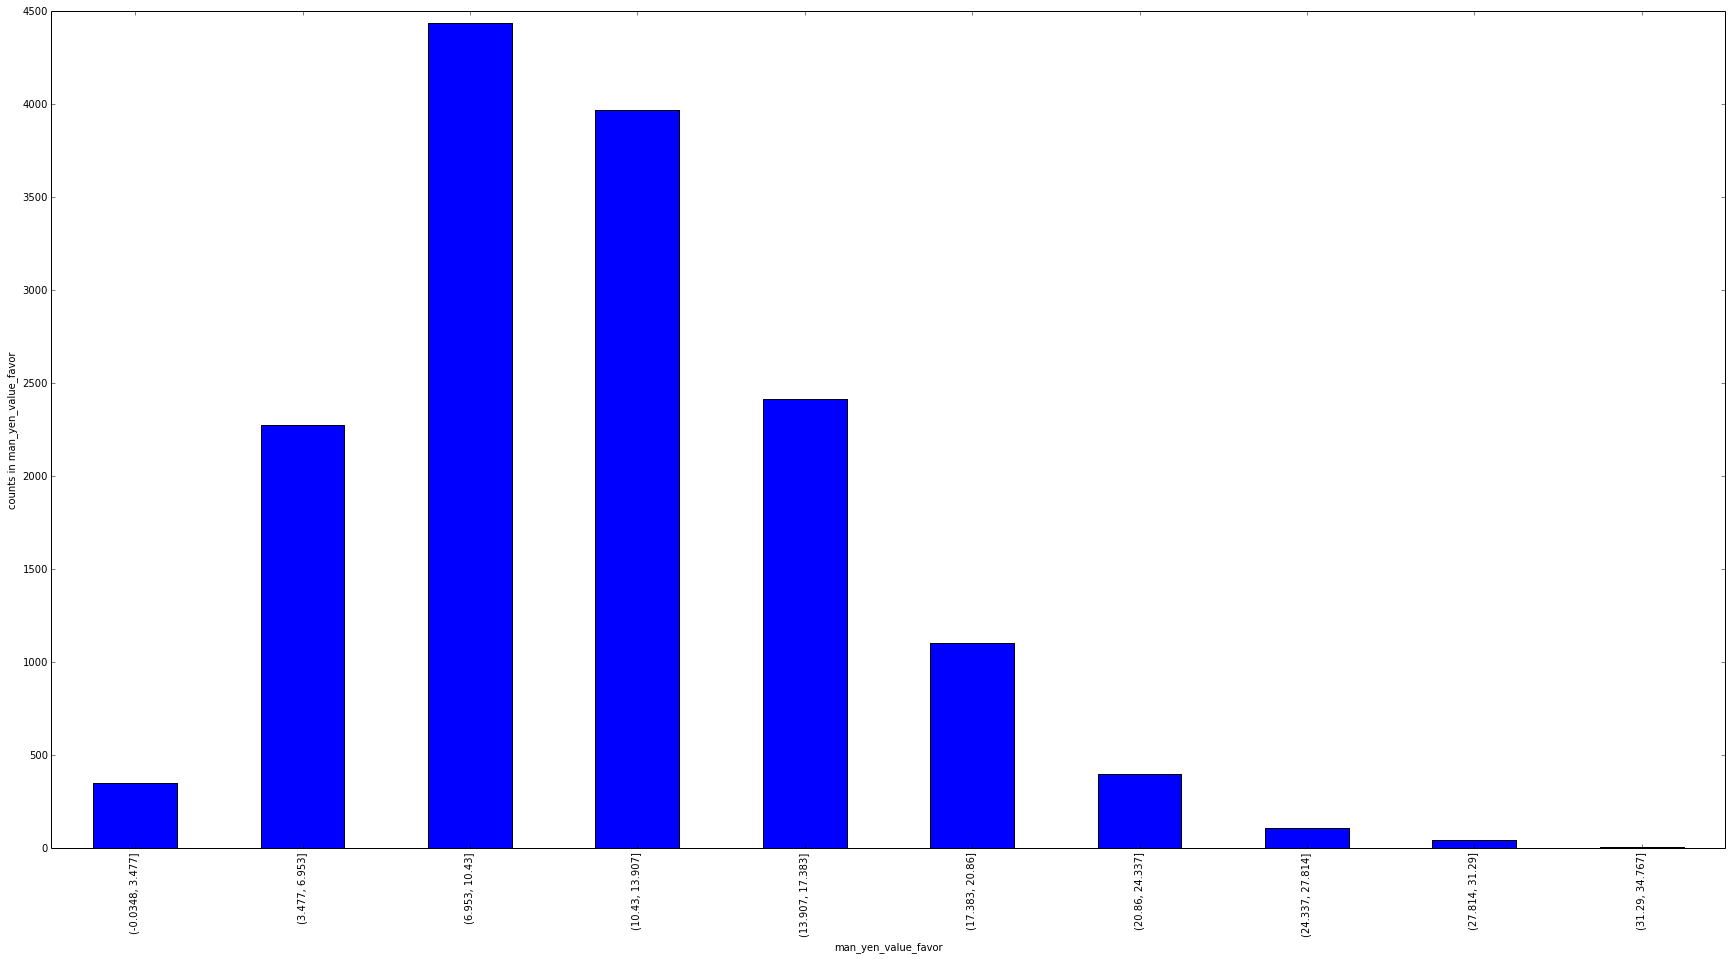

In [127]:
plot_data_cut(users, 'man_yen_value_favor', 10)

In [128]:
def woman_yen_value_favor_discretization(num):
    if 0 < num and num < 10:
        return 0
    elif 10 < num and num < 20:
        return 1
    elif 20 < num and num < 40:
        return 2
    else:
        return 3

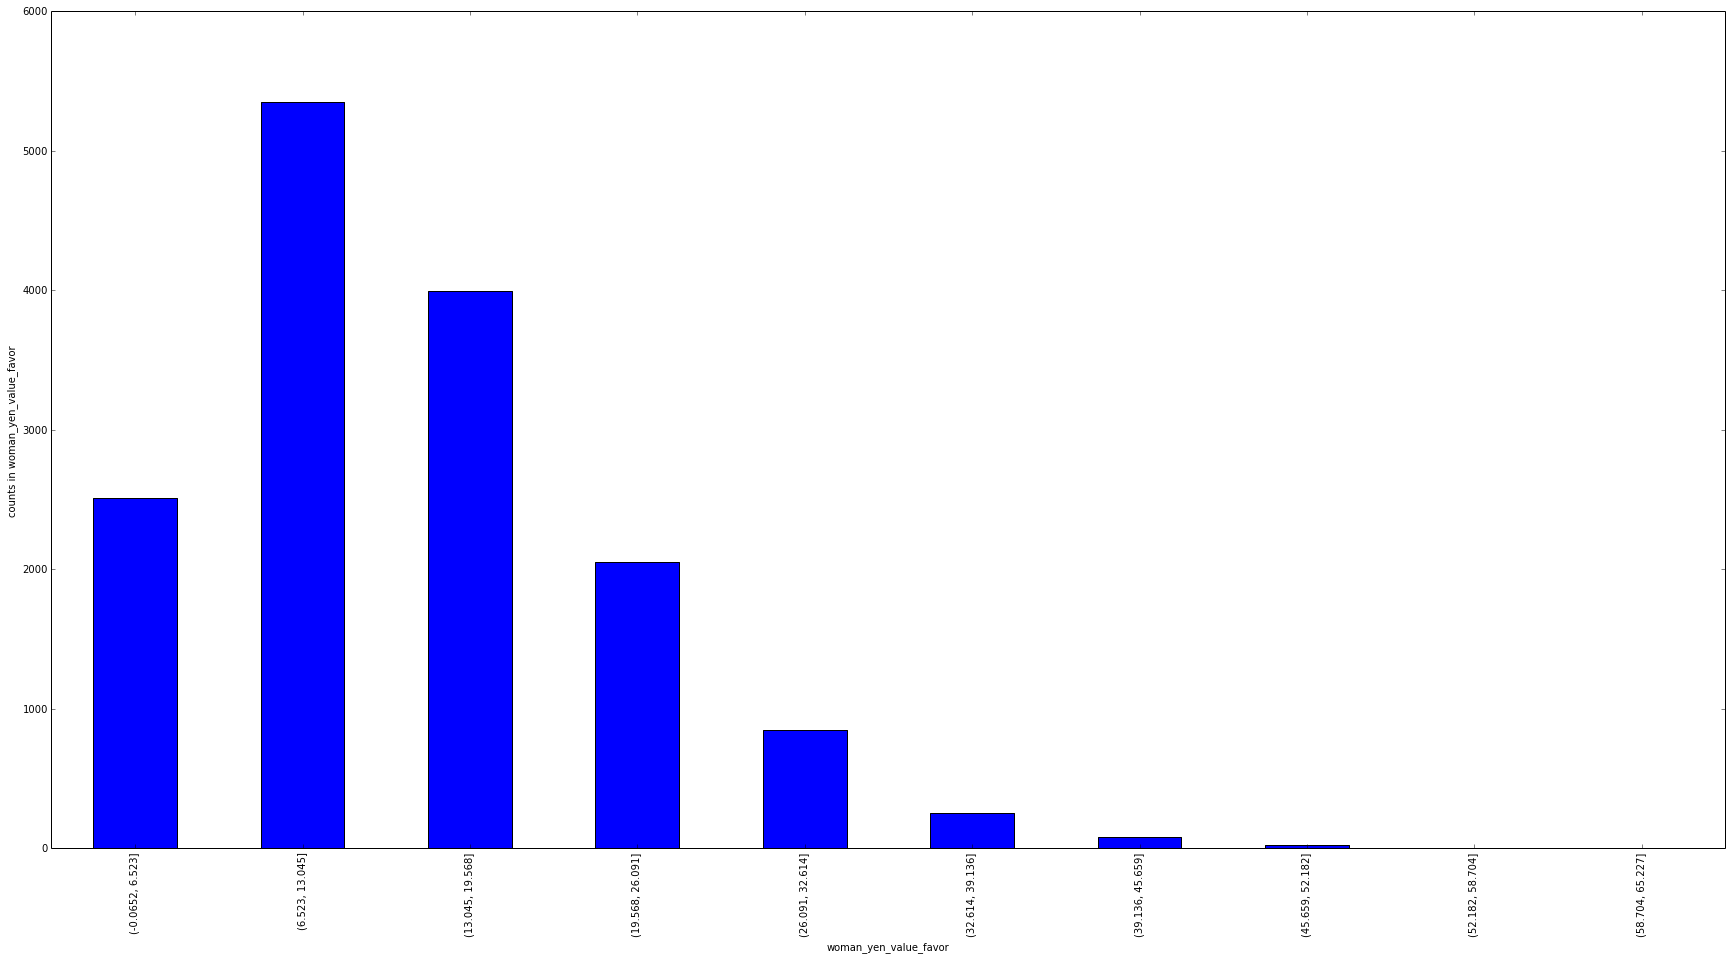

In [129]:
plot_data_cut(users, 'woman_yen_value_favor', 10)

In [130]:
users.head()

,user_id,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,click_ratio,like_ratio,follow_ratio,playing_ratio,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
0,1637,1736,365,4,0,4124,27726,0.210253,0.002304,0.000000,0.148741,0.997260,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
1,17470,477,82,0,1,1937,8586,0.171908,0.000000,0.002096,0.225600,0.426829,0.268293,0.158537,0.006262,0.014798,5.912602,3.987805,10.439024,10.829268
2,14148,852,139,2,1,1120,16928,0.163146,0.002347,0.001174,0.066163,0.726619,0.201439,0.525180,0.008571,0.051771,4.125899,10.139688,7.700000,25.859712
3,37431,355,128,4,1,2548,8752,0.360563,0.011268,0.002817,0.291133,0.484375,0.226562,0.257812,0.012066,0.018660,4.979167,5.050781,8.635417,14.738281
4,35273,2486,576,0,1,7228,35415,0.231698,0.000000,0.000402,0.204094,0.359375,0.194444,0.164931,0.007851,0.011083,4.123264,3.647569,7.314959,9.075087


# 构造数据集

In [131]:
import numpy as np
import scipy as sp
from scipy import sparse as ssp
from scipy.stats import spearmanr
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

In [132]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,face_num_class,have_face
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,False
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,False
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333,3,True
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,False
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0,False


In [133]:
user_item_train = pd.merge(user_item_train, users,
                          how='inner',
                          on=['user_id'])


In [134]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,playing_ratio,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749


In [135]:
user_item_train.fillna(0, inplace=True)

In [136]:
user_item_train.head()

,user_id,photo_id,click,like,follow,time,playing_time,duration_time,exposure_num,face_num,...,playing_ratio,face_favor,man_favor,woman_favor,man_cv_favor,woman_cv_favor,man_age_favor,woman_age_favor,man_yen_value_favor,woman_yen_value_favor
0,1637,6484142,0,0,0,761036604603,0,11,13,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
1,1637,4647664,0,0,0,761035501863,0,11,2,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
2,1637,4994626,1,0,0,761036933553,11,10,34,3.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
3,1637,4416881,0,0,0,761119247892,0,9,1,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749
4,1637,2597756,0,0,0,761119421332,0,11,2,0.0,...,0.148741,0.99726,0.391781,0.605479,0.014004,0.028724,7.516667,11.586758,15.523516,27.644749


In [137]:
user_item_train.columns

Index([u'user_id', u'photo_id', u'click', u'like', u'follow', u'time',
       u'playing_time', u'duration_time', u'exposure_num', u'face_num',
       u'man_num', u'woman_num', u'man_scale', u'woman_scale', u'human_scale',
       u'man_avg_age', u'woman_avg_age', u'human_avg_age', u'man_avg_attr',
       u'woman_avg_attr', u'human_avg_attr', u'face_num_class', u'have_face',
       u'browse_num', u'click_num', u'like_num', u'follow_num', u'playing_sum',
       u'duration_sum', u'click_ratio', u'like_ratio', u'follow_ratio',
       u'playing_ratio', u'face_favor', u'man_favor', u'woman_favor',
       u'man_cv_favor', u'woman_cv_favor', u'man_age_favor',
       u'woman_age_favor', u'man_yen_value_favor', u'woman_yen_value_favor'],
      dtype='object')

In [114]:
user_item_train[(user_item_train['user_id']==26380) & (user_item_train['click']==1)]

,user_id,photo_id,click,like,follow,time,playing_time,duration_time
7480116,26380,6718067,1,0,0,761117417330,1,17
7480224,26380,4360556,1,0,0,761107341342,5,10
7480254,26380,6926175,1,0,0,761112254838,14,17
7480330,26380,4776932,1,0,0,761106486958,9,17
7480347,26380,6426487,1,0,0,761040759314,9,17
7480375,26380,1905277,1,0,0,761073896432,8,7
7480391,26380,5354909,1,0,0,761098719740,8,6
7480392,26380,2170768,1,0,0,761024571864,1,17
7480463,26380,1829944,1,0,0,761112100057,6,17
7480504,26380,6949166,1,0,0,761117907334,10,9


In [ ]:
#?? 非常奇葩。。。无法直接要用xx['face_num'] 这个Series 作为一列给DataFrame当一列，赋值之是错误的值，并不是xx['face_num']
# users['face_favor'] = xx['face_num'].values

In [138]:
import gc
gc.collect()


5351

In [139]:
user_item_test.head()

,user_id,photo_id,time,duration_time
0,29999,8154819,761158905921,17
1,29999,8374672,761163438550,9
2,29999,7987126,761143659968,11
3,29999,7912672,761159000400,17
4,29999,9062638,761163738888,11


In [140]:
user_item_test = pd.merge(user_item_test, users,
                          how='inner',
                          on=['user_id'])

user_item_test = pd.merge(user_item_test, photo_data,
                         how='left',
                         on=['photo_id'])

In [141]:
user_item_test.head()

,user_id,photo_id,time,duration_time,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,...,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr,face_num_class,have_face
0,29999,8154819,761158905921,17,267,90,1,3,943,4845,...,0.0077,0.0190,31.0,27.0,29.0,45.0,48.0,46.5,2,True
1,29999,8374672,761163438550,9,267,90,1,3,943,4845,...,0.0000,0.0207,28.0,0.0,28.0,40.0,0.0,40.0,1,True
2,29999,7987126,761143659968,11,267,90,1,3,943,4845,...,0.1103,0.1103,0.0,27.0,27.0,0.0,53.0,53.0,1,True
3,29999,7912672,761159000400,17,267,90,1,3,943,4845,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
4,29999,9062638,761163738888,11,267,90,1,3,943,4845,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0,False


In [142]:
set(list(user_item_train.columns.values)) - set(list(user_item_test.columns.values))

{'click', 'follow', 'like', 'playing_time'}

In [143]:
inter = set(list(user_item_train.columns.values)) & set(list(user_item_test.columns.values))

In [144]:
user_action_features = ['browse_num', 'click_num', 'like_num', 'follow_num', 'playing_sum','duration_sum', 'click_ratio', 'like_ratio', 'follow_ratio', 'playing_ratio']
    
face_features = ['face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'human_scale', 'man_avg_age', 'woman_avg_age', 'human_avg_age',  'man_avg_attr', 'woman_avg_attr', 'human_avg_attr']
    
    
user_face_favor_features = ['face_favor', 'man_favor', 'woman_favor', 'man_cv_favor', 'woman_cv_favor', 'man_age_favor', 'woman_age_favor', 'man_yen_value_favor', 'woman_yen_value_favor']
    
    
id_features = ['user_id', 'photo_id']
time_features = ['time', 'duration_time']

photo_features = ['exposure_num', 'face_num_class', 'have_face'] + face_features
user_features = user_action_features + user_face_favor_features

y_label = ['click']

all_features = id_features + time_features + user_features + photo_features


In [145]:
len(inter)

38

In [146]:
len(all_features)

38

In [147]:
inter - set(all_features)

set()

In [148]:
def normalize_min_max(df, features):
    df[features] = df[features].apply(lambda x: (x-x.min())/(x.max()-x.min()))

def normalize_z_score(df, features):
    df[features] = df[features].apply(lambda x: (x-x.mean())/x.std())

In [149]:
num_train, num_test = user_item_train.shape[0], user_item_test.shape[0]

In [150]:
user_item_data = pd.concat([user_item_train[all_features], user_item_test[all_features]])

In [151]:
user_item_data.head()

,user_id,photo_id,time,duration_time,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,...,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,1637,6484142,761036604603,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,1637,4647664,761035501863,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,1637,4994626,761036933553,10,1736,365,4,0,4124,27726,...,0.0,0.3959,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333
3,1637,4416881,761119247892,9,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,1637,2597756,761119421332,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [152]:
# user_item_data['datetime'] = pd.to_datetime(user_item_data['time']-8*3600*1000, utc=True, unit='ms')

In [153]:
user_item_data.head()

,user_id,photo_id,time,duration_time,browse_num,click_num,like_num,follow_num,playing_sum,duration_sum,...,woman_num,man_scale,woman_scale,human_scale,man_avg_age,woman_avg_age,human_avg_age,man_avg_attr,woman_avg_attr,human_avg_attr
0,1637,6484142,761036604603,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,1637,4647664,761035501863,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,1637,4994626,761036933553,10,1736,365,4,0,4124,27726,...,0.0,0.3959,0.0,0.3959,26.333333,0.0,26.333333,48.333333,0.0,48.333333
3,1637,4416881,761119247892,9,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,1637,2597756,761119421332,11,1736,365,4,0,4124,27726,...,0.0,0.0000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.0,0.000000


False

In [ ]:
# user_item_data['datetime_class'] = user_item_data['datetime'].apply(datetime_discretization)

In [ ]:
user_item_data.head()

In [ ]:
plot_data_cut(user_item_data, 'datetime', 48)

In [ ]:
plot_data_cut(user_item_data.iloc[:num_train,:], 'datetime', 48)

In [ ]:
plot_data_cut(user_item_data.iloc[num_train:,:], 'datetime', 12)

In [ ]:
norm_features = ['time', 'duration_sum', 'exposure_num', 'click_num', 'playing_sum', 'woman_favor', 'woman_age_favor', 'woman_scale', 'woman_cv_favor', 'human_scale', 'browse_num', 'duration_sum']
normalize_min_max(user_item_data, norm_features)
# normalize_z_score(user_item_data, norm_features)

In [ ]:
user_item_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

df_num_corr = user_item_train.corr()['click'][:-1] # -1 because the latest row is SalePrice


golden_features_list = df_num_corr[abs(df_num_corr) > 0.03].sort_values(ascending=False)
print("There is {} strongly correlated values with click:\n{}".format(len(golden_features_list), golden_features_list))

list(golden_features_list.index.values)

# 特征处理
## 类别特征和Onehot
onehot 和 embedding 特征对于训练神经网络特别有用, onehot 对于线性模型也是非常有用的，它相当于让线性模型变得非线性，通过逻辑组合特征，维度升高之后，能够实现非线性数据的划分，如果直接使用类别特征，LR可能无法分类。
>At first, onehot encoding is one of the conversion method for categorical data, and good representation of the data on neural network learning.(except random forest and other method which can use the categorical data.

- [Onehot Conversion for Categorical Data](http://www.renom.jp/notebooks/preprocessing/onehot/notebook.html)

In [155]:
user_item_data.columns.values

array(['user_id', 'photo_id', 'time', 'duration_time', 'browse_num',
       'click_num', 'like_num', 'follow_num', 'playing_sum',
       'duration_sum', 'click_ratio', 'like_ratio', 'follow_ratio',
       'playing_ratio', 'face_favor', 'man_favor', 'woman_favor',
       'man_cv_favor', 'woman_cv_favor', 'man_age_favor',
       'woman_age_favor', 'man_yen_value_favor', 'woman_yen_value_favor',
       'exposure_num', 'face_num_class', 'have_face', 'face_num',
       'man_num', 'woman_num', 'man_scale', 'woman_scale', 'human_scale',
       'man_avg_age', 'woman_avg_age', 'human_avg_age', 'man_avg_attr',
       'woman_avg_attr', 'human_avg_attr'], dtype=object)

# 特征选取
 - 皮尔逊相关系数
 - Gini 系数
 - 信息增益

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['man_num'])
print('click - man_num: %s' % (str(corrscore)))

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['man_num'])
print('click - man_num: %s' % (str(corrscore)))

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_scale'])
print('click - woman_scale: %s' % (str(corrscore)))

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_num'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_avg_attr'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_avg_age'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['woman_scale'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['click_ratio'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['like_ratio'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['follow_ratio'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['playing_ratio'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['click_num'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['like_num'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['follow_num'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['playing_sum'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['time'])
print(corrscore)

In [ ]:
corrscore = spearmanr(user_item_train['click'], user_item_train['display_num'])
print(corrscore)

In [ ]:
user_item_train.info()

In [ ]:
user_item_train.head()

In [ ]:
y = user_item_train['click'].values

In [ ]:
face_features = ['face_num', 'man_num', 'woman_num', 'man_scale', 'woman_scale', 'man_avg_age', 'woman_avg_age', 'man_avg_attr', 'woman_avg_attr']
user_face_favor = ['face_favor', 'man_favor', 'woman_favor', 'man_cv_favor', 'woman_cv_favor', 'man_age_favor', 'woman_age_favor', 'man_yen_value_favor', 'woman_yen_value_favor']
input_features = ['user_id', 'photo_id', 'click', 'time', 'duration_time'] + user_features + face_features + user_face_favor
user_item_train = user_item_train[input_features]

In [ ]:
user_item_train.head()

离散特征的编码分为两种情况：
 - 离散特征的取值之间没有大小的意义，比如color：[red,blue],那么就使用one-hot编码
 - 离散特征的取值有大小的意义，比如size:[X,XL,XXL],那么就使用数值的映射{X:1,XL:2,XXL:3}

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
t = user_item_test.user_id.astype(str).str.get_dummies()

In [ ]:
input_features

In [ ]:
features = list(set(input_features) - set(['user_id', 'photo_id', 'click']))
X = user_item_train.as_matrix(features)

In [ ]:
np.sum(np.isnan(X))

In [182]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [183]:
del user_item_train
gc.collect()

666

In [184]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score
from sklearn import svm
from xgboost import XGBClassifier


In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [186]:
%%time
clf = LogisticRegression(C=1,random_state=1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8037492329949165
CPU times: user 26 s, sys: 3.71 s, total: 29.7 s
Wall time: 31 s


In [104]:
%%time
scores = cross_val_score(clf, X, y, cv=5)
print(scores)

[0.80415777 0.80431317 0.80208273 0.80400205 0.80444392]
CPU times: user 1min 28s, sys: 16.9 s, total: 1min 45s
Wall time: 1min 48s


In [105]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.00)


In [106]:
%%time
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=9)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8041721872341516
CPU times: user 18min 22s, sys: 11.4 s, total: 18min 33s
Wall time: 18min 34s


In [187]:
%%time
clf = XGBClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8048674983698638
CPU times: user 8min 40s, sys: 3.96 s, total: 8min 44s
Wall time: 8min 46s


/Library/Python/2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [84]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.7580381331697056
CPU times: user 1min 58s, sys: 312 ms, total: 1min 59s
Wall time: 1min 59s


In [85]:
%%time
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.8034704677008753
CPU times: user 3min 35s, sys: 12 ms, total: 3min 35s
Wall time: 3min 35s


In [45]:
# %%time
# clf = svm.SVC(kernel="linear", C=0.025)
# clf.fit(X_train, y_train)
# print(clf.score(X_test, y_test))
# 无法收敛？

In [86]:
%%time
param_grid = {
              'C': [1, 10, 100, 500, 1000],
             }

# est = GradientBoostingClassifier({'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 9})
# this may take some minutes
gs_cv = GridSearchCV(LogisticRegression(), param_grid).fit(X_train, y_train)
print(gs_cv.best_params_)


# best hyperparameter setting

# est.fit(X_train, y_train)
print(accuracy_score(y_test, gs_cv.predict(X_test)))

{'C': 1}
0.8031981108043981
CPU times: user 1min 21s, sys: 6.28 s, total: 1min 28s
Wall time: 1min 20s


Logistic Regression             测试集acc/recall:  0.803198110804/ 0.547419984411 训练集acc/recall:  0.803452529719/ 0.803452529719
Decision Tree                   测试集acc/recall:  0.803233356991/ 0.548200542239 训练集acc/recall:  0.803756528565/ 0.803756528565
Random Forest                   测试集acc/recall:  0.797509055867/ 0.500083824726 训练集acc/recall:  0.798000176231/ 0.798000176231
AdaBoost                        测试集acc/recall:  0.803470467701/ 0.544536245292 训练集acc/recall:  0.803993639655/ 0.803993639655
Gradient Boosting Decision Tree 测试集acc/recall:  0.803774866585/ 0.541911642983 训练集acc/recall:  0.804413390368/ 0.804413390368


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

XGBoost                         测试集acc/recall:  0.803713986808/  0.54087891739 训练集acc/recall:  0.804273206447/ 0.804273206447
Logistic Regression has no feture_importances_
Decision Tree特征权值分布为: 
1. feature 3 (0.982352)
2. feature 4 (0.017400)
3. feature 11 (0.000248)
4. feature 10 (0.000000)
5. feature 9 (0.000000)
6. feature 8 (0.000000)
7. feature 7 (0.000000)
8. feature 6 (0.000000)
9. feature 5 (0.000000)
10. feature 2 (0.000000)
11. feature 1 (0.000000)
12. feature 0 (0.000000)
Random Forest特征权值分布为: 
1. feature 3 (0.326419)
2. feature 0 (0.170496)
3. feature 11 (0.142327)
4. feature 9 (0.086825)
5. feature 5 (0.070664)
6. feature 10 (0.067439)
7. feature 6 (0.047288)
8. feature 2 (0.043262)
9. feature 4 (0.029392)
10. feature 7 (0.008334)
11. feature 8 (0.003850)
12. feature 1 (0.003704)
AdaBoost特征权值分布为: 
1. feature 3 (0.720000)
2. feature 8 (0.140000)
3. feature 4 (0.140000)
4. feature 11 (0.000000)
5. feature 10 (0.000000)
6. feature 9 (0.000000)
7. feature 7 (0.000000)
8. feat

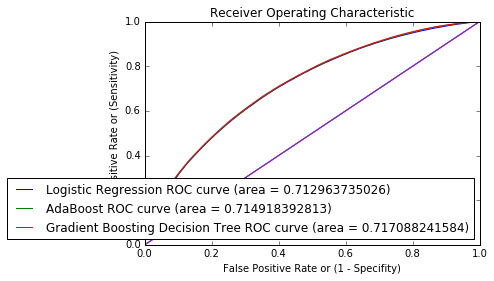

In [89]:
%%time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score, accuracy_score

from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# "Linear SVM", "RBF SVM",
names = ["Logistic Regression",  
         "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting Decision Tree", "XGBoost"]
classifiers = [
    LogisticRegression(C=1),
#     svm.SVC(kernel="linear", C=0.025),
#     svm.SVC(gamma=0.01, C=10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=9),
    XGBClassifier()]

for name, clf in zip(names,classifiers):
    clf.fit(X_train, y_train)
    print("{:31} 测试集acc/recall: {:15}/{:15} 训练集acc/recall: {:15}/{:15}".format(name, 
        accuracy_score(y_test, clf.predict(X_test)), recall_score(y_test, clf.predict(X_test), average='macro'), 
        accuracy_score(y_train, clf.predict(X_train)), recall_score(y_train, clf.predict(X_train), average='micro')))
    
for name, clf in zip(names, classifiers):
    try: 
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        print('{}特征权值分布为: '.format(name))
        for f in range(X_train.shape[1]):
            print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    except AttributeError:
        print('{} has no feture_importances_'.format(name))
    
# b: blue
# g: green
# r: red
# c: cyan
# m: magenta
# y: yellow
# k: black
# w: white
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for name, clf, color in zip(names,classifiers, colors):
    # y_score = classifier.fit(X_train, y_train).decision_function(X_test)
    try:
        y_score = clf.decision_function(X_test)
    except AttributeError:
        print('{} has no decision_function'.format(name))
        continue

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=None)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='{} ROC curve (area = {})'.format(name, roc_auc))
    plt.plot([0, 1], [0, 1], color)  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [94]:
def feature_select(clf, X_train, X_test):
    
    # 评估特征
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("特征权值分布为: ")
    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    # 过滤掉权值小于threshold的特征
    model = SelectFromModel(clf, threshold=0.02, prefit=True)
    X_train_new = model.transform(X_train)
    X_test_new = model.transform(X_test)
    print '训练集和测试集的容量以及选择的特征数为: ', X_train_new.shape, X_test_new.shape
    # 返回压缩特征之后的训练集和测试集
    return X_train_new, X_test_new

In [95]:
X_t = user_item_test.as_matrix(features)
from sklearn import preprocessing
X_t = preprocessing.scale(X_t)

In [96]:
X_compressed, X_t_compressed = feature_select(classifiers[4], X, X_t)

特征权值分布为: 
1. feature 3 (0.331854)
2. feature 8 (0.203366)
3. feature 4 (0.148786)
4. feature 10 (0.095543)
5. feature 9 (0.088117)
6. feature 11 (0.066473)
7. feature 0 (0.024473)
8. feature 5 (0.013774)
9. feature 6 (0.011050)
10. feature 2 (0.010402)
11. feature 7 (0.004146)
12. feature 1 (0.002017)
训练集和测试集的容量以及选择的特征数为:  (3120901, 7) (489929, 7)


/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [100]:
X_train_compressed, X_test_compressed, y_train, y_test = train_test_split(X_compressed, y, test_size=0.2, random_state=0)

In [102]:
for name, clf in zip(names,classifiers):
    clf.fit(X_train_compressed, y_train)
    
    print "{:31} 测试集acc: {:15} 训练集acc: {:15}".format(name, accuracy_score(clf.predict(X_test_compressed), y_test), accuracy_score(clf.predict(X_train_compressed), y_train))
    print "{:31} 测试集recall: {:15} 训练集recall: {:15}".format(name, 
        recall_score(y_test, clf.predict(X_test_compressed)), 
        recall_score(y_train, clf.predict(X_train_compressed)))

Logistic Regression             测试集acc:  0.803230152792 训练集acc:  0.803466147586
Logistic Regression             测试集recall:  0.117712676324 训练集recall:  0.116731363227
Decision Tree                   测试集acc:  0.803233356991 训练集acc:  0.803756528565
Decision Tree                   测试集recall:  0.119563927501 训练集recall:  0.119044975674
Random Forest                   测试集acc:  0.797981675187 训练集acc:  0.798446762152
Random Forest                   测试集recall: 0.00344933979953 训练集recall: 0.00336831837845
AdaBoost                        测试集acc:  0.803470467701 训练集acc:  0.803993639655
AdaBoost                        测试集recall:  0.109342489379 训练集recall:  0.108850806691
Gradient Boosting Decision Tree 测试集acc:    0.8037348141 训练集acc:  0.804428209811
Gradient Boosting Decision Tree 测试集recall:  0.101905839353 训练集recall:  0.101489673002


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost                         测试集acc:  0.803707578411 训练集acc:  0.804266798039


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost                         测试集recall: 0.0991606079066 训练集recall: 0.0985694063909


In [ ]:
%%time
param_grid = {'learning_rate': [1, 0.5, 0.1, 0.05, 0.02, 0.01],
              'max_depth': [2, 4, 6, 8],
              'min_samples_leaf': [3, 5, 9, 11, 13, 15, 17],
              'n_estimators': [10, 100, 500, 1000, 2000],
              # 'max_features': [1.0, 0.3, 0.1] ## not         possible in our example (only 1 fx)
             }

# est = GradientBoostingClassifier({'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 9})
# this may take some minutes
gs_cv = GridSearchCV(GradientBoostingClassifier(), param_grid, n_jobs=4).fit(X_train, y_train)
print(gs_cv.best_params_)


# best hyperparameter setting

# est.fit(X_train, y_train)
print(accuracy_score(y_test, gs_cv.predict(X_test)))

In [89]:
X_t = user_item_test.as_matrix(features)
from sklearn import preprocessing
X_t = preprocessing.scale(X_t)
X_t.shape

(3291332, 12)

In [90]:
y_sub = clf.predict_proba(X_t)[:,1]
submission = pd.DataFrame()
submission['user_id'] = user_item_test['user_id']
submission['photo_id'] = user_item_test['photo_id']
submission['click_probability'] = y_sub
submission['click_probability'] = submission['click_probability'].apply(lambda x: float('%.6f' % x))
submission.to_csv('sub_lr.txt', sep='\t', index=False, header=False)

In [91]:
submission['click_probability'].describe()

count    3.291332e+06
mean     2.022132e-01
std      1.253956e-01
min      0.000000e+00
25%      1.160200e-01
50%      1.669270e-01
75%      2.521780e-01
max      9.315520e-01
Name: click_probability, dtype: float64